In [1]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('stopwords')

In [2]:
#General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
import time
import calendar
import re
import os
import json
import random

import math
from statistics import variance, median, StatisticsError
from scipy.stats import f as F
from scipy.spatial import distance_matrix

#sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, accuracy_score, roc_auc_score, balanced_accuracy_score
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression

#NLP
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

ps = PorterStemmer()
wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

#Neural Network
import tensorflow as tf
from tensorflow import keras
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer
from transformers import TFBertForSequenceClassification, BertModel
from transformers import InputExample, InputFeatures

#Others
import snscrape.modules.twitter as sntwitter 
import snscrape.base 
from lightgbm import LGBMClassifier
import seaborn as sns
from seaborn import heatmap
from mlxtend.frequent_patterns import fpgrowth, association_rules



In [65]:
covidRumor = pd.read_csv("data/preprocessed/covidRumor.csv", index_col = 0)
constraintAAAI = pd.read_csv("data/preprocessed/constraintAAAI.csv", index_col = 0)
offComm = pd.read_csv("data/preprocessed/officalComm.csv", index_col = 0)
coaid = pd.read_csv("data/preprocessed/coaid.csv", index_col = 0)
truthseeker = pd.read_csv("data/preprocessed/truthseeker.csv", index_col = 0)

In [4]:
def getParameters(df):
    gispyParam = ["DESPC", "DESSC", "CoREF", "PCREF_1", "PCREF_a", "PCREF_1p", "PCREF_ap", "PCDC", "SMCAUSe_1", "SMCAUSe_a", "SMCAUSe_1p", "SMCAUSe_ap", "SMCAUSwn_1p_path", "SMCAUSwn_1p_lch", "SMCAUSwn_1p_wup", "SMCAUSwn_ap_path", "SMCAUSwn_ap_lch", "SMCAUSwn_ap_wup", "SMCAUSwn_1_path", "SMCAUSwn_1_lch", "SMCAUSwn_1_wup", "SMCAUSwn_a_path", "SMCAUSwn_a_lch", "SMCAUSwn_a_wup", "SMCAUSwn_1p_binary", "SMCAUSwn_ap_binary", "SMCAUSwn_1_binary", "SMCAUSwn_a_binary", "PCCNC_megahr", "WRDIMGc_megahr", "PCCNC_mrc", "WRDIMGc_mrc", "WRDHYPnv", "gis",]
    otherParam = ["sentiment_1", "sentiment_2", "sentiment_3", "sentiment_4", "sentiment_5", "valence", "arousal", "dominance", "MaxRank", "MedianRank", "MedianContentRank", "MinContentRank", "roberta_arousal", "roberta_dominance", "roberta_concreteness"]
    otherParam.extend(gispyParam)
    
    return df[otherParam]

def getParametersAndText(df,textCol):
    gispyParam = ["DESPC", "DESSC", "CoREF", "PCREF_1", "PCREF_a", "PCREF_1p", "PCREF_ap", "PCDC", "SMCAUSe_1", "SMCAUSe_a", "SMCAUSe_1p", "SMCAUSe_ap", "SMCAUSwn_1p_path", "SMCAUSwn_1p_lch", "SMCAUSwn_1p_wup", "SMCAUSwn_ap_path", "SMCAUSwn_ap_lch", "SMCAUSwn_ap_wup", "SMCAUSwn_1_path", "SMCAUSwn_1_lch", "SMCAUSwn_1_wup", "SMCAUSwn_a_path", "SMCAUSwn_a_lch", "SMCAUSwn_a_wup", "SMCAUSwn_1p_binary", "SMCAUSwn_ap_binary", "SMCAUSwn_1_binary", "SMCAUSwn_a_binary", "PCCNC_megahr", "WRDIMGc_megahr", "PCCNC_mrc", "WRDIMGc_mrc", "WRDHYPnv", "gis",]
    otherParam = ["sentiment_1", "sentiment_2", "sentiment_3", "sentiment_4", "sentiment_5", "valence", "arousal", "dominance", "MaxRank", "MedianRank", "MedianContentRank", "MinContentRank", "roberta_arousal", "roberta_dominance", "roberta_concreteness"]
    otherParam.extend(gispyParam)
    otherParam.append("content")
    df.rename(columns = {textCol: "content"}, inplace = True)
    
    return df[otherParam]

def labelThisAs(df,label):
    return pd.concat([df, pd.DataFrame([label] * len(df), columns = ["label"])], axis = 1)

In [5]:
def initDataset(includeText = False, includeLabel = False, returnList = False):
    
    initRaw()
    global a,b,c,d,e,f,g,h, listData
    
    textColName = ["content", "content", "tweet", "tweet", "rawContent", "rawContent", "tweet", "tweet"]
    listLabel = ["fake", "non-fake", "fake", "non-fake", "offComm", "fake", "fake", "non-fake"]
    
    if includeText:
        for i in range(len(listData)):
            listData[i] = getParametersAndText(listData[i], textColName[i])
    else:
        for i in range(len(listData)):
            listData[i] = getParameters(listData[i])
            
    if includeLabel:
        for i in range(len(listData)):
            listData[i] = labelThisAs(listData[i], listLabel[i])
            
    a = listData[0]
    b = listData[1]
    c = listData[2]
    d = listData[3]
    e = listData[4]
    f = listData[5]
    g = listData[6]
    h = listData[7]
    
    
    if returnList:
        return listData

def initRaw():
    
    global a,b,c,d,e,f,g,h
    
    a = covidRumor[covidRumor["label"] == "F"].reset_index(drop = True)
    b = covidRumor[covidRumor["label"] == "T"].reset_index(drop = True)
    c = constraintAAAI[constraintAAAI["label"] == "fake"].reset_index(drop = True)
    d = constraintAAAI[constraintAAAI["label"] == "real"].reset_index(drop = True)
    e = offComm
    f = coaid
    g = truthseeker[~truthseeker["target"]].reset_index(drop = True)
    h = truthseeker[truthseeker["target"]].reset_index(drop = True)
    
    global listData
    listData = [a, b, c, d, e, f, g, h]
    
    
def preprocess(df, dropna = True):
    
    df.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]] = np.log(df.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]])
    df["Sentiment"] = 0.25*df["sentiment_2"]+0.5*df["sentiment_3"]+0.75*df["sentiment_4"]+1*df["sentiment_5"]
    df = df.drop(columns = ["sentiment_" + str(i+1) for i in range(5)])
    if dropna:
        df =df.dropna()
    return df
    
initDataset()

In [6]:
listData[0]

sentiment_1  sentiment_2  sentiment_3  sentiment_4  sentiment_5  \
0       0.207285     0.279201     0.275264     0.161683     0.076568   
1       0.015723     0.018115     0.086290     0.396360     0.483512   
2       0.586720     0.235215     0.077792     0.057384     0.042888   
3       0.406963     0.229551     0.158415     0.125102     0.079969   
4       0.440602     0.250833     0.182721     0.089142     0.036702   
..           ...          ...          ...          ...          ...   
535     0.274827     0.160224     0.162768     0.160356     0.241826   
536     0.411384     0.377630     0.156788     0.035404     0.018793   
537     0.267659     0.175939     0.197732     0.210114     0.148556   
538     0.609838     0.197302     0.109177     0.050047     0.033636   
539     0.469144     0.183379     0.148527     0.101941     0.097008   

      valence   arousal  dominance  MaxRank  MedianRank  ...  \
0    3.950000  3.975714   4.532857    40994        48.0  ...   
1    6.036000  4.952000   5.288000    65780       122.0  ...   
2    5.518571  3.817143   5.697143   122057       334.0  ...   
3    5.551000  4.184000   5.613000    65780       173.0  ...   
4    5.014545  4.361818   5.194545    65780       935.5  ...   
..        ...       ...        ...      ...         ...  ...   
535  5.330000  2.500000   4.830000    15802       210.5  ...   
536  5.290000  3.736667   4.993333     4498        91.0  ...   
537  4.946667  3.840000   4.968333    24924      1948.0  ...   
538  4.910000  4.380000   4.410000    65780      1697.0  ...   
539  5.116000  4.096000   5.440000    35548       304.5  ...   

     SMCAUSwn_1p_binary  SMCAUSwn_ap_binary  SMCAUSwn_1_binary  \
0                   0.0            0.000000                0.0   
1                   0.0            0.000000                0.0   
2                   0.0            0.000000                0.0   
3                   0.0            0.000000                0.0   
4                   0.0            0.166667                0.0   
..                  ...                 ...                ...   
535                 0.0            0.000000                0.0   
536                 0.0            0.000000                0.0   
537                 0.0            0.000000                0.0   
538                 0.0            0.000000                0.0   
539                 0.0            0.000000                0.0   

     SMCAUSwn_a_binary  PCCNC_megahr  WRDIMGc_megahr   PCCNC_mrc  WRDIMGc_mrc  \
0             0.000000      3.161978        3.554522  189.350000   203.400000   
1             0.000000      3.392487        3.746356  367.833333   398.500000   
2             0.000000      3.472822        3.797551  331.285714   333.714286   
3             0.000000      3.137210        3.542159  206.052632   245.000000   
4             0.166667      3.353687        3.668417  208.954545   221.227273   
..                 ...           ...             ...         ...          ...   
535           0.000000      3.253383        3.645866  208.000000   234.833333   
536           0.000000      3.310897        3.602252  170.166667   201.166667   
537           0.000000      2.993609        3.454061  218.727273   252.727273   
538           0.000000      3.519763        3.800149  190.166667   218.333333   
539           0.000000      3.112147        3.493596  199.071429   230.571429   

     WRDHYPnv        gis  
0    1.000000   4.131698  
1    1.053571  -3.470665  
2    1.281250  -6.213841  
3    1.132222  -0.535660  
4    1.074913  -4.087001  
..        ...        ...  
535  1.333333  -3.771442  
536  1.015625  -1.392043  
537  1.028571   2.021739  
538  1.750000 -10.153549  
539  1.285714  -1.123061  

[540 rows x 49 columns]

In [7]:
def sentiHist(df):


    fig, ax = plt.subplots(nrows = 2, ncols = 3)
    ax[0][0].hist(df["sentiment_1"], bins = 10, range = [0,1])
    ax[0][0].set_title("Sentiment = 1")
    
    ax[0][1].hist(df["sentiment_2"], bins = 10, range = [0,1])
    ax[0][1].set_title("Sentiment = 2")
    
    ax[0][2].hist(df["sentiment_3"], bins = 10, range = [0,1])
    ax[0][2].set_title("Sentiment = 3")
    
    ax[1][0].hist(df["sentiment_4"], bins = 10, range = [0,1])
    ax[1][0].set_title("Sentiment = 4")
    
    ax[1][1].hist(df["sentiment_5"], bins = 10, range = [0,1])
    ax[1][1].set_title("Sentiment = 5")
    
    ax[1][2].hist(0.25 * df["sentiment_2"] + 0.5 * df["sentiment_3"] + 0.75 * df["sentiment_4"] + df["sentiment_5"], bins = 10, range = [0,1])
    ax[1][2].set_title("Expected")


    for i in range(2):
        for j in range(3):
            ax[i][j].tick_params("both", labelsize=6, width = 0.2)
            ax[i][j].xaxis.set_ticks([0.2*i for i in range(6)])

    plt.show()
    


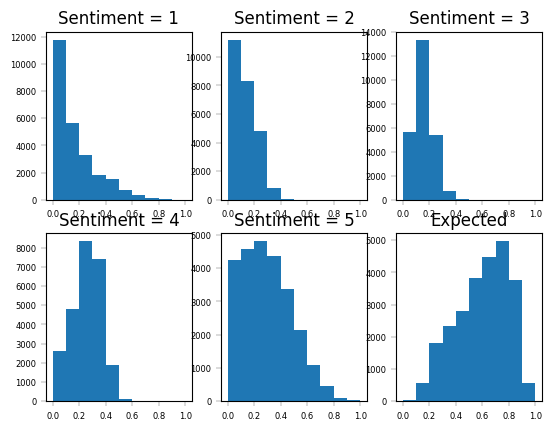

In [8]:
sentiHist(offComm)

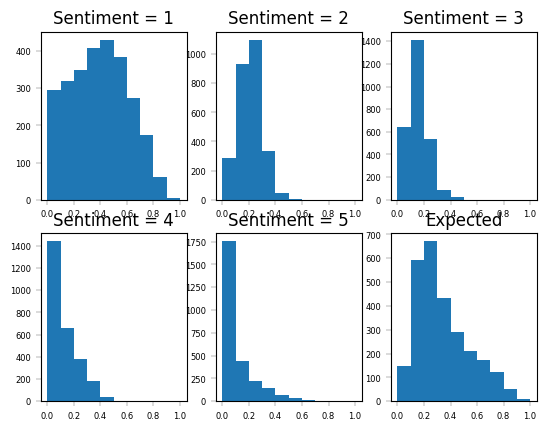

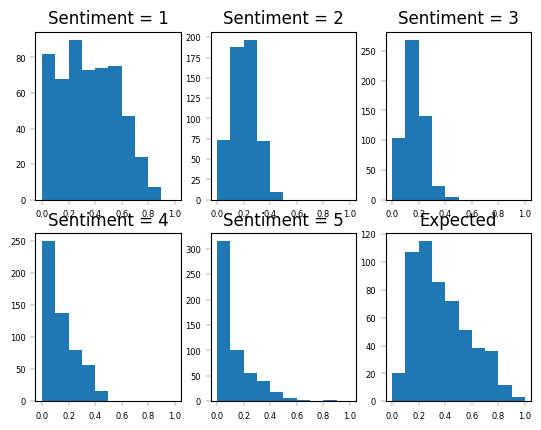

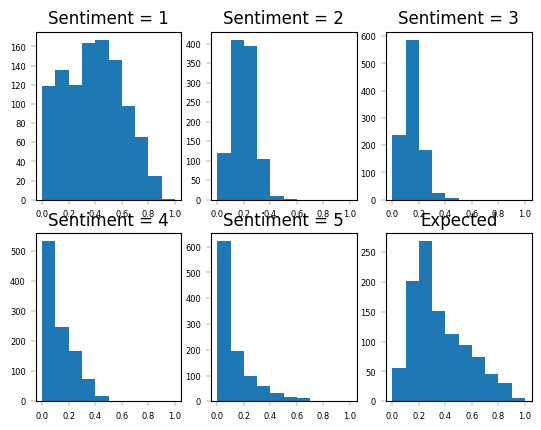

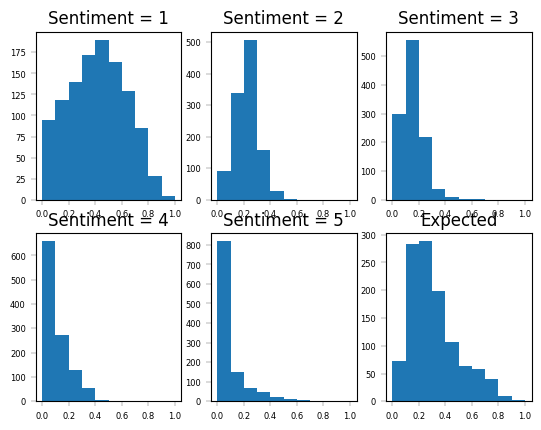

In [9]:
sentiHist(covidRumor)
sentiHist(covidRumor[covidRumor["label"] == "F"])
sentiHist(covidRumor[covidRumor["label"] == "T"])
sentiHist(covidRumor[covidRumor["label"] == "U"])

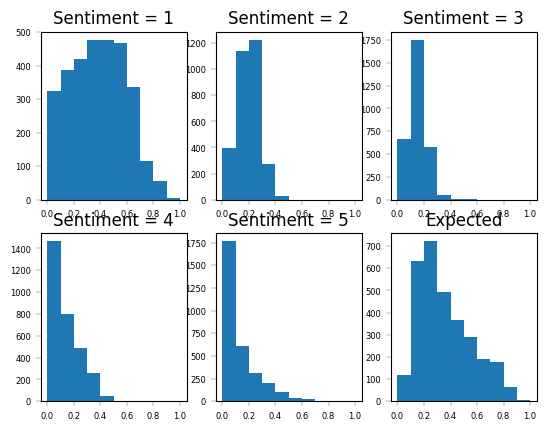

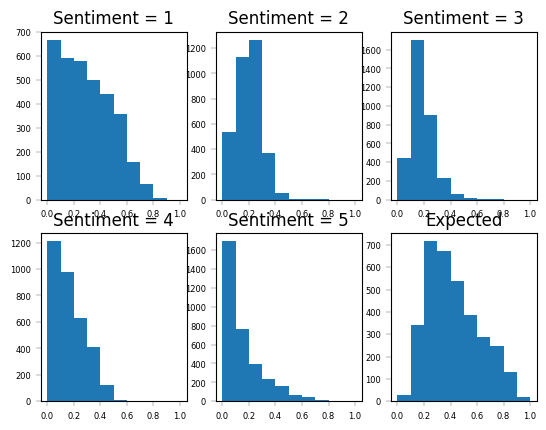

In [10]:
sentiHist(constraintAAAI[constraintAAAI["label"] == "fake"])
sentiHist(constraintAAAI[constraintAAAI["label"] == "real"])

In [11]:
def WordRankHist(df, name):


    fig, ax = plt.subplots(nrows = 2, ncols = 2)
    ax[0][0].hist(np.log(df["MaxRank"]),bins = [i for i in range(15)] , density=True)
    ax[0][0].set_title("Max")
    
    ax[0][1].hist(np.log(df["MedianRank"]),bins = [i for i in range(15)] , density=True)
    ax[0][1].set_title("Median")
    
    ax[1][0].hist(np.log(df["MedianContentRank"]),bins = [i for i in range(15)] , density=True)
    ax[1][0].set_title("Median Content")
    
    ax[1][1].hist(np.log(df["MinContentRank"]),bins = [i for i in range(15)] , density=True)
    ax[1][1].set_title("Min Content")


    for i in range(2):
        for j in range(2):
            ax[i][j].tick_params("both", labelsize=6, width = 0.2)
            ax[i][j].xaxis.set_ticks([i for i in range(2,15,1)])
            ax[i][j].yaxis.set_ticks([i*0.1 for i in range(0,8,1)])
            ax[i][j].set_xlim([2, 15])
            ax[i][j].set_ylim([0, 0.7])

            
    fig.suptitle(name)
                 
    plt.show()

In [12]:
np.log(2.71)

0.9969486348916096

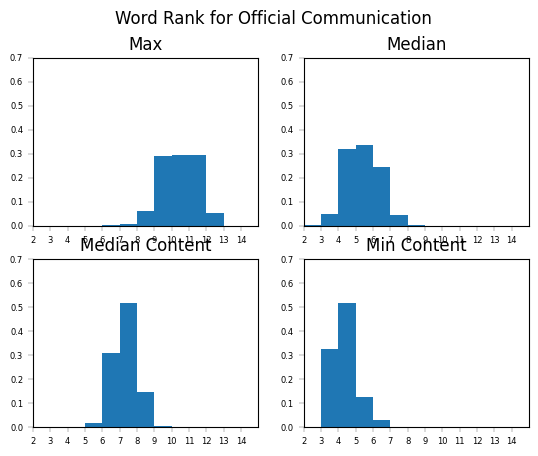

In [13]:
WordRankHist(offComm, "Word Rank for Official Communication")

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


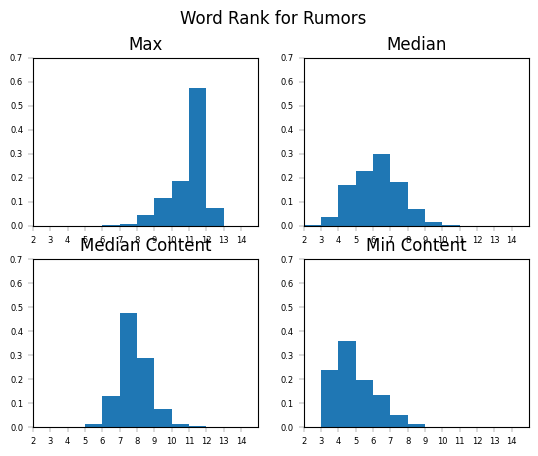

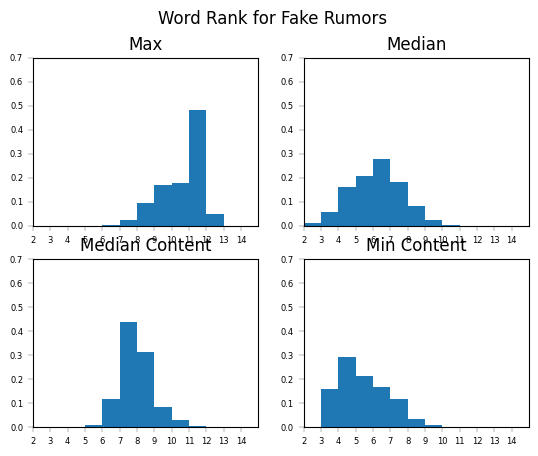

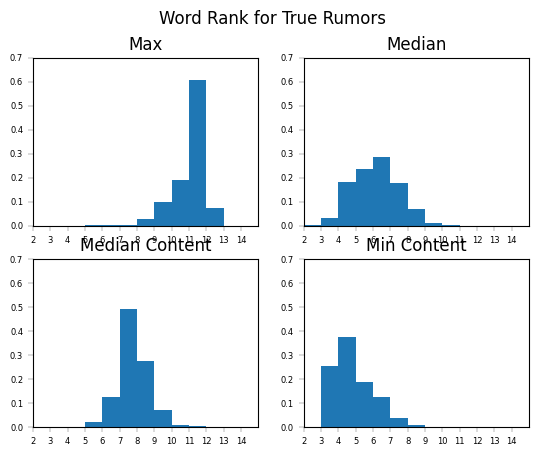

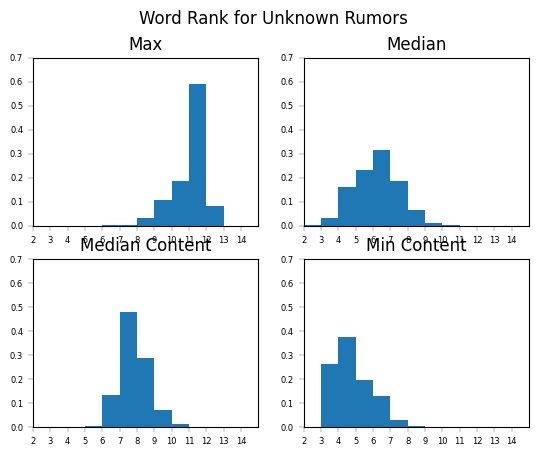

In [14]:
WordRankHist(covidRumor, "Word Rank for Rumors")
WordRankHist(covidRumor[covidRumor["label"] == "F"], "Word Rank for Fake Rumors")
WordRankHist(covidRumor[covidRumor["label"] == "T"], "Word Rank for True Rumors")
WordRankHist(covidRumor[covidRumor["label"] == "U"], "Word Rank for Unknown Rumors")

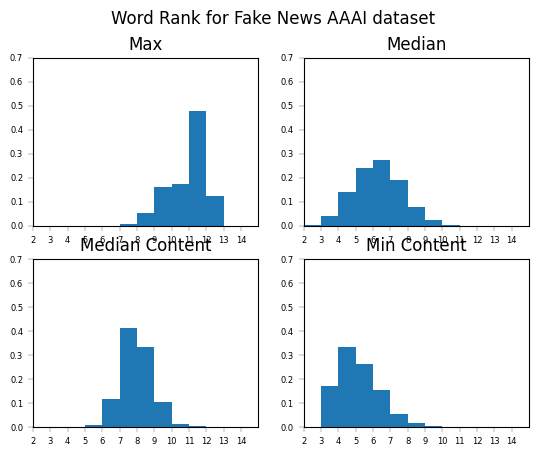

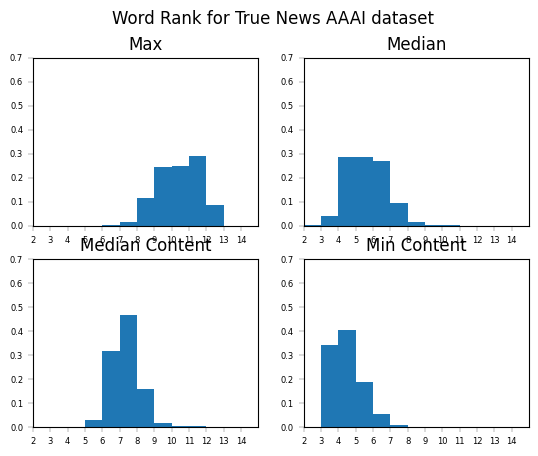

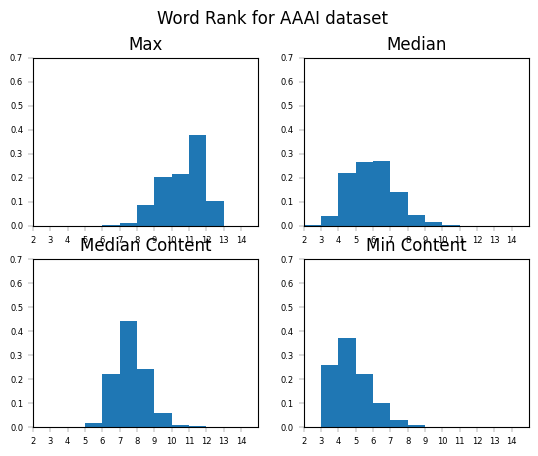

In [15]:
WordRankHist(constraintAAAI[constraintAAAI["label"] == "fake"], "Word Rank for Fake News AAAI dataset" )
WordRankHist(constraintAAAI[constraintAAAI["label"] == "real"], "Word Rank for True News AAAI dataset" )
WordRankHist(constraintAAAI, "Word Rank for AAAI dataset" )

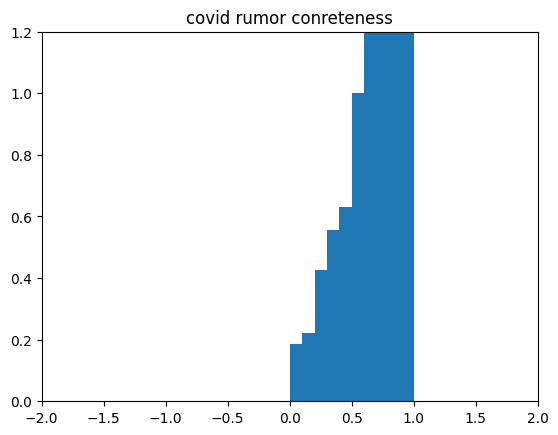

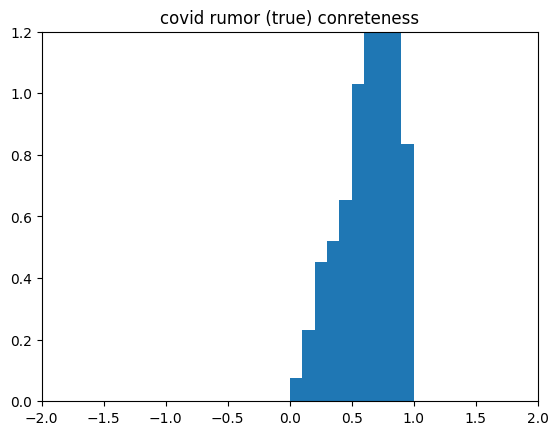

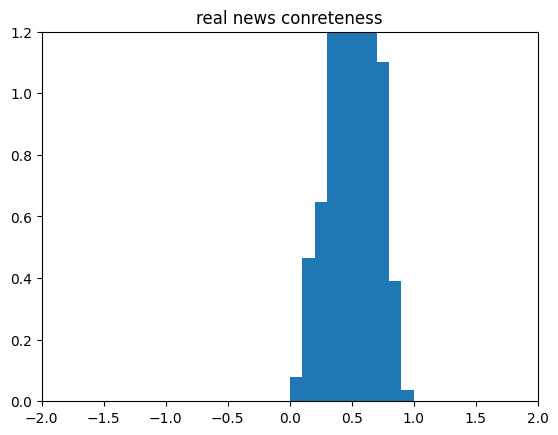

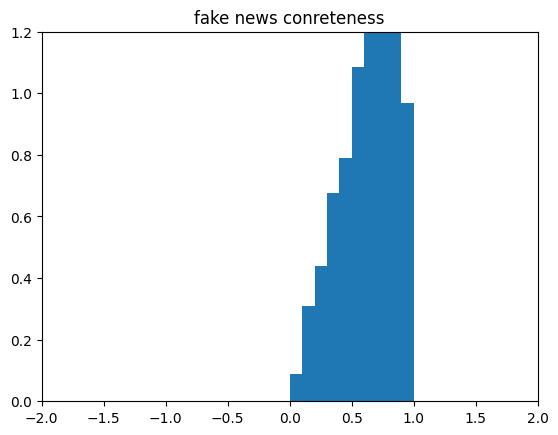

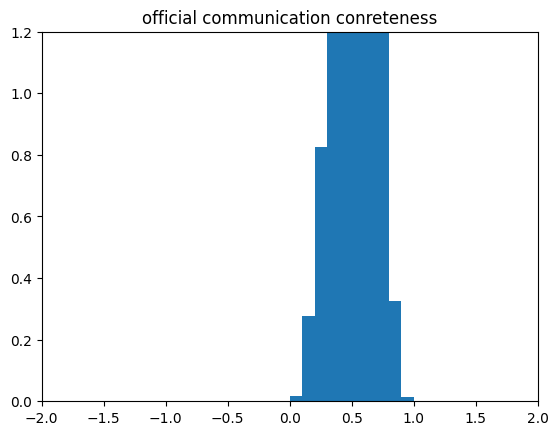

In [16]:
def ConcretenessHist(df, name):


    plt.hist(df["roberta_concreteness"],bins = [i/10.0 for i in range(-20,20)] , density=True)
    plt.title("Max")
    plt.xlim([-2,2])
    plt.ylim([0,1.2])     
    plt.title(name)
                 
    plt.show()
    
ConcretenessHist(covidRumor[covidRumor["label"] == "F"],"covid rumor conreteness")
ConcretenessHist(covidRumor[covidRumor["label"] == "T"],"covid rumor (true) conreteness")
ConcretenessHist(constraintAAAI[constraintAAAI["label"] == "real"],"real news conreteness")
ConcretenessHist(constraintAAAI[constraintAAAI["label"] == "fake"],"fake news conreteness")
ConcretenessHist(offComm,"official communication conreteness")

## Desicion Tree to create feature importance

In [68]:
def getFeatureMetrics(X,y):
    
    
    binary = True
    df = []
    
    for colName in X.columns:
        dtc = DecisionTreeClassifier(criterion = "gini", max_depth = 1, random_state = 928)
        dtc.fit([[i] for i in X[colName].to_list()], y)
        n = dtc.tree_.n_node_samples
        impurity = dtc.tree_.impurity
        if len(n) == 1:
            df.append([colName, 0,None,None, accuracy_score (dtc.predict([[i] for i in X[colName].to_list()]), y  ) ]) 
        else:
            result = []
            result.extend([colName, impurity[0] - sum([n[i]/n[0] * impurity[i] for i in range(1,len(n))]) ])
            
            #append left majority
            result.append(dtc.classes_[np.argmax(dtc.tree_.value[1][0])])
            #append right majority
            result.append(dtc.classes_[np.argmax(dtc.tree_.value[2][0])])
            
            yHat = dtc.predict([[i] for i in X[colName].to_list()])
            result.append( accuracy_score ( y, yHat  ) )
            result.append( balanced_accuracy_score ( y, yHat  ) )
            
            yHat = dtc.predict_proba([[i] for i in X[colName].to_list()])[:, 1]
            result.append( roc_auc_score ( y, yHat  ) )

            df.append(result)
            
    return pd.DataFrame(df, columns = ["feature", "gain","left","right", "accuracy", "accuracy (balanced)", "auc"]).sort_values("gain", ascending = False)
    

In [18]:
help(dtc.tree_)

NameError: name 'dtc' is not defined

In [54]:
dtc = DecisionTreeClassifier(criterion = "gini", max_depth = 1, random_state = 928)
dtc.fit([[i] for i in xTrain["Sentiment"].to_list()], yTrain)
dtc.tree_.n_node_samples

array([35863, 10937, 24926], dtype=int64)

In [55]:
dtc.tree_.value[1,0,1]


4167.0

In [56]:
getFeatureMetrics(xTrain,yTrain)

feature      gain      left     right  accuracy  \
5      MedianContentRank  0.059707  non-fake      fake  0.672197   
1                arousal  0.041651  non-fake      fake  0.643170   
6         MinContentRank  0.022876  non-fake      fake  0.567465   
39        WRDIMGc_megahr  0.018989  non-fake      fake  0.586928   
42              WRDHYPnv  0.018840  non-fake      fake  0.589382   
4             MedianRank  0.018729  non-fake      fake  0.578619   
15              PCREF_1p  0.014718      fake  non-fake  0.584586   
16              PCREF_ap  0.014661      fake  non-fake  0.584418   
3                MaxRank  0.014370  non-fake      fake  0.553161   
10                 DESPC  0.013516  non-fake      fake  0.546329   
8      roberta_dominance  0.012774      fake  non-fake  0.565290   
44             Sentiment  0.012599      fake  non-fake  0.573404   
43                   gis  0.011879      fake  non-fake  0.576276   
2              dominance  0.009824      fake  non-fake  0.570086   
38          PCCNC_megahr  0.009592  non-fake      fake  0.555224   
11                 DESSC  0.008203      fake  non-fake  0.561470   
17                  PCDC  0.008164  non-fake      fake  0.542732   
13               PCREF_1  0.007199      fake  non-fake  0.557957   
14               PCREF_a  0.007145      fake  non-fake  0.557734   
24       SMCAUSwn_1p_wup  0.005478      fake  non-fake  0.550874   
23       SMCAUSwn_1p_lch  0.005425      fake  non-fake  0.550595   
7        roberta_arousal  0.005133  non-fake      fake  0.541394   
22      SMCAUSwn_1p_path  0.005069      fake  non-fake  0.548783   
20            SMCAUSe_1p  0.004086      fake  non-fake  0.538271   
26       SMCAUSwn_ap_lch  0.003863      fake  non-fake  0.542760   
0                valence  0.003841      fake  non-fake  0.543513   
27       SMCAUSwn_ap_wup  0.003792      fake  non-fake  0.542593   
25      SMCAUSwn_ap_path  0.003479      fake  non-fake  0.540669   
9   roberta_concreteness  0.003202  non-fake      fake  0.524189   
21            SMCAUSe_ap  0.003150      fake  non-fake  0.507041   
18             SMCAUSe_1  0.002994      fake  non-fake  0.509885   
19             SMCAUSe_a  0.002938      fake  non-fake  0.506845   
40             PCCNC_mrc  0.002634  non-fake      fake  0.536263   
35    SMCAUSwn_ap_binary  0.001874      fake  non-fake  0.511223   
34    SMCAUSwn_1p_binary  0.001629      fake  non-fake  0.509606   
37     SMCAUSwn_a_binary  0.001554      fake  non-fake  0.510303   
36     SMCAUSwn_1_binary  0.001170      fake  non-fake  0.507766   
30        SMCAUSwn_1_wup  0.001073      fake  non-fake  0.522823   
29        SMCAUSwn_1_lch  0.001033      fake  non-fake  0.521680   
33        SMCAUSwn_a_wup  0.000985      fake  non-fake  0.522042   
28       SMCAUSwn_1_path  0.000973      fake  non-fake  0.520732   
41           WRDIMGc_mrc  0.000967  non-fake      fake  0.519087   
32        SMCAUSwn_a_lch  0.000921  non-fake      fake  0.511920   
31       SMCAUSwn_a_path  0.000774  non-fake      fake  0.514625   
12                 CoREF  0.000000      None      None  0.500823   

    accuracy (balanced)       auc  
5              0.672261  0.672261  
1              0.643062  0.643062  
6              0.568100  0.568100  
39             0.586550  0.586550  
42             0.589055  0.589055  
4              0.578134  0.578134  
15             0.584441  0.584441  
16             0.584273  0.584273  
3              0.553796  0.553796  
10             0.545645  0.545645  
8              0.565758  0.565758  
44             0.573084  0.573084  
43             0.576386  0.576386  
2              0.570066  0.570066  
38             0.554720  0.554720  
11             0.561229  0.561229  
17             0.542114  0.542114  
13             0.557733  0.557733  
14             0.557510  0.557510  
24             0.551055  0.551055  
23             0.550778  0.550778  
7              0.541857  0.541857  
22             0.548974  0.548974  
20             0.538696 

In [60]:
np.array([yTrain == "offComm"]).sum()

0

In [64]:
e

sentiment_1  sentiment_2  sentiment_3  sentiment_4  sentiment_5  \
0         0.302196     0.313121     0.196645     0.113740     0.074299   
1         0.088130     0.056195     0.083003     0.278266     0.494405   
2         0.055805     0.048949     0.128341     0.366148     0.400757   
3         0.176424     0.142939     0.170209     0.225260     0.285168   
4         0.207286     0.210703     0.213085     0.218432     0.150493   
...            ...          ...          ...          ...          ...   
25176     0.234689     0.203917     0.211210     0.200133     0.150052   
25177     0.053122     0.052240     0.138787     0.333172     0.422679   
25178     0.308450     0.176972     0.140037     0.189355     0.185186   
25179     0.031684     0.018310     0.033095     0.165794     0.751118   
25180     0.076409     0.077917     0.152728     0.353560     0.339386   

        valence   arousal  dominance  MaxRank  MedianRank  ...  \
0      5.578462  4.228462   5.531538      NaN         NaN  ...   
1      5.795000  4.690000   5.812727      NaN         NaN  ...   
2      5.848000  4.069000   5.778000      NaN         NaN  ...   
3      6.276875  4.078750   5.528125      NaN         NaN  ...   
4      5.657000  4.010000   5.596500      NaN         NaN  ...   
...         ...       ...        ...      ...         ...  ...   
25176  3.645556  4.727778   4.325556      NaN         NaN  ...   
25177  6.130000  3.615000   6.308333      NaN         NaN  ...   
25178  5.915000  3.490000   5.616000      NaN         NaN  ...   
25179  5.240625  4.200625   5.226875      NaN         NaN  ...   
25180  6.194000  3.807000   5.543000      NaN         NaN  ...   

       SMCAUSwn_ap_binary  SMCAUSwn_1_binary  SMCAUSwn_a_binary  PCCNC_megahr  \
0                0.000000                0.0           0.000000      3.275715   
1                0.047619                0.0           0.047619      3.153052   
2                0.035714                0.0           0.035714      3.170353   
3                0.100000                0.0           0.100000      3.216371   
4                0.000000                0.0           0.000000      3.265689   
...                   ...                ...                ...           ...   
25176            0.000000                0.0           0.000000      3.303139   
25177            0.000000                0.0           0.000000      3.084358   
25178            0.000000                0.0           0.000000      3.095236   
25179            0.000000                0.2           0.066667      3.234954   
25180            0.000000                0.0           0.000000      3.187065   

       WRDIMGc_megahr   PCCNC_mrc  WRDIMGc_mrc  WRDHYPnv       gis    label  
0            3.583827  208.305556   213.277778  1.138248  1.234288  offComm  
1            3.621402  240.375000   268.350000  1.036054  3.626798  offComm  
2            3.658715  206.150000   234.850000  1.168056  2.191985  offComm  
3            3.622989  200.789474   223.631579  1.093363  1.546160  offComm  
4            3.680496  230.500000   259.200000  1.117225  1.356973  offComm  
...               ...         ...          ...       ...       ...      ...  
25176        3.744650  235.571429   264.071429  1.181818  0.186004  offComm  
25177        3.520315  210.947368   236.684211  1.000000  1.035970  offComm  
25178        3.504887  183.882353   240.558824  1.054762  0.668450  offComm  
25179        3.662585  187.322581   237.064516  1.004464 -1.331390  offComm  
25180        3.546568  229.782609   270.608696  1.127976 -0.897489  offComm  

[25181 rows x 50 columns]

In [69]:
initDataset(includeText = False, includeLabel = True)

xy2 = pd.concat([e])
xy1 = resample(pd.concat([a,c,f,g]), replace=True, n_samples = len(xy2), random_state = 928 )


xy = pd.concat([xy1, xy2])


xy.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]] = np.log(xy.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]])
xy["Sentiment"] = 0.25*xy["sentiment_2"]+0.5*xy["sentiment_3"]+0.75*xy["sentiment_4"]+1*xy["sentiment_5"]
xy = xy.drop(columns = ["sentiment_" + str(i+1) for i in range(5)]).dropna()

Y = xy["label"]
X = xy.drop(columns = ["label"])
train_test_split

xTrain, xTest, yTrain, yTest = train_test_split( X, Y, test_size = 0.2, random_state = 928)

dtc1 = DecisionTreeClassifier(criterion = "gini", max_depth = 5, min_samples_split = 20, min_samples_leaf = 4, random_state = 928)
dtc1.fit(xTrain, yTrain)
print("Training accuracy: " + str(accuracy_score(dtc1.predict(xTrain), yTrain)) )
print("Testing accuracy: " + str(accuracy_score(dtc1.predict(xTest), yTest)) )

# pd.concat([
#     pd.DataFrame(xTrain.columns.tolist(), columns = ["Name"]), 
#     pd.DataFrame(dtc1.feature_importances_, columns = ["Importance"])
# ], axis = 1).sort_values("Importance", ascending=False)

getFeatureMetrics(xTrain,yTrain)

Training accuracy: 0.8701392342118349
Testing accuracy: 0.8689209348582795


feature      gain     left    right  accuracy  \
44             Sentiment  0.147391     fake  offComm  0.769891   
10                 DESPC  0.131621     fake  offComm  0.748036   
13               PCREF_1  0.108550     fake  offComm  0.725211   
11                 DESSC  0.105085     fake  offComm  0.691770   
14               PCREF_a  0.104857     fake  offComm  0.693312   
5      MedianContentRank  0.062810  offComm     fake  0.677176   
0                valence  0.051399     fake  offComm  0.656539   
8      roberta_dominance  0.050792     fake  offComm  0.659025   
4             MedianRank  0.047510  offComm     fake  0.616484   
2              dominance  0.040873     fake  offComm  0.640552   
26       SMCAUSwn_ap_lch  0.038537  offComm     fake  0.636673   
27       SMCAUSwn_ap_wup  0.038020  offComm     fake  0.635728   
6         MinContentRank  0.035921  offComm     fake  0.612183   
25      SMCAUSwn_ap_path  0.033396  offComm     fake  0.626977   
7        roberta_arousal  0.033087  offComm     fake  0.628270   
1                arousal  0.029491  offComm     fake  0.604152   
3                MaxRank  0.026978  offComm     fake  0.609100   
30        SMCAUSwn_1_wup  0.019677     fake  offComm  0.583093   
9   roberta_concreteness  0.019550  offComm     fake  0.553879   
29        SMCAUSwn_1_lch  0.019305     fake  offComm  0.586574   
28       SMCAUSwn_1_path  0.018489     fake  offComm  0.582919   
33        SMCAUSwn_a_wup  0.018221     fake  offComm  0.577350   
31       SMCAUSwn_a_path  0.017938     fake  offComm  0.578841   
32        SMCAUSwn_a_lch  0.017512     fake  offComm  0.580806   
39        WRDIMGc_megahr  0.016984  offComm     fake  0.570786   
21            SMCAUSe_ap  0.015949  offComm     fake  0.587718   
38          PCCNC_megahr  0.015510  offComm     fake  0.564446   
19             SMCAUSe_a  0.012798     fake  offComm  0.557857   
18             SMCAUSe_1  0.010950     fake  offComm  0.547489   
15              PCREF_1p  0.007402     fake  offComm  0.560393   
16              PCREF_ap  0.007359     fake  offComm  0.560219   
42              WRDHYPnv  0.007060  offComm     fake  0.547812   
40             PCCNC_mrc  0.006393     fake  offComm  0.515042   
41           WRDIMGc_mrc  0.006314     fake  offComm  0.528866   
43                   gis  0.005361     fake  offComm  0.524913   
37     SMCAUSwn_a_binary  0.003966     fake  offComm  0.540080   
23       SMCAUSwn_1p_lch  0.003965  offComm     fake  0.541820   
24       SMCAUSwn_1p_wup  0.003925  offComm     fake  0.541348   
22      SMCAUSwn_1p_path  0.003691  offComm     fake  0.540254   
17                  PCDC  0.002554  offComm     fake  0.520761   
20            SMCAUSe_1p  0.002245  offComm     fake  0.530358   
36     SMCAUSwn_1_binary  0.002001     fake  offComm  0.520239   
35    SMCAUSwn_ap_binary  0.000410  offComm     fake  0.502461   
34    SMCAUSwn_1p_binary  0.000294  offComm     fake  0.506191   
12                 CoREF  0.000000     None     None  0.500448   

    accuracy (balanced)       auc  
44             0.769938  0.769938  
10             0.748149  0.748149  
13             0.725096  0.725096  
11             0.691525  0.691525  
14             0.693071  0.693071  
5              0.677165  0.677165  
0              0.656441  0.656441  
8              0.658995  0.658995  
4              0.616190  0.616190  
2              0.640469  0.640469  
26             0.636750  0.636750  
27             0.635806  0.635806  
6              0.611937  0.611937  
25             0.627058  0.627058  
7              0.628235  0.628235  
1              0.603921  0.603921  
3              0.609252  0.609252  
30             0.582847  0.582847  
9              0.553502  0.553502  
29             0.586361  0.586361  
28             0.582691  0.582691  
33             0.577086  0.577086  
31             0.578592  0.578592  
32             0.580578  0.580578  
39             0.570498  0.570498  
21             0.587799  0.587799  
38      

In [70]:
ada1 = AdaBoostClassifier(n_estimators = 1000, random_state = 928)
ada1.fit(xTrain, yTrain)
print("Training accuracy: " + str(accuracy_score(ada1.predict(xTrain), yTrain)) )
print("Testing accuracy: " + str(accuracy_score(ada1.predict(xTest), yTest)) )

Training accuracy: 0.9282197911486822
Testing accuracy: 0.9230233714569865


In [71]:
## LGBM
lgb1 = LGBMClassifier(n_estimators=1000, importance_type = "gain", random_state = 928)
lgb1.fit(xTrain, yTrain)
print("Training accuracy: " + str(accuracy_score(lgb1.predict(xTrain), yTrain)) )
print("Testing accuracy: " + str(accuracy_score(lgb1.predict(xTest), yTest)) )

Training accuracy: 1.0
Testing accuracy: 0.9746394828443561


In [72]:
initDataset(includeText = False, includeLabel = True)


xy1 = pd.concat([a,c,f,g])
xy2 = resample(pd.concat([b,d,h]), replace=True, n_samples = len(xy1), random_state = 928 )
xy = pd.concat([xy1,xy2])

xy.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]] = np.log(xy.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]])
xy["Sentiment"] = 0.25*xy["sentiment_2"]+0.5*xy["sentiment_3"]+0.75*xy["sentiment_4"]+1*xy["sentiment_5"]
xy = xy.drop(columns = ["sentiment_" + str(i+1) for i in range(5)]).dropna()

Y = xy["label"]
X = xy.drop(columns = ["label"])
train_test_split

xTrain, xTest, yTrain, yTest = train_test_split( X, Y, test_size = 0.2, random_state = 928)

dtc2 = DecisionTreeClassifier(criterion = "gini", max_depth = 5, min_samples_split = 20, min_samples_leaf = 4, random_state = 928)
dtc2.fit(xTrain, yTrain)

print("Training accuracy: " + str(accuracy_score(dtc2.predict(xTrain), yTrain)) )
print("Testing accuracy: " + str(accuracy_score(dtc2.predict(xTest), yTest)) )
# pd.concat([
#     pd.DataFrame(xTrain.columns.tolist(), columns = ["Name"]), 
#     pd.DataFrame(dtc2.feature_importances_, columns = ["Importance"])
# ], axis = 1).sort_values("Importance", ascending=False)

getFeatureMetrics(xTrain,yTrain)

Training accuracy: 0.7458104453057469
Testing accuracy: 0.7378987285300023


feature      gain      left     right  accuracy  \
5      MedianContentRank  0.059707  non-fake      fake  0.672197   
1                arousal  0.041651  non-fake      fake  0.643170   
6         MinContentRank  0.022876  non-fake      fake  0.567465   
39        WRDIMGc_megahr  0.018989  non-fake      fake  0.586928   
42              WRDHYPnv  0.018840  non-fake      fake  0.589382   
4             MedianRank  0.018729  non-fake      fake  0.578619   
15              PCREF_1p  0.014718      fake  non-fake  0.584586   
16              PCREF_ap  0.014661      fake  non-fake  0.584418   
3                MaxRank  0.014370  non-fake      fake  0.553161   
10                 DESPC  0.013516  non-fake      fake  0.546329   
8      roberta_dominance  0.012774      fake  non-fake  0.565290   
44             Sentiment  0.012599      fake  non-fake  0.573404   
43                   gis  0.011879      fake  non-fake  0.576276   
2              dominance  0.009824      fake  non-fake  0.570086   
38          PCCNC_megahr  0.009592  non-fake      fake  0.555224   
11                 DESSC  0.008203      fake  non-fake  0.561470   
17                  PCDC  0.008164  non-fake      fake  0.542732   
13               PCREF_1  0.007199      fake  non-fake  0.557957   
14               PCREF_a  0.007145      fake  non-fake  0.557734   
24       SMCAUSwn_1p_wup  0.005478      fake  non-fake  0.550874   
23       SMCAUSwn_1p_lch  0.005425      fake  non-fake  0.550595   
7        roberta_arousal  0.005133  non-fake      fake  0.541394   
22      SMCAUSwn_1p_path  0.005069      fake  non-fake  0.548783   
20            SMCAUSe_1p  0.004086      fake  non-fake  0.538271   
26       SMCAUSwn_ap_lch  0.003863      fake  non-fake  0.542760   
0                valence  0.003841      fake  non-fake  0.543513   
27       SMCAUSwn_ap_wup  0.003792      fake  non-fake  0.542593   
25      SMCAUSwn_ap_path  0.003479      fake  non-fake  0.540669   
9   roberta_concreteness  0.003202  non-fake      fake  0.524189   
21            SMCAUSe_ap  0.003150      fake  non-fake  0.507041   
18             SMCAUSe_1  0.002994      fake  non-fake  0.509885   
19             SMCAUSe_a  0.002938      fake  non-fake  0.506845   
40             PCCNC_mrc  0.002634  non-fake      fake  0.536263   
35    SMCAUSwn_ap_binary  0.001874      fake  non-fake  0.511223   
34    SMCAUSwn_1p_binary  0.001629      fake  non-fake  0.509606   
37     SMCAUSwn_a_binary  0.001554      fake  non-fake  0.510303   
36     SMCAUSwn_1_binary  0.001170      fake  non-fake  0.507766   
30        SMCAUSwn_1_wup  0.001073      fake  non-fake  0.522823   
29        SMCAUSwn_1_lch  0.001033      fake  non-fake  0.521680   
33        SMCAUSwn_a_wup  0.000985      fake  non-fake  0.522042   
28       SMCAUSwn_1_path  0.000973      fake  non-fake  0.520732   
41           WRDIMGc_mrc  0.000967  non-fake      fake  0.519087   
32        SMCAUSwn_a_lch  0.000921  non-fake      fake  0.511920   
31       SMCAUSwn_a_path  0.000774  non-fake      fake  0.514625   
12                 CoREF  0.000000      None      None  0.500823   

    accuracy (balanced)       auc  
5              0.672261  0.672261  
1              0.643062  0.643062  
6              0.568100  0.568100  
39             0.586550  0.586550  
42             0.589055  0.589055  
4              0.578134  0.578134  
15             0.584441  0.584441  
16             0.584273  0.584273  
3              0.553796  0.553796  
10             0.545645  0.545645  
8              0.565758  0.565758  
44             0.573084  0.573084  
43             0.576386  0.576386  
2              0.570066  0.570066  
38             0.554720  0.554720  
11             0.561229  0.561229  
17             0.542114  0.542114  
13             0.557733  0.557733  
14             0.557510  0.557510  
24             0.551055  0.551055  
23             0.550778  0.550778  
7              0.541857  0.541857  
22             0.548974  0.548974  
20             0.538696 

In [73]:
ada2 = AdaBoostClassifier(n_estimators = 1000, random_state = 928)
ada2.fit(xTrain, yTrain)

print("Training accuracy: " + str(accuracy_score(ada2.predict(xTrain), yTrain)) )
print("Testing accuracy: " + str(accuracy_score(ada2.predict(xTest), yTest)) )

Training accuracy: 0.8386359200289992
Testing accuracy: 0.82578630381441


In [74]:
## LGBM
lgb2 = LGBMClassifier(n_estimators=1000, importance_type = "gain", random_state = 928)
lgb2.fit(xTrain, yTrain)

print("Training accuracy: " + str(accuracy_score(lgb2.predict(xTrain), yTrain)) )
print("Testing accuracy: " + str(accuracy_score(lgb2.predict(xTest), yTest)) )

Training accuracy: 1.0
Testing accuracy: 0.966540263216596


In [ ]:
initDataset(includeText = False, includeLabel = True)
xy = pd.concat([a,b,c,d,e,f,g,h])

xy.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]] = np.log(xy.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]])
xy["Sentiment"] = 0.25*xy["sentiment_2"]+0.5*xy["sentiment_3"]+0.75*xy["sentiment_4"]+1*xy["sentiment_5"]
xy = xy.drop(columns = ["sentiment_" + str(i+1) for i in range(5)]).dropna()

Y = xy["label"]
X = xy.drop(columns = ["label"])
train_test_split

xTrain, xTest, yTrain, yTest = train_test_split( X, Y, test_size = 0.001, random_state = 928)

dtc3 = DecisionTreeClassifier(criterion = "gini", max_depth = 5, min_samples_split = 20, min_samples_leaf = 4, random_state = 928)
dtc3.fit(xTrain, yTrain)

print("Training accuracy: " + str(accuracy_score(dtc3.predict(xTrain), yTrain)) )
print("Testing accuracy: " + str(accuracy_score(dtc3.predict(xTest), yTest)) )
pd.concat([
    pd.DataFrame(xTrain.columns.tolist(), columns = ["Name"]), 
    pd.DataFrame(dtc3.feature_importances_, columns = ["Importance"])
], axis = 1).sort_values("Importance", ascending=False)

In [ ]:
ada3 = AdaBoostClassifier(n_estimators = 1000, random_state = 928)
ada3.fit(xTrain, yTrain)

print("Training accuracy: " + str(accuracy_score(ada3.predict(xTrain), yTrain)) )
print("Testing accuracy: " + str(accuracy_score(ada3.predict(xTest), yTest)) )
pd.concat([
    pd.DataFrame(xTrain.columns.tolist(), columns = ["Name"]), 
    pd.DataFrame(ada3.feature_importances_, columns = ["Importance"])
], axis = 1).sort_values("Importance", ascending=False)

In [ ]:
## LGBM
lgb3 = LGBMClassifier(n_estimators=1000, importance_type = "gain", random_state = 928)
lgb3.fit(xTrain, yTrain)

print("Training accuracy: " + str(accuracy_score(lgb3.predict(xTrain), yTrain)) )
print("Testing accuracy: " + str(accuracy_score(lgb3.predict(xTest), yTest)) )
pd.concat([
    pd.DataFrame(xTrain.columns.tolist(), columns = ["Name"]), 
    pd.DataFrame(lgb3.feature_importances_, columns = ["Importance"])
], axis = 1).sort_values("Importance", ascending=False)

In [ ]:
def listPrincipleComponent(x):
    
    x.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]] = np.log(x.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]])
    x["Sentiment"] = 0.25*x["sentiment_2"]+0.5*x["sentiment_3"]+0.75*x["sentiment_4"]+1*x["sentiment_5"]
    x = x.drop(columns = ["sentiment_" + str(i+1) for i in range(5)]).dropna()
    
    try:
        x = x.drop(columns = ["label"])
    except KeyError:
        pass
    
    pca = PCA(svd_solver = "full") #dont be greedy if n is small you got your 8GB RAM your gonna use the entire RAM
    pca.fit(x)


    return pd.concat([
        pd.DataFrame(np.round([pca.explained_variance_/pca.explained_variance_.sum()], 4), index = ["% Explained Var"]),
        pd.DataFrame(np.round(pca.components_.transpose(),4), index = x.columns)
    ])

In [ ]:
def KLTransform(x, nComponents = None):
    
    X = x.copy()
    procX = X - np.mean(X, axis = 0)
    procX = np.dot(procX.T, procX) / X.shape[0]
    pca = PCA()
    pca.fit(procX)
    
    lambdas = []
    #eigenvector and eigenvalues
    for v in pca.components_:
        lambdas.append( np.dot(v.T, np.dot(procX, v)) ) 
    _, sortedPhi = zip(*sorted( zip(lambdas, pca.components_), key=lambda x: x[0], reverse = True ) ) 
    sortedPhi = np.array(sortedPhi)
    result = np.dot(sortedPhi, X.T ).T
    
    if nComponents != None:
        return np.array([i[len(i) - nComponents:] for i in result])
    
    return result

def KLT(x,nComponents = None):
    
    x.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]] = np.log(x.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]])
    x["Sentiment"] = 0.25*x["sentiment_2"]+0.5*x["sentiment_3"]+0.75*x["sentiment_4"]+1*x["sentiment_5"]
    
    x = x.drop(columns = ["sentiment_" + str(i+1) for i in range(5)]).dropna().reset_index()
    y = None
    z = None
    
    try:
        y = x["label"]
        x = x.drop(columns = ["label"])
    except KeyError:
        pass
    
    try:
        z = x["content"]
        x = x.drop(columns = ["content"])
    except KeyError:
        pass
    
    return KLTransform(x, nComponents), y, z




# KLTransform(np.array([[0, 3.,3.],[0, 0.,2.],[0, -1.,-1.],[0, 2.,0.]]))
KLTransform(np.array([[3.,3., 0,0],[0.,2., 0,0],[-1.,-1., 0,0],[2.,0., 0,0]]))
#a = KLTransform(np.array([[3.,3.],[0.,2.],[-1.,-1.],[2.,0.]]), 1)
y = PCA()
y.fit_transform(np.array([[3.,3.],[0.,2.],[-1.,-1.],[2.,0.]]))

tr = KLT(getParameters(covidRumor[covidRumor["label"] == "F"]),5)
plt.scatter(tr[:,0], tr[:,1])

In [ ]:
a = labelThisAs(getParametersAndText(covidRumor[covidRumor["label"] == "F"].reset_index()), "fake")
b = labelThisAs(getParametersAndText(covidRumor[covidRumor["label"] == "T"].reset_index()), "non-fake")
c = labelThisAs(getParametersAndText(constraintAAAI[constraintAAAI["label"] == "fake"].reset_index()), "fake")
d = labelThisAs(getParametersAndText(constraintAAAI[constraintAAAI["label"] == "real"].reset_index()), "non-fake")
e = labelThisAs(getParametersAndText(offComm), "offComm")

xy = pd.concat([a, b, c, d, e])
xy.dropna()

x
# tr, Y0, Z0 = KLT(xy,45)

# for i in range(45):
#     for j in range(i+1,45):
#         plt.scatter(tr[Y0 == "offComm",i], tr[Y0 == "offComm",j], alpha = 0.5, s = 0.3)
#         plt.scatter(tr[Y0 == "non-fake",i], tr[Y0 == "non-fake",j], alpha = 0.5, s = 0.3)
#         plt.scatter(tr[Y0 == "fake",i], tr[Y0 == "fake",j], alpha = 0.5, s = 0.3)
#         plt.title("i: " + str(i) + "j: " + str(j))
#         plt.legend(["offComm","non-fake","fake"])
#         plt.show()

In [ ]:
a = labelThisAs(getParametersAndText(covidRumor[covidRumor["label"] == "F"].reset_index(), "content"), "fake")
b = labelThisAs(getParametersAndText(covidRumor[covidRumor["label"] == "T"].reset_index(), "content"), "non-fake")
c = labelThisAs(getParametersAndText(constraintAAAI[constraintAAAI["label"] == "fake"].reset_index(), "tweet"), "fake")
d = labelThisAs(getParametersAndText(constraintAAAI[constraintAAAI["label"] == "real"].reset_index(), "tweet"), "non-fake")
e = labelThisAs(getParametersAndText(offComm, "rawContent"), "offComm")

xy = pd.concat([a, b, c, d, e])
xy.dropna()
n_clusters = 10
tr, Y0, Z0 = KLT(xy,xy.shape[1] - 5)
kmeansKL = KMeans(n_clusters = n_clusters, max_iter = 800, random_state = 928)
clust = kmeansKL.fit_predict(tr)

# for i in range(10):
#     for j in range(i+1,10):
#         for k in range(n_clusters):
            
#             select = "offComm"
#             plt.scatter(tr[(Y0 == select) & (clust == k),i] , tr[(Y0 == select) & (clust == k),j] , alpha = 0.5, s = 0.3)
            
#             select = "non-fake"
#             plt.scatter(tr[(Y0 == select) & (clust == k),i] , tr[(Y0 == select) & (clust == k),j] , alpha = 0.5, s = 0.3)
            
#             select = "fake"
#             plt.scatter(tr[(Y0 == select) & (clust == k),i] , tr[(Y0 == select) & (clust == k),j] , alpha = 0.5, s = 0.3)
            
#             plt.title("i: " + str(i) + " j: " + str(j) + " k: " + str(j))
#             plt.legend(["offComm","non-fake","fake"])
#             plt.show()

In [ ]:
for k in range(n_clusters):
    print("=============")
    print("== Cluster" + str(k) + " ==")
    print("=============")
    count = 0
    until = 10
    while count < until:
        target = math.floor(random.random() * len(tr))
        if clust[target] == k:
            count += 1
            print([Y0[target],Z0[target][:100]])
            print()

In [ ]:
model = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [50]:

inputs = tokenizer("test test test test", return_tensors="pt", truncation=True)
result = model(**inputs)[0]
result




tensor([[[-0.2478, -0.0414, -0.1958,  ..., -0.3402,  0.1281,  0.3851],
         [ 0.2042, -0.4471, -0.2376,  ..., -0.1818,  0.5177, -0.1839],
         [ 0.2577, -0.2006, -0.0210,  ..., -0.5617,  0.0359, -0.6027],
         [ 0.2150, -0.2416, -0.0471,  ..., -0.5693,  0.1038, -0.5462],
         [ 0.4412, -0.3534, -0.1534,  ..., -0.5030, -0.1035, -0.7534],
         [ 0.7476,  0.1272, -0.2844,  ...,  0.0151, -0.6726, -0.3655]]],
       grad_fn=<NativeLayerNormBackward0>)

In [179]:
Z0

0        If you can hold your breath without coughing, ...
1        A homemade hand sanitizer made with Tito's Vod...
2        Gargling with salt water or Vinegar 'eliminate...
3        Chinese officials are seeking approval to star...
4        U.S. House Speaker Nancy Pelosi held up a coro...
                               ...                        
33176    What does it mean when #polio virus is detecte...
33177    If you plan to attend the @FIFAWorldCup in #Qa...
33178    Second round of public hearings towards a #Pan...
33179    This year, #WorldRabiesDay, let us bring toget...
33180    🔴LIVE NOW - The second round of public hearing...
Name: content, Length: 33096, dtype: object

In [337]:
a = labelThisAs(getParametersAndText(covidRumor[covidRumor["label"] == "F"].reset_index(), "content"), "fake")
b = labelThisAs(getParametersAndText(covidRumor[covidRumor["label"] == "T"].reset_index(), "content"), "non-fake")
c = labelThisAs(getParametersAndText(constraintAAAI[constraintAAAI["label"] == "fake"].reset_index(), "tweet"), "fake")
d = labelThisAs(getParametersAndText(constraintAAAI[constraintAAAI["label"] == "real"].reset_index(), "tweet"), "non-fake")
e = labelThisAs(getParametersAndText(offComm, "rawContent"), "offComm")

xy = pd.concat([a, b, c, d, e])
xy.dropna()

n_clusters = 10
tr, Y0, Z0 = KLT(xy,20)

In [298]:
countVec = CountVectorizer(min_df = 0.005, max_df = 0.5, ngram_range = (1,3))
result = countVec.fit_transform(Z0)
# tfidftransform = TfidfTransformer()
# countResult = tfidftransform.fit_transform(result).toarray()
# 
argSort = np.argsort(result.toarray().sum(axis = 0))
Sort = np.sort(result.toarray().sum(axis = 0))
frequentItems = np.array([Sort, countVec.get_feature_names_out()[argSort]]).T
frequentItems = np.flip(frequentItems)
for i in frequentItems:
    print(i)

['of' 22931]
['and' 22238]
['in' 18384]
['covid19' 15484]
['for' 12790]
['you' 12434]
['more' 11090]
['is' 10419]
['covid' 10034]
['your' 9013]
['are' 8813]
['19' 8721]
['covid 19' 8510]
['on' 8385]
['from' 7232]
['have' 7079]
['with' 6883]
['amp' 6803]
['we' 6364]
['vaccine' 6297]
['can' 6151]
['coronavirus' 5970]
['at' 5730]
['it' 5486]
['people' 5441]
['as' 5404]
['this' 4966]
['or' 4949]
['if' 4885]
['that' 4711]
['in the' 4170]
['help' 4085]
['be' 4068]
['has' 3808]
['will' 3785]
['by' 3784]
['more https co' 3780]
['more https' 3780]
['new' 3765]
['health' 3748]
['who' 3730]
['get' 3674]
['of the' 3662]
['if you' 3600]
['cases' 3570]
['about' 3546]
['our' 3362]
['find' 3244]
['vaccines' 3229]
['all' 3224]
['pandemic' 3217]
['learn' 3185]
['how' 3139]
['out' 3086]
['been' 2905]
['spread' 2810]
['their' 2747]
['protect' 2681]
['now' 2511]
['learn more' 2474]
['nhs' 2399]
['children' 2337]
['not' 2281]
['during' 2266]
['vaccination' 2194]
['today' 2193]
['the covid19' 2182]
['re' 214

In [146]:
def isVacRelated(text):
    return bool(re.search(pattern= ".*(vaccine|vaccination|vaccinated|booster|dose).*" , string=text))

def isInfecRelated(text):
    return bool(re.search(pattern= ".*(case|spread|death|total number|positive|infect).*" , string=text))

def isPrevRelated(text):
    return bool(re.search(pattern= ".*(protect|prevent|wash|face covering).*" , string=text))

def isTestRelated(text):
    return bool(re.search(pattern= ".*(test).*" , string=text))

def isSocEventRelated(text):
    return bool(re.search(pattern= ".*(work|school|lockdown).*" , string=text))

def isSymptomRelated(text):
    return bool(re.search(pattern= ".*(symptom|cough).*" , string=text))

xy = pd.concat([a, b, c, d, e, f, g, h])
xy.dropna()
tr, Y0, Z0 = KLT(xy,10)


relationFunction = [isVacRelated, isInfecRelated, isPrevRelated, isTestRelated, isSocEventRelated, isSymptomRelated]


vacRelated = np.array([isVacRelated(i) for i in Z0])
infecRelated = np.array([isInfecRelated(i) for i in Z0])
prevRelated = np.array([isPrevRelated(i) for i in Z0])
testRelated = np.array([isTestRelated(i) for i in Z0])
socEventRelated = np.array([isSocEventRelated(i) for i in Z0])
symptomRelated = np.array([isSymptomRelated(i) for i in Z0])






In [164]:
listData = initDataset(includeText = True, includeLabel = True, returnList = True)

contentTopics = []

for i in range(8):
    temp = []
    for j in range(6):
        temp.append([relationFunction[j](k) for k in listTopics[i]])
    contentTopics.append(temp)

In [153]:
print("vaccine related percentage: " + str(round(vacRelated.sum()/len(Z0),4)))
print("infection related percentage: " + str(round(infecRelated.sum()/len(Z0),4)))
print("prevention related percentage: " + str(round(prevRelated.sum()/len(Z0),4)))
print("test related percentage: " + str(round(testRelated.sum()/len(Z0),4)))
print("social event related percentage: " + str(round(socEventRelated.sum()/len(Z0),4)))
print("sympton related percentage: " + str(round(symptomRelated.sum()/len(Z0),4)))

covered = np.logical_or(np.logical_or(np.logical_or(np.logical_or(np.logical_or(vacRelated,infecRelated),prevRelated),testRelated),socEventRelated),symptomRelated)
print("covered percentage: " + str(round(covered.sum()/len(Z0),4)))

vaccine related percentage: 0.3408
infection related percentage: 0.2538
prevention related percentage: 0.1375
test related percentage: 0.1583
social event related percentage: 0.0982
sympton related percentage: 0.0463
covered percentage: 0.6906


In [150]:
topics = [vacRelated, infecRelated, prevRelated, testRelated, socEventRelated, symptomRelated]
topicName = ["vaccine", "infection", "prevention", "testing", "social events", "symptoms"]
matrix = [[0 for i in range(6)] for i in range(6)]

for i in range(len(topics)):
    for j in range(len(topics)):
        matrix[i][j] = round(np.logical_and(topics[i], topics[j]).sum()/len(Z0),4)
        
pd.DataFrame(matrix, columns = topicName, index = topicName)

vaccine  infection  prevention  testing  social events  \
vaccine         0.3408     0.0625      0.0657   0.0191         0.0311   
infection       0.0625     0.2538      0.0502   0.0730         0.0187   
prevention      0.0657     0.0502      0.1375   0.0103         0.0175   
testing         0.0191     0.0730      0.0103   0.1583         0.0149   
social events   0.0311     0.0187      0.0175   0.0149         0.0982   
symptoms        0.0079     0.0199      0.0090   0.0173         0.0037   

               symptoms  
vaccine          0.0079  
infection        0.0199  
prevention       0.0090  
testing          0.0173  
social events    0.0037  
symptoms         0.0463

In [176]:
listData = initDataset(includeText = True, includeLabel = True, returnList = True)
result = []
topics = [isVacRelated, isInfecRelated, isPrevRelated, isTestRelated, isSocEventRelated, isSymptomRelated]
for dat in listData:
    _,_, Z0 = KLT(dat,10)
    # Z0 = Z0.dropna().reset_index(drop = True)
    related = []
    for j in topics:
        related.append( np.array([  j(k) for k in Z0]) )  
    result.append(related)
print(result)



[[array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, Fals

In [185]:
pd.DataFrame(np.array([[round(i.sum()/len(i),4) for i in j] for j in result]).T, 
             columns = ["covidRumor - Fake","covidRumor - NonFake","AAAI - Fake","AAAI - NonFake","OffComm","COAID","TruthSeeker - Fake","TruthSeeker - NonFake"], 
             index = topicName)

covidRumor - Fake  covidRumor - NonFake  AAAI - Fake  \
vaccine                   0.0170                0.0136       0.0663   
infection                 0.1951                0.2774       0.1912   
prevention                0.0701                0.0485       0.0351   
testing                   0.0777                0.0708       0.0800   
social events             0.0606                0.0543       0.0807   
symptoms                  0.0265                0.0272       0.0112   

               AAAI - NonFake  OffComm   COAID  TruthSeeker - Fake  \
vaccine                0.0325   0.3381  0.0089              0.6860   
infection              0.4733   0.2370  0.1456              0.2806   
prevention             0.0560   0.2120  0.0258              0.1058   
testing                0.2714   0.1455  0.1505              0.1311   
social events          0.0840   0.1384  0.0056              0.0787   
symptoms               0.0363   0.0610  0.0029              0.0517   

               TruthSeeker - NonFake  
vaccine                       0.0107  
infection                     0.3710  
prevention                    0.0156  
testing                       0.8608  
social events                 0.0253  
symptoms                      0.0146

In [175]:
for j in topics:
    print(j)

[False False False ... False False False]
[ True False  True ...  True  True  True]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False  True]
[ True False False ... False False False]


In [141]:
#heatmap by topic*category

#offComm
# offComm[]

def getHeatMap(df):

    df.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]] = np.log(df.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]])
    df["Sentiment"] = 0.25*df["sentiment_2"]+0.5*df["sentiment_3"]+0.75*df["sentiment_4"]+1*df["sentiment_5"]
    df = df.drop(columns = ["sentiment_" + str(i+1) for i in range(5)]).dropna()

    heatmap(np.power(df.corr(),2), cmap = sns.diverging_palette(230, 20, as_cmap=True), vmax = 1, vmin = 0)
    plt.show()
    

for i in range(6):
    getHeatMap( getParameters(offComm[contentTopics[4][i]]) )

NameError: name 'contentTopics' is not defined

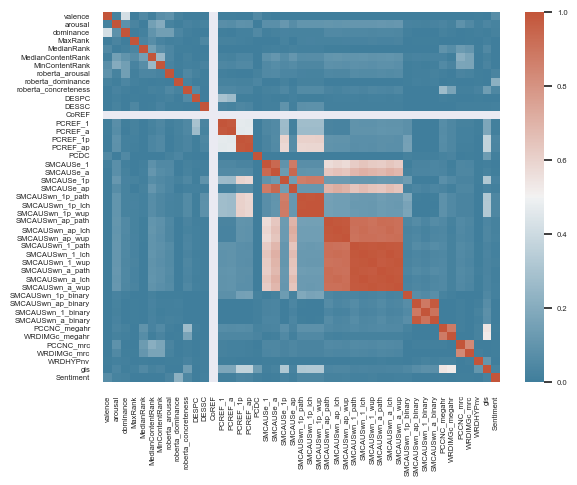

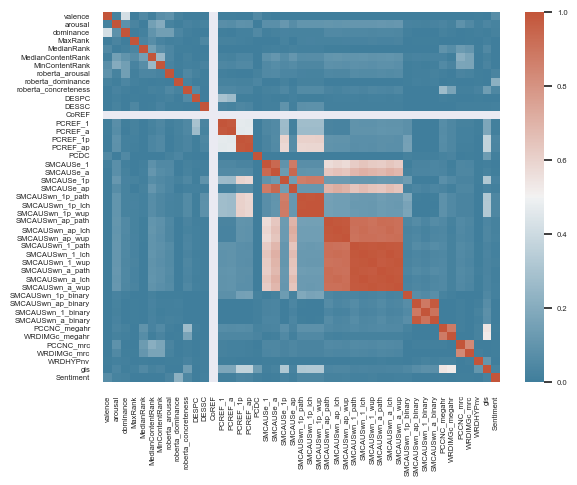

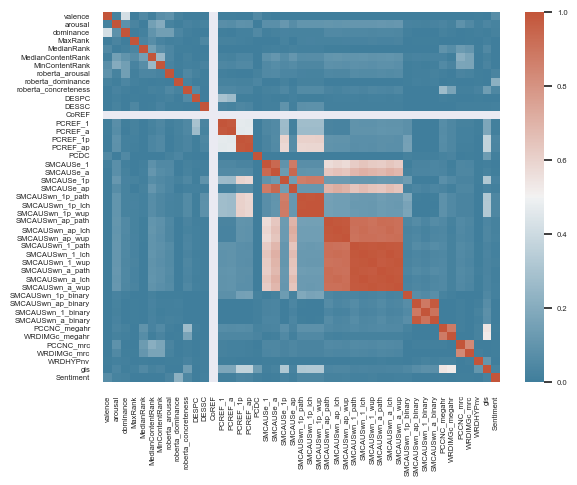

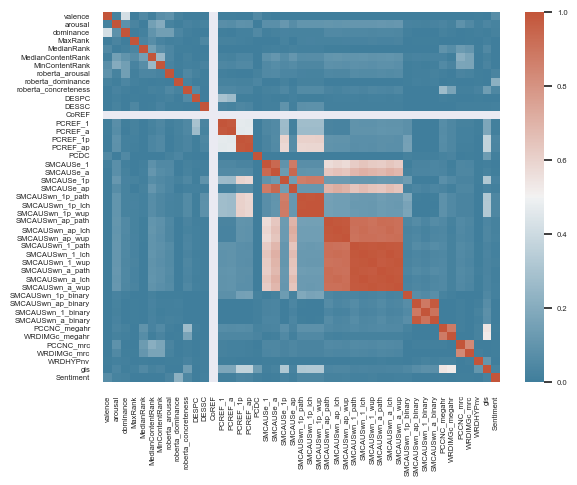

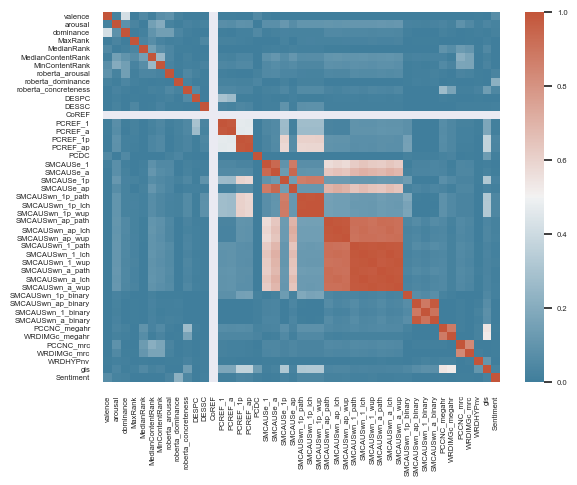

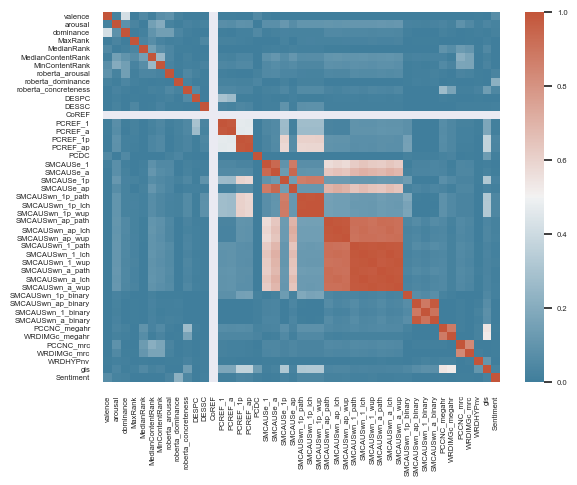

In [460]:
for i in range(6):
    alpha = covidRumor[covidRumor["label"] == "F"].reset_index(drop = True)[contentTopics[0][i]]
    beta = constraintAAAI[constraintAAAI["label"] == "fake"].reset_index(drop = True)[contentTopics[2][i]]
    getHeatMap( pd.concat([getParameters(alpha), getParameters(beta)]) )


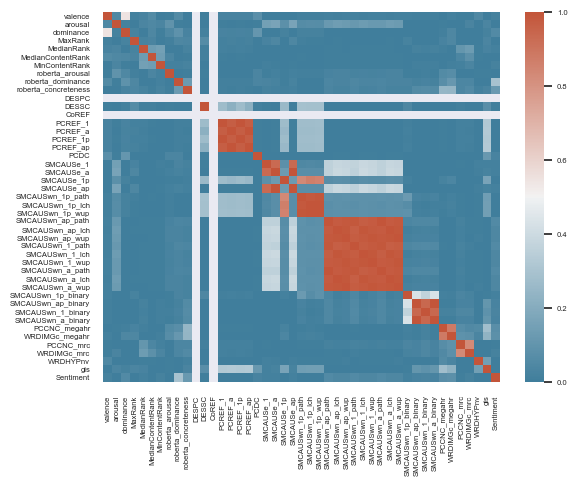

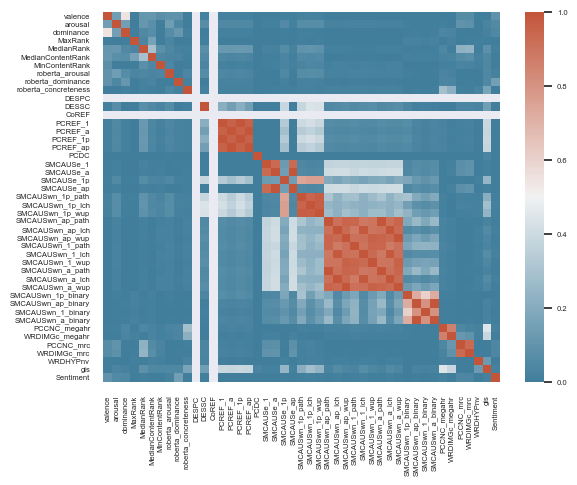

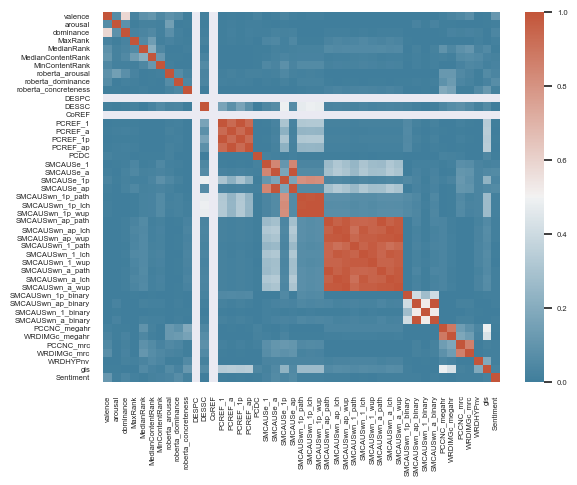

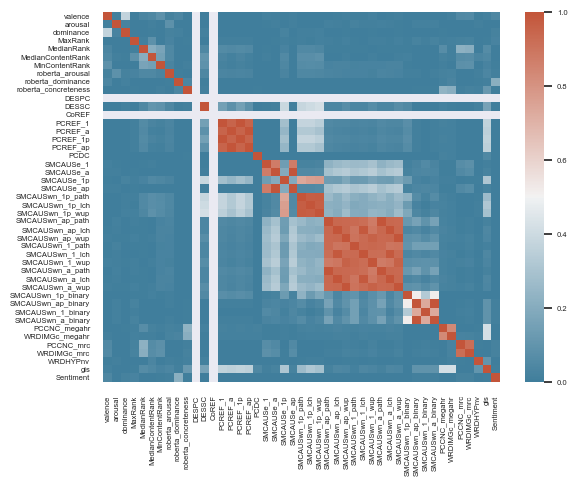

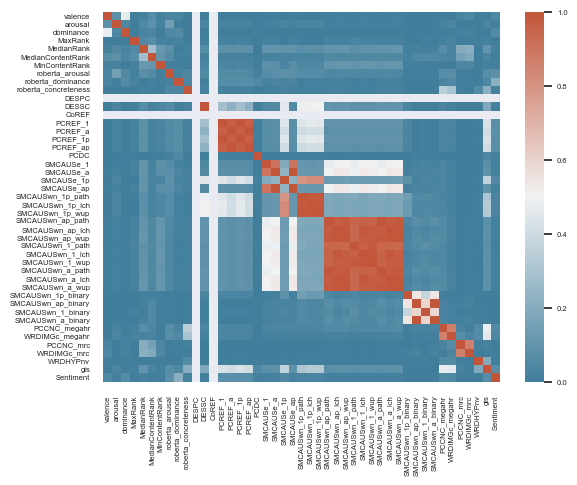

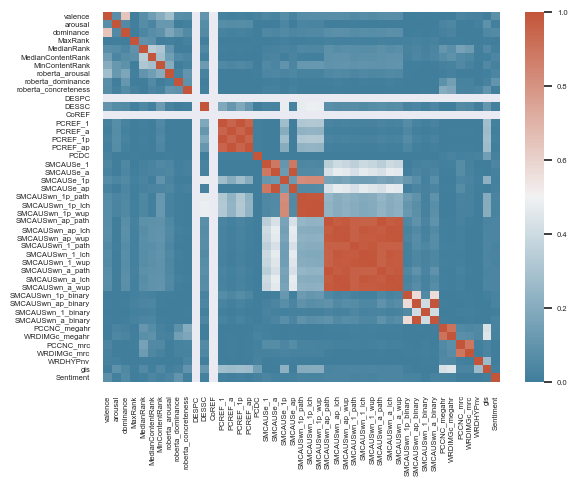

In [463]:
for i in range(6):
    alpha = covidRumor[covidRumor["label"] == "T"].reset_index(drop = True)[contentTopics[1][i]]
    beta = constraintAAAI[constraintAAAI["label"] == "real"].reset_index(drop = True)[contentTopics[3][i]]
    getHeatMap( pd.concat([getParameters(alpha), getParameters(beta)]) )


In [507]:
#fake vs official communication

i = 5



alpha = getParameters(covidRumor[covidRumor["label"] == "F"].reset_index(drop = True)[contentTopics[0][i]])
alpha.reset_index(drop = True, inplace = True)
alpha = labelThisAs(alpha, "fake")

beta = getParameters(constraintAAAI[constraintAAAI["label"] == "fake"].reset_index(drop = True)[contentTopics[2][i]])
beta.reset_index(drop = True, inplace = True)
beta = labelThisAs(beta, "fake")

gamma = labelThisAs(getParameters(offComm[contentTopics[4][i]]).reset_index(drop = True),"offComm")


final = pd.concat([alpha,beta,gamma]).dropna()
final
finalY = final["label"]
finalX = final.drop(columns = ["label"])
getFeatureGini(finalX, finalY)[0:10]

feature      gain
16                 DESSC  0.011418
19               PCREF_a  0.010389
18               PCREF_1  0.010389
10     MedianContentRank  0.009052
11        MinContentRank  0.007541
3            sentiment_4  0.007072
0            sentiment_1  0.006053
4            sentiment_5  0.005718
9             MedianRank  0.004770
14  roberta_concreteness  0.004551

In [517]:
#fake vs non-fake

#fake vs official communication

i = 5



alpha = getParameters(covidRumor[covidRumor["label"] == "F"].reset_index(drop = True)[contentTopics[0][i]])
alpha.reset_index(drop = True, inplace = True)
alpha = labelThisAs(alpha, "fake")

gamma = getParameters(covidRumor[covidRumor["label"] == "T"].reset_index(drop = True)[contentTopics[1][i]])
gamma.reset_index(drop = True, inplace = True)
gamma = labelThisAs(gamma, "non-fake")

beta = getParameters(constraintAAAI[constraintAAAI["label"] == "fake"].reset_index(drop = True)[contentTopics[2][i]])
beta.reset_index(drop = True, inplace = True)
beta = labelThisAs(beta, "fake")

delta = getParameters(constraintAAAI[constraintAAAI["label"] == "real"].reset_index(drop = True)[contentTopics[3][i]])
delta.reset_index(drop = True, inplace = True)
delta = labelThisAs(delta, "non-fake")




final = pd.concat([alpha,beta,gamma]).dropna()
final
finalY = final["label"]
finalX = final.drop(columns = ["label"])
getFeatureGini(finalX, finalY)[0:10]

feature      gain
12    roberta_arousal  0.098027
6             arousal  0.078641
13  roberta_dominance  0.050900
34     SMCAUSwn_1_lch  0.048105
35     SMCAUSwn_1_wup  0.045212
32    SMCAUSwn_ap_wup  0.044623
38     SMCAUSwn_a_wup  0.038565
31    SMCAUSwn_ap_lch  0.037497
23          SMCAUSe_1  0.037053
24          SMCAUSe_a  0.037053

## Correlation Heatmap

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\ProgramData\Anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


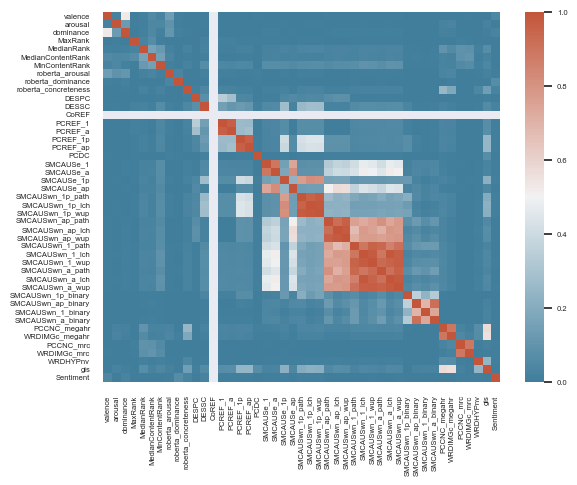

In [433]:
initDataset(includeLabel = True)
xy = pd.concat([a,c,f,g])

xy.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]] = np.log(xy.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]])
xy["Sentiment"] = 0.25*xy["sentiment_2"]+0.5*xy["sentiment_3"]+0.75*xy["sentiment_4"]+1*xy["sentiment_5"]
xy = xy.drop(columns = ["sentiment_" + str(i+1) for i in range(5)]).dropna()

Y = xy["label"]
X = xy.drop(columns = ["label"])


sns.set(font_scale=0.5)
heatmap(np.power(X.corr(),2), cmap = sns.diverging_palette(230, 20, as_cmap=True), vmax = 1, vmin = 0)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\ProgramData\Anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


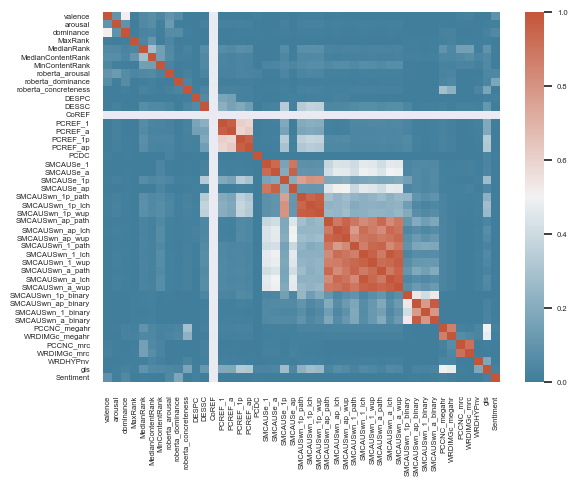

In [438]:
initDataset(includeLabel = True)
xy = pd.concat([b,d,h])

xy.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]] = np.log(xy.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]])
xy["Sentiment"] = 0.25*xy["sentiment_2"]+0.5*xy["sentiment_3"]+0.75*xy["sentiment_4"]+1*xy["sentiment_5"]
xy = xy.drop(columns = ["sentiment_" + str(i+1) for i in range(5)]).dropna()

Y = xy["label"]
X = xy.drop(columns = ["label"])


sns.set(font_scale=0.5)
heatmap(np.power(X.corr(),2), cmap = sns.diverging_palette(230, 20, as_cmap=True), vmax = 1, vmin = 0)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\ProgramData\Anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


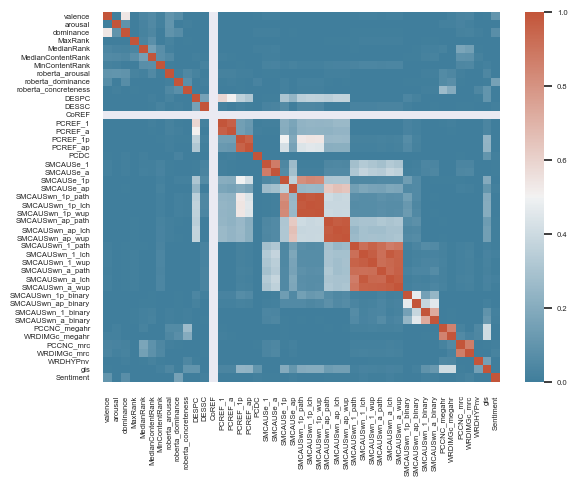

In [446]:
initDataset(includeLabel = True)
xy = pd.concat([e])

xy.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]] = np.log(xy.loc[:,["MaxRank", "MedianRank", "MedianContentRank", "MinContentRank"]])
xy["Sentiment"] = 0.25*xy["sentiment_2"]+0.5*xy["sentiment_3"]+0.75*xy["sentiment_4"]+1*xy["sentiment_5"]
xy = xy.drop(columns = ["sentiment_" + str(i+1) for i in range(5)]).dropna()

Y = xy["label"]
X = xy.drop(columns = ["label"])


sns.set(font_scale=0.5)
heatmap(np.power(X.corr(),2), cmap = sns.diverging_palette(230, 20, as_cmap=True), vmax = 1, vmin = 0)
plt.show()

In [444]:
pd.read_csv("data/preprocessed/officalComm.csv")["MaxRank"]

0         54153
1        101623
2         65780
3          6465
4         42942
          ...  
25176    137020
25177      8262
25178    101397
25179     67825
25180     19021
Name: MaxRank, Length: 25181, dtype: int64

In [338]:
#TF-IDF
tfidfvec = TfidfVectorizer(min_df = 0.005, max_df = 0.5)
result = tfidf.fit_transform(Z0)
tfidftransform = TfidfTransformer()
tfidfResult = tfidftransform.fit_transform(result).toarray()

nDimension = len(tfidfResult[0]) - 10

tikl = KLTransform(tfidfResult,nDimension)

n_clusters = 10

kmeansKL = KMeans(n_clusters = n_clusters, max_iter = 800, random_state = 928)
clust = kmeansKL.fit_predict(tikl)

np.random.seed(928)
for k in range(n_clusters):
    print("=============")
    print("== Cluster" + str(k) + " ==")
    print("=============")
    count = 0
    until = 10
    while count < until:
        target = math.floor(np.random.random() * len(tr))
        if clust[target] == k:
            count += 1
            print([Y0[target],Z0[target][:100]])
            print()

== Cluster0 ==
['offComm', "Have you memorized the details of your prescriptions? You don't have to. Keep an up-to-date list of "]

['non-fake', 'As of today there are a total of 331146 active #COVID19 cases in India and 246216 samples were teste']

['offComm', 'There’s a lot of misinformation about #coronavirus doing the rounds on social media, and accounts pr']

['offComm', 'The number of new #COVID19 cases being reported globally continues to rise with almost 4 million new']

['non-fake', 'RT @icmrnirrh: #COVID19 #Pandemic increases the risk of perinatal anxiety depression &amp; #Domestic']

['offComm', 'All adults can now book their life-saving COVID-19 jab.\n\nIf you’re aged 18 or over, visit https://t.']

['non-fake', '#CoronaVirusUpdates #IndiaFightsCorona India sets a new record of 664949 tests #COVID19 in last 24 h']

['offComm', 'All adults can now book a life-saving COVID-19 vaccine.\n\nJoin the millions who have already had thei']

['offComm', 'Learn how you can stay safe f

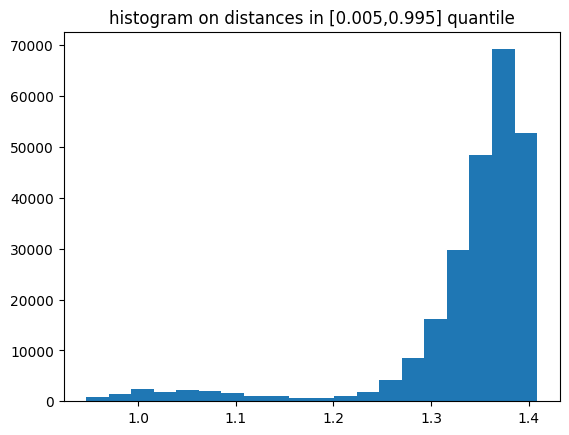

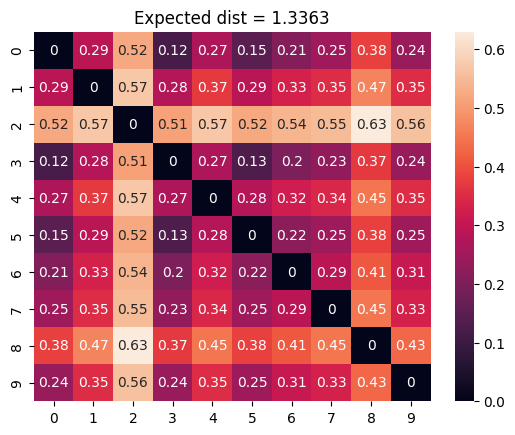

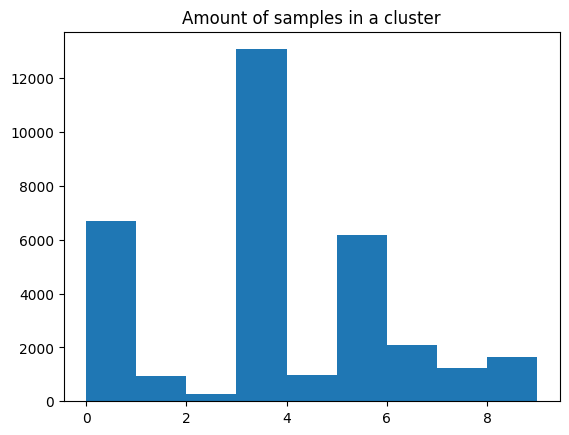

In [340]:
def showClusteringSummary(X,kmeans):
    
    
    # expected distance between 2 points
    np.random.seed(928)
    nSample = 500
    samples = X[np.random.choice(len(X),nSample, replace = False)]

    distMat = distance_matrix(samples, samples)
    expDist = np.sum(distMat.flatten()) / (nSample*(nSample - 1))

    visualLB = np.quantile(distMat.flatten(), 0.005)
    visualUB = np.quantile(distMat.flatten(), 0.995)

    plt.hist(distMat.flatten(), range = (visualLB,visualUB), bins = 20)
    plt.title("histogram on distances in [0.005,0.995] quantile")
    plt.show()
    
    heatmap(np.round(distance_matrix(kmeansKL.cluster_centers_,kmeansKL.cluster_centers_),2), annot=True)
    plt.title("Expected dist = " + str(round(expDist, 4)))
    plt.show()
    
    kmeansPrediction = kmeans.predict(X)
    
    plt.hist(kmeansPrediction, bins = [i for i in range(len(kmeans.cluster_centers_))])
    plt.title("Amount of samples in a cluster")
    
    
# tikl tr
showClusteringSummary(tikl, kmeansKL)

In [224]:
kmeansKL.fit_predict(tikl)

array([1, 3, 1, ..., 3, 3, 3])

In [479]:
pd.concat(
    [
        pd.DataFrame(covidRumor[covidRumor["label"] == "F"]["content"].to_list(), columns = ["text"]),
        pd.DataFrame(covidRumor[covidRumor["label"] == "T"]["content"].to_list(), columns = ["text"]),
        pd.DataFrame(constraintAAAI[constraintAAAI["label"] == "fake"]["tweet"].to_list(), columns = ["text"]),
        pd.DataFrame(constraintAAAI[constraintAAAI["label"] == "real"]["tweet"].to_list(), columns = ["text"]),
        pd.DataFrame(offComm["rawContent"].to_list(), columns = ["text"]),
    ]
)


text
0      If you can hold your breath without coughing, ...
1      A homemade hand sanitizer made with Tito's Vod...
2      Gargling with salt water or Vinegar 'eliminate...
3      Chinese officials are seeking approval to star...
4      U.S. House Speaker Nancy Pelosi held up a coro...
...                                                  ...
25176  What does it mean when #polio virus is detecte...
25177  If you plan to attend the @FIFAWorldCup in #Qa...
25178  Second round of public hearings towards a #Pan...
25179  This year, #WorldRabiesDay, let us bring toget...
25180  🔴LIVE NOW - The second round of public hearing...

[33181 rows x 1 columns]

In [232]:
["DESPC", "DESSC", "CoREF", "PCREF_1", "PCREF_a", "PCREF_1p", "PCREF_ap", "PCDC", "SMCAUSe_1", "SMCAUSe_a", "SMCAUSe_1p", "SMCAUSe_ap", "SMCAUSwn_1p_path", "SMCAUSwn_1p_lch", "SMCAUSwn_1p_wup", "SMCAUSwn_ap_path", "SMCAUSwn_ap_lch", "SMCAUSwn_ap_wup", "SMCAUSwn_1_path", "SMCAUSwn_1_lch", "SMCAUSwn_1_wup", "SMCAUSwn_a_path", "SMCAUSwn_a_lch", "SMCAUSwn_a_wup", "SMCAUSwn_1p_binary", "SMCAUSwn_ap_binary", "SMCAUSwn_1_binary", "SMCAUSwn_a_binary", "PCCNC_megahr", "WRDIMGc_megahr", "PCCNC_mrc", "WRDIMGc_mrc", "WRDHYPn",]


listPrincipleComponent(getParameters(offComm))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
C:\Users\chun_\AppData\Local\Temp\ipykernel_15924\4191767599.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["Sentiment"] = 0.25*x["sentiment_2"]+0.5*x["sentiment_3"]+0.75*x["sentiment_4"]+1*x["sentiment_5"]


NameError: name 'xTrain' is not defined

In [35]:
listPrincipleComponent(getParameters(covidRumor[covidRumor["label"] == "F"]))

0       1       2       3       4       5       6   \
% Explained Var       0.9758  0.0218  0.0015  0.0002  0.0002  0.0001  0.0001   
valence               0.0010  0.0022 -0.0148 -0.2201  0.0098 -0.3553  0.1545   
arousal               0.0001 -0.0006  0.0163  0.1092 -0.0046  0.0706 -0.0227   
dominance             0.0001  0.0044 -0.0117 -0.1075 -0.0237 -0.2756  0.1324   
MaxRank              -0.0004 -0.0006  0.0013  0.0400 -0.5344  0.4204 -0.4665   
MedianRank           -0.0040  0.0032  0.1182  0.4999 -0.5333 -0.3795  0.0023   
MedianContentRank    -0.0013 -0.0047  0.0817  0.3070 -0.1754  0.1121 -0.0149   
MinContentRank       -0.0028 -0.0034  0.1441  0.6252  0.1837 -0.0122  0.4329   
roberta_arousal      -0.0000 -0.0004  0.0016  0.0114 -0.0074  0.0124 -0.0225   
roberta_dominance    -0.0001 -0.0003 -0.0017 -0.0006  0.0024 -0.0021 -0.0004   
roberta_concreteness  0.0000 -0.0016  0.0236 -0.0013 -0.0208  0.0103 -0.0182   
DESPC                 0.0000 -0.0000  0.0000  0.0000  0.0000 -0.0000 -0.0000   
DESSC                 0.0002  0.0035 -0.0756 -0.1578 -0.2771  0.5141  0.6726   
CoREF                 0.0000  0.0000  0.0000 -0.0000  0.0000  0.0000  0.0000   
PCREF_1              -0.0000  0.0004 -0.0124 -0.0120 -0.0250  0.0432  0.0437   
PCREF_a              -0.0000  0.0003 -0.0119 -0.0109 -0.0232  0.0401  0.0384   
PCREF_1p             -0.0000  0.0004 -0.0124 -0.0120 -0.0250  0.0432  0.0437   
PCREF_ap             -0.0000  0.0003 -0.0119 -0.0109 -0.0232  0.0401  0.0384   
PCDC                 -0.0000 -0.0010 -0.0255  0.0345  0.0117 -0.0253 -0.0013   
SMCAUSe_1            -0.0001 -0.0014 -0.0150 -0.0529 -0.0862 -0.0599  0.0443   
SMCAUSe_a            -0.0001 -0.0013 -0.0149 -0.0514 -0.0849 -0.0597  0.0436   
SMCAUSe_1p            0.0000  0.0003 -0.0152 -0.0176 -0.0384  0.0470  0.0669   
SMCAUSe_ap           -0.0001 -0.0013 -0.0149 -0.0514 -0.0849 -0.0597  0.0436   
SMCAUSwn_1p_path     -0.0000  0.0001 -0.0050 -0.0064 -0.0140  0.0163  0.0230   
SMCAUSwn_1p_lch      -0.0000  0.0005 -0.0427 -0.0523 -0.1134  0.1370  0.1883   
SMCAUSwn_1p_wup      -0.0000  0.0001 -0.0086 -0.0106 -0.0232  0.0278  0.0384   
SMCAUSwn_ap_path     -0.0001 -0.0006 -0.0055 -0.0212 -0.0333 -0.0260  0.0141   
SMCAUSwn_ap_lch      -0.0006 -0.0047 -0.0471 -0.1773 -0.2787 -0.2185  0.1145   
SMCAUSwn_ap_wup      -0.0001 -0.0009 -0.0094 -0.0356 -0.0561 -0.0438  0.0229   
SMCAUSwn_1_path      -0.0001 -0.0006 -0.0056 -0.0214 -0.0336 -0.0257  0.0144   
SMCAUSwn_1_lch       -0.0006 -0.0049 -0.0473 -0.1781 -0.2795 -0.2181  0.1160   
SMCAUSwn_1_wup       -0.0001 -0.0010 -0.0096 -0.0359 -0.0566 -0.0434  0.0234   
SMCAUSwn_a_path      -0.0001 -0.0006 -0.0055 -0.0212 -0.0333 -0.0260  0.0141   
SMCAUSwn_a_lch       -0.0006 -0.0047 -0.0471 -0.1773 -0.2787 -0.2185  0.1145   
SMCAUSwn_a_wup       -0.0001 -0.0009 -0.0094 -0.0356 -0.0561 -0.0438  0.0229   
SMCAUSwn_1p_binary    0.0000  0.0000 -0.0009 -0.0030 -0.0058  0.0058  0.0116   
SMCAUSwn_ap_binary    0.0001 -0.0003  0.0024 -0.0118 -0.0051 -0.0035  0.0130   
SMCAUSwn_1_binary     0.0001 -0.0003  0.0023 -0.0115 -0.0051 -0.0018  0.0130   
SMCAUSwn_a_binary     0.0001 -0.0003  0.0024 -0.0118 -0.0051 -0.0035  0.0130   
PCCNC_megahr          0.0003 -0.0016  0.0319 -0.0026 -0.0235  0.0122  0.0164   
WRDIMGc_megahr        0.0002 -0.0014  0.0267 -0.0036 -0.0228  0.0155  0.0158   
PCCNC_mrc             0.6760 -0.7365 -0.0199  0.0070  0.0005 -0.0006  0.0004   
WRDIMGc_mrc           0.7368  0.6759  0.0120  0.0009 -0.0036 -0.0017  0.0007   
WRDHYPnv              0.0002  0.0002  0.0318 -0.0138  0.0114  0.0319  0.0316   
gis                  -0.0057  0.0233 -0.9681  0.2301  0.0205 -0.0384 -0.0240   
Sentiment             0.0002 -0.0015  0.0041  0.0002  0.0091 -0.0256  0.0245   

                          7       8       9   ...      35      36      37  \
% Explained Var       0.0001  0.0001  0.0000  ...  0.0000  0.0000  0.0000   
valence              -0.5004  0.4501  0.0469  ... -0.0000  0.0000  0.0000   
arousal               0.1410 -0.11

0          1          2          3          4         5   \
0    277.810817   1.965590   3.286365   9.013917  10.064610  0.543747   
1    542.277681   1.728844  -2.471450   6.498331  11.998656 -1.058839   
2    469.838961  18.657898  -5.535126   7.416027  12.248381 -0.631573   
3    319.787543 -13.762557  -1.015061   5.991819  11.678389 -0.978040   
4    304.244795   4.519320  -4.373813   6.351948  12.388887 -1.095695   
..          ...        ...        ...        ...        ...       ...   
523  313.625872  -5.396335  -4.626334   7.965066   9.053018 -0.001220   
524  263.237117 -10.567396  -2.378652   7.030548   8.111287 -0.146553   
525  334.017152  -9.707370   0.843400  10.062694  11.739214 -1.625044   
526  289.436163  -7.226997 -11.519735   8.672901  10.723569  0.448535   
527  304.434811  -9.161554  -2.129804   8.384958   9.714370 -0.036687   

           6         7          8         9   ...        35        36  \
0   -0.228774  2.885295  11.438137  3.824379  ...  2.877503 -0.114528   
1    0.839109  4.035116  10.690625  3.507646  ...  2.877503 -0.114528   
2    1.233479  4.346564  11.323395  2.988867  ...  2.877503 -0.114528   
3    0.657659  4.222587  10.513145  3.225317  ...  2.877503 -0.114528   
4    1.176503  4.220775   9.320076  2.673530  ...  2.877503 -0.114528   
..        ...       ...        ...       ...  ...       ...       ...   
523  1.955711  4.629614  10.294333  2.343729  ...  2.877503 -0.114528   
524  1.777236  4.496322   9.319892  3.630257  ...  2.877503 -0.114528   
525  1.827075  3.418605  10.289978  3.052657  ...  2.877503 -0.114528   
526  1.874256  4.254139  10.102685  1.565811  ...  2.877503 -0.114528   
527  1.659572  5.075992   9.955607  2.114296  ...  2.877503 -0.114528   

               37        38        39        40        41        42        43  \
0   -1.679128e-14 -0.006781 -0.005172  0.013927  0.328172  1.237056 -0.169486   
1   -1.679733e-14 -0.006781 -0.005172  0.013927  0.328172  1.237056 -0.169486   
2   -1.680096e-14 -0.006781 -0.005172  0.013927  0.328172  1.237056 -0.169486   
3   -1.679638e-14 -0.006781 -0.005172  0.013927  0.328172  1.237056 -0.169486   
4   -1.679146e-14 -0.006781 -0.005172  0.013927  0.328172  1.237056 -0.169486   
..            ...       ...       ...       ...       ...       ...       ...   
523 -1.679643e-14 -0.006781 -0.005172  0.013927  0.328172  1.237056 -0.169486   
524 -1.679387e-14 -0.006781 -0.005172  0.013927  0.328172  1.237056 -0.169486   
525 -1.680328e-14 -0.006781 -0.005172  0.013927  0.328172  1.237056 -0.169486   
526 -1.680201e-14 -0.006781 -0.005172  0.013927  0.328172  1.237056 -0.169486   
527 -1.680309e-14 -0.006781 -0.005172  0.013927  0.328172  1.237056 -0.169486   

           44  
0   -2.042569  
1   -2.042569  
2   -2.042569  
3   -2.042569  
4   -2.042569  
..        ...  
523 -2.042569  
524 -2.042569  
525 -2.042569  
526 -2.042569  
527 -2.042569  

[528 rows x 45 columns]

In [36]:
listPrincipleComponent(getParameters(covidRumor[covidRumor["label"] == "T"]))

0       1       2       3       4       5       6   \
% Explained Var       0.9726  0.0240  0.0023  0.0003  0.0002  0.0002  0.0001   
valence               0.0015  0.0016 -0.0096 -0.2170 -0.1400 -0.0524 -0.1667   
arousal               0.0003  0.0003  0.0141  0.0828  0.0252 -0.0064  0.0362   
dominance             0.0002  0.0014 -0.0108 -0.1243 -0.0723 -0.0508 -0.0565   
MaxRank              -0.0004  0.0044  0.0061  0.0498  0.2841 -0.2170 -0.2566   
MedianRank           -0.0057 -0.0010  0.1546  0.4882  0.3654 -0.4126 -0.4236   
MedianContentRank    -0.0032 -0.0060  0.0541  0.3281  0.2301 -0.0737  0.0819   
MinContentRank       -0.0031 -0.0061  0.0909  0.5338  0.1138  0.2641  0.6354   
roberta_arousal      -0.0001  0.0001  0.0018  0.0091 -0.0007 -0.0090  0.0015   
roberta_dominance    -0.0000  0.0002 -0.0009 -0.0016 -0.0018 -0.0058 -0.0023   
roberta_concreteness  0.0000 -0.0021  0.0214 -0.0006 -0.0033 -0.0285 -0.0155   
DESPC                 0.0000  0.0000 -0.0000 -0.0000 -0.0000  0.0000 -0.0000   
DESSC                 0.0021  0.0019 -0.1476 -0.1929  0.6293  0.6164 -0.2037   
CoREF                 0.0000  0.0000  0.0000 -0.0000  0.0000  0.0000 -0.0000   
PCREF_1               0.0001  0.0007 -0.0248 -0.0077  0.0423  0.0344 -0.0147   
PCREF_a               0.0001  0.0006 -0.0240 -0.0067  0.0395  0.0311 -0.0151   
PCREF_1p              0.0001  0.0007 -0.0248 -0.0077  0.0423  0.0344 -0.0147   
PCREF_ap              0.0001  0.0006 -0.0240 -0.0067  0.0395  0.0311 -0.0151   
PCDC                 -0.0001 -0.0002 -0.0152  0.0284 -0.0172 -0.0424  0.0102   
SMCAUSe_1            -0.0002 -0.0006 -0.0141 -0.0677  0.0758 -0.0873  0.0720   
SMCAUSe_a            -0.0002 -0.0006 -0.0141 -0.0649  0.0739 -0.0862  0.0718   
SMCAUSe_1p            0.0002  0.0001 -0.0292 -0.0272  0.0812  0.0308 -0.0040   
SMCAUSe_ap           -0.0002 -0.0006 -0.0141 -0.0649  0.0739 -0.0862  0.0718   
SMCAUSwn_1p_path      0.0001  0.0000 -0.0109 -0.0120  0.0307  0.0125  0.0018   
SMCAUSwn_1p_lch       0.0006  0.0002 -0.0918 -0.0978  0.2548  0.1026  0.0104   
SMCAUSwn_1p_wup       0.0001  0.0000 -0.0184 -0.0198  0.0514  0.0209  0.0023   
SMCAUSwn_ap_path     -0.0001 -0.0002 -0.0053 -0.0300  0.0311 -0.0339  0.0350   
SMCAUSwn_ap_lch      -0.0006 -0.0015 -0.0475 -0.2374  0.2447 -0.2912  0.2819   
SMCAUSwn_ap_wup      -0.0001 -0.0003 -0.0094 -0.0486  0.0500 -0.0579  0.0572   
SMCAUSwn_1_path      -0.0001 -0.0002 -0.0053 -0.0298  0.0308 -0.0343  0.0350   
SMCAUSwn_1_lch       -0.0006 -0.0017 -0.0479 -0.2367  0.2444 -0.2928  0.2827   
SMCAUSwn_1_wup       -0.0001 -0.0004 -0.0095 -0.0484  0.0499 -0.0583  0.0573   
SMCAUSwn_a_path      -0.0001 -0.0002 -0.0053 -0.0300  0.0311 -0.0339  0.0350   
SMCAUSwn_a_lch       -0.0006 -0.0015 -0.0475 -0.2374  0.2447 -0.2912  0.2819   
SMCAUSwn_a_wup       -0.0001 -0.0003 -0.0094 -0.0486  0.0500 -0.0579  0.0572   
SMCAUSwn_1p_binary    0.0000 -0.0002 -0.0016 -0.0073  0.0132  0.0084  0.0032   
SMCAUSwn_ap_binary    0.0000 -0.0004  0.0036 -0.0225  0.0137  0.0062  0.0139   
SMCAUSwn_1_binary     0.0000 -0.0003  0.0034 -0.0231  0.0135  0.0070  0.0120   
SMCAUSwn_a_binary     0.0000 -0.0004  0.0036 -0.0225  0.0137  0.0062  0.0139   
PCCNC_megahr          0.0002 -0.0027  0.0315  0.0029  0.0291  0.0023 -0.0171   
WRDIMGc_megahr        0.0002 -0.0022  0.0235 -0.0004  0.0277  0.0074 -0.0029   
PCCNC_mrc             0.6728 -0.7385 -0.0419  0.0105 -0.0031 -0.0063 -0.0055   
WRDIMGc_mrc           0.7397  0.6718  0.0373 -0.0009  0.0060  0.0004  0.0063   
WRDHYPnv              0.0001 -0.0016  0.0191 -0.0170  0.0154  0.0213 -0.0036   
gis                  -0.0023  0.0571 -0.9576  0.2332 -0.0812 -0.1050 -0.0183   
Sentiment             0.0003  0.0007 -0.0048 -0.0157 -0.0230 -0.0032  0.0006   

                          7       8       9   ...      35      36      37  \
% Explained Var       0.0001  0.0001  0.0001  ...  0.0000  0.0000  0.0000   
valence              -0.6858 -0.2798 -0.1447  ... -0.0000  0.0000 -0.0000   
arousal               0.1591  0.04

In [37]:
listPrincipleComponent(getParameters(covidRumor[covidRumor["label"] == "T"]))

0       1       2       3       4       5       6   \
% Explained Var       0.9726  0.0240  0.0023  0.0003  0.0002  0.0002  0.0001   
valence               0.0015  0.0016 -0.0096 -0.2170 -0.1400 -0.0524 -0.1667   
arousal               0.0003  0.0003  0.0141  0.0828  0.0252 -0.0064  0.0362   
dominance             0.0002  0.0014 -0.0108 -0.1243 -0.0723 -0.0508 -0.0565   
MaxRank              -0.0004  0.0044  0.0061  0.0498  0.2841 -0.2170 -0.2566   
MedianRank           -0.0057 -0.0010  0.1546  0.4882  0.3654 -0.4126 -0.4236   
MedianContentRank    -0.0032 -0.0060  0.0541  0.3281  0.2301 -0.0737  0.0819   
MinContentRank       -0.0031 -0.0061  0.0909  0.5338  0.1138  0.2641  0.6354   
roberta_arousal      -0.0001  0.0001  0.0018  0.0091 -0.0007 -0.0090  0.0015   
roberta_dominance    -0.0000  0.0002 -0.0009 -0.0016 -0.0018 -0.0058 -0.0023   
roberta_concreteness  0.0000 -0.0021  0.0214 -0.0006 -0.0033 -0.0285 -0.0155   
DESPC                 0.0000  0.0000 -0.0000 -0.0000 -0.0000  0.0000 -0.0000   
DESSC                 0.0021  0.0019 -0.1476 -0.1929  0.6293  0.6164 -0.2037   
CoREF                 0.0000  0.0000  0.0000 -0.0000  0.0000  0.0000 -0.0000   
PCREF_1               0.0001  0.0007 -0.0248 -0.0077  0.0423  0.0344 -0.0147   
PCREF_a               0.0001  0.0006 -0.0240 -0.0067  0.0395  0.0311 -0.0151   
PCREF_1p              0.0001  0.0007 -0.0248 -0.0077  0.0423  0.0344 -0.0147   
PCREF_ap              0.0001  0.0006 -0.0240 -0.0067  0.0395  0.0311 -0.0151   
PCDC                 -0.0001 -0.0002 -0.0152  0.0284 -0.0172 -0.0424  0.0102   
SMCAUSe_1            -0.0002 -0.0006 -0.0141 -0.0677  0.0758 -0.0873  0.0720   
SMCAUSe_a            -0.0002 -0.0006 -0.0141 -0.0649  0.0739 -0.0862  0.0718   
SMCAUSe_1p            0.0002  0.0001 -0.0292 -0.0272  0.0812  0.0308 -0.0040   
SMCAUSe_ap           -0.0002 -0.0006 -0.0141 -0.0649  0.0739 -0.0862  0.0718   
SMCAUSwn_1p_path      0.0001  0.0000 -0.0109 -0.0120  0.0307  0.0125  0.0018   
SMCAUSwn_1p_lch       0.0006  0.0002 -0.0918 -0.0978  0.2548  0.1026  0.0104   
SMCAUSwn_1p_wup       0.0001  0.0000 -0.0184 -0.0198  0.0514  0.0209  0.0023   
SMCAUSwn_ap_path     -0.0001 -0.0002 -0.0053 -0.0300  0.0311 -0.0339  0.0350   
SMCAUSwn_ap_lch      -0.0006 -0.0015 -0.0475 -0.2374  0.2447 -0.2912  0.2819   
SMCAUSwn_ap_wup      -0.0001 -0.0003 -0.0094 -0.0486  0.0500 -0.0579  0.0572   
SMCAUSwn_1_path      -0.0001 -0.0002 -0.0053 -0.0298  0.0308 -0.0343  0.0350   
SMCAUSwn_1_lch       -0.0006 -0.0017 -0.0479 -0.2367  0.2444 -0.2928  0.2827   
SMCAUSwn_1_wup       -0.0001 -0.0004 -0.0095 -0.0484  0.0499 -0.0583  0.0573   
SMCAUSwn_a_path      -0.0001 -0.0002 -0.0053 -0.0300  0.0311 -0.0339  0.0350   
SMCAUSwn_a_lch       -0.0006 -0.0015 -0.0475 -0.2374  0.2447 -0.2912  0.2819   
SMCAUSwn_a_wup       -0.0001 -0.0003 -0.0094 -0.0486  0.0500 -0.0579  0.0572   
SMCAUSwn_1p_binary    0.0000 -0.0002 -0.0016 -0.0073  0.0132  0.0084  0.0032   
SMCAUSwn_ap_binary    0.0000 -0.0004  0.0036 -0.0225  0.0137  0.0062  0.0139   
SMCAUSwn_1_binary     0.0000 -0.0003  0.0034 -0.0231  0.0135  0.0070  0.0120   
SMCAUSwn_a_binary     0.0000 -0.0004  0.0036 -0.0225  0.0137  0.0062  0.0139   
PCCNC_megahr          0.0002 -0.0027  0.0315  0.0029  0.0291  0.0023 -0.0171   
WRDIMGc_megahr        0.0002 -0.0022  0.0235 -0.0004  0.0277  0.0074 -0.0029   
PCCNC_mrc             0.6728 -0.7385 -0.0419  0.0105 -0.0031 -0.0063 -0.0055   
WRDIMGc_mrc           0.7397  0.6718  0.0373 -0.0009  0.0060  0.0004  0.0063   
WRDHYPnv              0.0001 -0.0016  0.0191 -0.0170  0.0154  0.0213 -0.0036   
gis                  -0.0023  0.0571 -0.9576  0.2332 -0.0812 -0.1050 -0.0183   
Sentiment             0.0003  0.0007 -0.0048 -0.0157 -0.0230 -0.0032  0.0006   

                          7       8       9   ...      35      36      37  \
% Explained Var       0.0001  0.0001  0.0001  ...  0.0000  0.0000  0.0000   
valence              -0.6858 -0.2798 -0.1447  ... -0.0000  0.0000 -0.0000   
arousal               0.1591  0.04

In [15]:
listPrincipleComponent(getParameters(constraintAAAI[constraintAAAI["label"] == "fake"]))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


0       1       2       3       4       5       6   \
% Explained Var       0.4313  0.1834  0.1245  0.1063  0.0565  0.0471  0.0308   
valence              -0.0966 -0.1263 -0.3432 -0.7253  0.1908 -0.0171  0.2308   
arousal               0.0588  0.0487  0.0647  0.1275  0.0830 -0.0540  0.9536   
dominance            -0.0525 -0.0868 -0.1984 -0.4620  0.0886  0.1118 -0.1207   
MaxRank               0.1568 -0.7128  0.5505 -0.2137 -0.3258  0.0934  0.0567   
MedianRank            0.7215 -0.2835 -0.5839  0.1907 -0.1473 -0.0087 -0.0034   
MedianContentRank     0.3803 -0.0873  0.3023  0.0217  0.8612  0.0334 -0.1128   
MinContentRank        0.5407  0.6136  0.3132 -0.3880 -0.2796  0.0620 -0.0010   
roberta_arousal       0.0062 -0.0040  0.0096  0.0148  0.0063 -0.0056  0.0256   
roberta_dominance    -0.0028 -0.0021 -0.0045 -0.0046 -0.0005  0.0031  0.0116   
roberta_concreteness -0.0478  0.0395 -0.0683  0.0895  0.0175  0.9835  0.0705   
Sentiment             0.0022 -0.0054 -0.0184 -0.0551  0.0290 -0.0564  0.0326   

                          7       8       9       10  
% Explained Var       0.0142  0.0053  0.0005  0.0002  
valence              -0.4826 -0.0890  0.0080 -0.0037  
arousal               0.2307 -0.0147 -0.0322  0.0065  
dominance             0.8374  0.0249 -0.0019 -0.0099  
MaxRank              -0.0215  0.0060 -0.0042  0.0014  
MedianRank           -0.0011  0.0005 -0.0018  0.0007  
MedianContentRank    -0.0129 -0.0141 -0.0051  0.0086  
MinContentRank       -0.0211 -0.0031  0.0048  0.0001  
roberta_arousal       0.0115 -0.0412  0.8672 -0.4951  
roberta_dominance     0.0069  0.0616  0.4968  0.8655  
roberta_concreteness -0.0903  0.0514  0.0025 -0.0088  
Sentiment            -0.0564  0.9914  0.0053 -0.0738

In [124]:
x

NameError: name 'x' is not defined

In [16]:
listPrincipleComponent(getParameters(constraintAAAI[constraintAAAI["label"] == "real"]))

0       1       2       3       4       5       6   \
% Explained Var       0.4026  0.2438  0.1413  0.0761  0.0592  0.0361  0.0210   
valence              -0.0978 -0.0677  0.0391 -0.5289  0.5541 -0.0428  0.2119   
arousal               0.0562  0.0431 -0.0729  0.1998 -0.1416  0.1268  0.9553   
dominance            -0.0558 -0.0175  0.0805 -0.3966  0.3973  0.0827  0.1402   
MaxRank               0.4578 -0.8556  0.1596 -0.1088 -0.1414 -0.0109  0.0270   
MedianRank            0.6881  0.3446 -0.4974 -0.3719 -0.1418  0.0174 -0.0396   
MedianContentRank     0.4058  0.0132 -0.0701  0.6035  0.6801  0.0082 -0.0563   
MinContentRank        0.3690  0.3765  0.8413 -0.0670 -0.0786 -0.0087  0.0291   
roberta_arousal       0.0071  0.0018  0.0014  0.0108 -0.0129  0.0011  0.0265   
roberta_dominance    -0.0021 -0.0015  0.0057 -0.0175  0.0152  0.0194  0.0025   
roberta_concreteness -0.0138 -0.0189  0.0220 -0.0133  0.0005  0.9865 -0.1243   
Sentiment            -0.0033 -0.0111  0.0230 -0.0591  0.0768  0.0347  0.0164   

                          7       8       9       10  
% Explained Var       0.0126  0.0069  0.0003  0.0002  
valence              -0.5624 -0.1855 -0.0013 -0.0118  
arousal               0.0006  0.0058 -0.0237  0.0181  
dominance             0.8007  0.0848 -0.0014 -0.0133  
MaxRank               0.0104 -0.0055 -0.0029  0.0018  
MedianRank           -0.0039  0.0059 -0.0015  0.0007  
MedianContentRank     0.0074 -0.0116  0.0021  0.0016  
MinContentRank       -0.0468 -0.0211 -0.0060  0.0016  
roberta_arousal       0.0007 -0.0142  0.8129 -0.5814  
roberta_dominance    -0.0138  0.0833  0.5806  0.8092  
roberta_concreteness -0.0853 -0.0520 -0.0080 -0.0142  
Sentiment            -0.1811  0.9736 -0.0383 -0.0796

In [101]:
#subspace entropy when calculating 2 class with 1 seperation

z = xy.reset_index()

for i in ["sentiment_1","sentiment_2","sentiment_3","sentiment_4","sentiment_5","valence","arousal","dominance","MaxRank","MedianRank","MedianContentRank","MinContentRank"]:
    
    maxEntr = -100
    arg = -1
    
    for j in range(len(z)):
        
        sep = z[i][j]
        lower = z[z[i] < sep]
        upper = z[z[i] >= sep]
        
        lenLower = len(lower)
        if lenLower == 0:
            lowerEntr = 0
        else:
            lenLowerP = (lower["label"] == "offComm").sum() / lenLower
            lenLowerN = (lower["label"] == "fake").sum() / lenLower
            if lenLowerP != 0:
                lenLowerP = - lenLowerP * math.log(lenLowerP,2)
            if lenLowerN != 0:
                lenLowerN = - lenLowerN * math.log(lenLowerN,2)
            lowerEntr = lenLowerP + lenLowerN
        
        
        
        lenUpper = len(upper)
        lenUpperP = (upper["label"] == "offComm").sum() / lenUpper
        lenUpperN = (upper["label"] == "fake").sum() / lenUpper
        
        if lenUpperP != 0:
            lenUpperP = - lenUpperP * math.log(lenUpperP,2)
        if lenUpperN != 0:
            lenUpperN = - lenUpperN * math.log(lenUpperN,2)
        upperEntr = lenUpperP + lenUpperN
        
        Entr = (lenLower/(lenLower + lenUpper)) * lowerEntr + (lenUpper/(lenLower + lenUpper)) * upperEntr
        
        if Entr > maxEntr:
            maxEntr = Entr
            arg = sep
            
    print(i)
    print(maxEntr)
    print(arg)



sentiment_1
0.5437960604343066
0.0011963834076942
sentiment_2
0.5437960604343066
0.0008356688135745
sentiment_3
0.5437960604343066
0.0024115236560731
sentiment_4
0.5437960604343066
0.0018563891641485
sentiment_5
0.5437960604343066
0.0013331742390447
valence
0.5437960604343066
1.71
arousal
0.5437960604343066
2.18
dominance
0.5437960604343066
2.66
MaxRank
0.5437960604343066
-1
MedianRank
0.5437960604343066
-1.0
MedianContentRank
0.5437960604343066
-1.0
MinContentRank
0.5437960604343066
27


In [99]:
(upper["label"] == "fake").sum()

0

In [135]:
xTrain

sentiment_1  sentiment_2  sentiment_3  sentiment_4  sentiment_5  \
1600     0.569119     0.189732     0.099721     0.062741     0.078687   
1410     0.501004     0.214722     0.167296     0.067090     0.049888   
774      0.127176     0.129196     0.196558     0.327465     0.219604   
1927     0.299728     0.214784     0.135446     0.160380     0.189662   
2290     0.076907     0.250910     0.439583     0.196300     0.036300   
...           ...          ...          ...          ...          ...   
2928     0.425218     0.276032     0.123778     0.099071     0.075900   
115      0.041674     0.052841     0.125792     0.362537     0.417155   
85       0.217784     0.374003     0.331604     0.062704     0.013905   
963      0.615331     0.180863     0.080688     0.040840     0.082278   
604      0.474841     0.214429     0.156445     0.093632     0.060653   

       valence   arousal  dominance  MaxRank  MedianRank  MedianContentRank  \
1600  5.383333  3.990667   5.594000   202074      1467.0             3397.0   
1410  5.945333  3.966667   5.926667     9529        48.0              315.0   
774   5.355714  4.067143   5.790000    65780       278.5              868.0   
1927  3.230000  5.795000   4.525000    65780      8666.5             8871.0   
2290  4.939000  4.543000   5.414000    56642       548.0             1093.0   
...        ...       ...        ...      ...         ...                ...   
2928  6.651429  4.174286   5.844286    31610       328.0             1135.0   
115   5.567000  4.240000   5.409000    20109       682.5              950.0   
85    5.955000  5.035000   5.153333    65780       164.5              426.0   
963   5.775455  3.954545   5.620909   107006       517.0             1780.0   
604   5.303333  4.043333   5.413333    78082      4240.5             5740.0   

      MinContentRank  
1600              27  
1410              27  
774              156  
1927            8462  
2290             208  
...              ...  
2928             328  
115               45  
85                27  
963              113  
604              268  

[6400 rows x 12 columns]

In [108]:
xTrain.columns.tolist()

['sentiment_1',
 'sentiment_2',
 'sentiment_3',
 'sentiment_4',
 'sentiment_5',
 'valence',
 'arousal',
 'dominance',
 'MaxRank',
 'MedianRank',
 'MedianContentRank',
 'MinContentRank']

In [73]:
labelThisAs(getParameters(offComm), "true")

sentiment_1  sentiment_2  sentiment_3  sentiment_4  sentiment_5  \
0         0.302196     0.313120     0.196645     0.113740     0.074299   
1         0.088130     0.056196     0.083003     0.278266     0.494405   
2         0.055805     0.048949     0.128341     0.366148     0.400757   
3         0.176424     0.142939     0.170209     0.225259     0.285168   
4         0.207286     0.210703     0.213085     0.218432     0.150494   
...            ...          ...          ...          ...          ...   
25176     0.234689     0.203917     0.211210     0.200133     0.150052   
25177     0.053122     0.052240     0.138787     0.333172     0.422679   
25178     0.308450     0.176972     0.140037     0.189355     0.185186   
25179     0.031684     0.018310     0.033095     0.165794     0.751118   
25180     0.076409     0.077917     0.152728     0.353560     0.339386   

        valence   arousal  dominance  MaxRank  MedianRank  MedianContentRank  \
0      5.578462  4.228462   5.531538    54153       511.0             2981.5   
1      5.795000  4.690000   5.812727   101623       234.0              532.0   
2      5.848000  4.069000   5.778000    65780        76.0             2167.0   
3      6.276875  4.078750   5.528125     6465       145.0             1455.0   
4      5.657000  4.010000   5.596500    42942       349.0             1286.0   
...         ...       ...        ...      ...         ...                ...   
25176  3.645556  4.727778   4.325556   137020        68.0             5627.0   
25177  6.130000  3.615000   6.308333     8262       112.5              716.0   
25178  5.915000  3.490000   5.616000   101397       486.0              957.5   
25179  5.240625  4.200625   5.226875    67825       121.0              849.0   
25180  6.194000  3.807000   5.543000    19021       215.0             1309.0   

       MinContentRank  
0                  64  
1                  50  
2                  76  
3                  33  
4                 115  
...               ...  
25176             139  
25177             132  
25178             105  
25179              35  
25180              27  

[25181 rows x 12 columns]

(array([  55.,  209.,  462.,  614.,  802., 1248., 1510., 1796., 1672.,
         437.]),
 array([0.02611496, 0.12141342, 0.21671189, 0.31201035, 0.40730881,
        0.50260727, 0.59790573, 0.69320419, 0.78850265, 0.88380111,
        0.97909957]),
 <BarContainer object of 10 artists>)

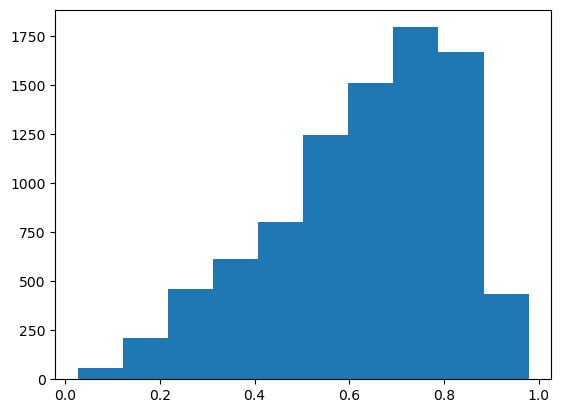

In [7]:
plt.hist(0.25*offComm["sentiment_2"]+0.5*offComm["sentiment_3"]+0.75*offComm["sentiment_4"]+1*offComm["sentiment_5"])

# sentiment in [0,1]

(array([ 972., 1287., 1682., 1564., 1327.,  973.,  583.,  314.,   89.,
          14.]),
 array([0.00239865, 0.09775322, 0.19310779, 0.28846236, 0.38381693,
        0.47917151, 0.57452608, 0.66988065, 0.76523522, 0.86058979,
        0.95594436]),
 <BarContainer object of 10 artists>)

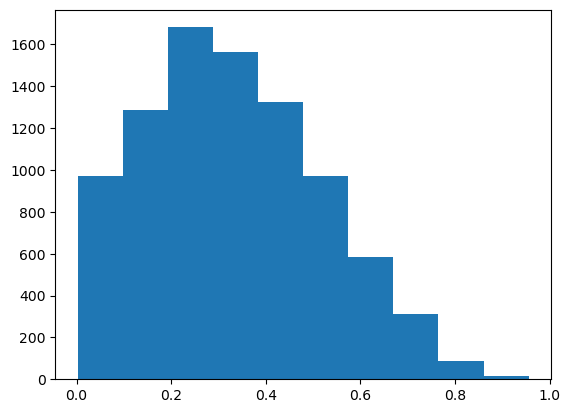

In [12]:
plt.hist(offComm["sentiment_5"])

In [ ]:
tweets

In [ ]:
tweetsValence = []
for i in range(len(tweets)):
    tweetsValence.append(valence(lemma(stopword(tk(tweets["tweet"][i]))))) 
tweetsValence = pd.DataFrame(tweetsValence, columns = ["valence"])
    
tweetsArousal = []
for i in range(len(tweets)):
    tweetsArousal.append(arousal(lemma(stopword(tk(tweets["tweet"][i]))))) 
tweetsArousal = pd.DataFrame(tweetsArousal, columns = ["arousal"])

In [ ]:
tweets2 = pd.concat([tweets,tweetsValence,tweetsArousal], axis = 1)
tweetReal = tweets2[[tweets2["label"][i] == "real" for i in range(len(tweets))]]
tweetFake = tweets2[[tweets2["label"][i] == "fake" for i in range(len(tweets))]]
tweets2
# print(len(tweetReal)) # 3360
# print(len(tweetFake)) # 3060

In [ ]:
bins = [i/10 for i in range(91)]
plt.hist(tweetReal["valence"], alpha=0.5, label="real", bins = bins)
plt.hist(tweetFake["valence"], alpha=0.5, label="fake", bins = bins)
plt.legend(loc='upper right')
plt.show()

#check variance
print(variance(tweetReal["valence"]))
print(variance(tweetFake["valence"]))

In [ ]:
F.cdf(variance(tweetReal["valence"])/variance(tweetFake["valence"]) ,len(tweetReal) - 1,len(tweetFake) - 1)

In [ ]:
F.cdf(variance(tweetReal["arousal"])/variance(tweetFake["arousal"]) ,len(tweetReal) - 1,len(tweetFake) - 1)

In [ ]:
bins = [i/10 for i in range(91)]
plt.hist(tweetReal["arousal"], alpha=0.5, label="real", bins = bins)
plt.hist(tweetFake["arousal"], alpha=0.5, label="fake", bins = bins)
plt.legend(loc='upper right')
plt.show()
#check variance

In [ ]:

arousal(lemma(stopword(tk(tweets["tweet"][6]))))

In [ ]:
# Authentication variables

keyFile = open("AuthSecret.txt","r")
keyFile.readline()
bearer_token = keyFile.readline()[:-1]
keyFile.readline()
keyFile.readline()
api_key = keyFile.readline()[:-1]
keyFile.readline()
keyFile.readline()
api_secret = keyFile.readline()[:-1]
keyFile.readline()
keyFile.readline()
access_token = keyFile.readline()[:-1]
keyFile.readline()
keyFile.readline()
access_secret = keyFile.readline()[:-1]
keyFile.close()

In [ ]:
bearer_token = bearer_token
api_key = api_key
api_secret = api_secret
access_token = access_token
access_secret = access_secret
 
# Authenticate to Twitter
auth = tweepy.OAuthHandler(api_key,api_secrets)
auth.set_access_token(access_token,access_secret)
 
client = tweepy.Client(bearer_token, api_key, api_secret, access_token, access_secret)

api = tweepy.API(auth)
 
try:
    api.verify_credentials()
    print('Successful Authentication')
except:
    print('Failed authentication')

In [ ]:
### TREASURE THE READ AMOUNT YOU HAVE
# WHOTweet = client.get_tweet(1663666846828994561)


# myTweet = api.get_status(1663487962083098629) #tweet from myself
# Forbidden: 403 Forbidden
# You currently have access to Twitter API v2 endpoints and limited v1.1 endpoints only. 
# If you need access to this endpoint, you may need a different access level. 
# You can learn more here: https://developer.twitter.com/en/docs/twitter-api/getting-started/about-twitter-api#v2-access-leve


# myTweet = client.get_tweets(ids=1663487962083098629)
# Forbidden: 403 Forbidden
# When authenticating requests to the Twitter API v2 endpoints, 
# you must use keys and tokens from a Twitter developer App that is attached to a Project. 
# You can create a project via the developer portal.


# client.create_tweet(text = "This is a test tweet made from the API. RTDTYDRY")
# work

In [ ]:
 analyzer = SentimentIntensityAnalyzer()
# for sentence in sentences:
#     vs = analyzer.polarity_scores(sentence)
#     print("{:-<65} {}".format(sentence, str(vs)))

analyzer.polarity_scores(tweets["tweet"][0])

In [ ]:
#SNScrape
tweet = sntwitter.TwitterTweetScraper(1667120797142401026)
for i in tweet.get_items():
    print(i.rawContent)

In [2]:
#Offical Communication, Trial 1
# Blocked
tweets = sntwitter.TwitterSearchScraper("(from:WHO) until:2021-03-31 since:2021-03-01 -filter:replies")
for i in tweets.get_items():
    print(i.rawContent)

Acompanhe ao vivo nossa sessão virtual de perguntas e respostas sobre #COVID19. Tire suas dúvidas! #PergunteParaOMS https://t.co/p32vkq9PIV
The report of the international expert team studying the #COVID19 virus origins in a Wuhan field visit was published today: https://t.co/iTO4vtJ8iV

@DrTedros calls for further studies, data on the virus origins &amp; reiterates that all hypotheses remain open https://t.co/DXF9Vyv3eG
Press briefing by the international team studying the origins of the #COVID19 virus https://t.co/aH27YG8kGD
Participe deste #COVID19 evento ao vivo: 
Hoje, 30 de março, às 13:30, hora de Brasília

Participe! Faça suas perguntas! #AskWHO ⬇️ https://t.co/73M05ySdqZ
The 🔟-year conflict has put a strain on all Syrians, especially on the most vulnerable populations.

Given the fragility of the situation, health system capacity is likely to fall short in response to #COVID19.

#Syria10

https://t.co/8TlbqTUOxn
What is the role of communities in early disease detection, readi

It's #SaltAwarenessWeek!

Too much salt can ↗️ blood pressure, which is a leading risk factor for ❤️ disease &amp; stroke. An estimated 2.5 MILLION deaths could be prevented per year if everyone ↘️ their 🧂 consumption to the recommended limit of 5g / day.

👉 https://t.co/momSIK0Bt4 https://t.co/LTODi9Sj4G
LIVE Q&amp;A on violence against women in time of #COVID19. #AskWHO https://t.co/OOhcFdblTc
LIVE with @DrTedros at the #AHAIC2021 Award Ceremony https://t.co/zCsHMfcfWF
If you already got your #COVID19 vaccine, are you wondering when the immunity kicks in and how long it lasts?
Can you still catch COVID-19 and can you infect others?
How long do you need to take precautions after vaccination?

Dr @Kate_L_OBrien answers in #ScienceIn5 https://t.co/YAg5TBjZYg
Viruses constantly change, and new variants are expected.

Follow this thread to learn more about the effects of virus variants on #COVID19 vaccines 👇 https://t.co/kj1duaAnsd
🆕data shows that violence against women remains devastati

Stopping after 20 empty pages


In [49]:
#Offical Communication, Trial 1
# Blocked
tweets = sntwitter.TwitterSearchScraper("(from:WHO) until:2021-03-31 since:2021-03-01 -filter:replies")
for i in tweets.get_items():
    print(i.rawContent)

Acompanhe ao vivo nossa sessão virtual de perguntas e respostas sobre #COVID19. Tire suas dúvidas! #PergunteParaOMS https://t.co/p32vkq9PIV
The report of the international expert team studying the #COVID19 virus origins in a Wuhan field visit was published today: https://t.co/iTO4vtJ8iV

@DrTedros calls for further studies, data on the virus origins &amp; reiterates that all hypotheses remain open https://t.co/DXF9Vyv3eG
Press briefing by the international team studying the origins of the #COVID19 virus https://t.co/aH27YG8kGD
Participe deste #COVID19 evento ao vivo: 
Hoje, 30 de março, às 13:30, hora de Brasília

Participe! Faça suas perguntas! #AskWHO ⬇️ https://t.co/73M05ySdqZ
The 🔟-year conflict has put a strain on all Syrians, especially on the most vulnerable populations.

Given the fragility of the situation, health system capacity is likely to fall short in response to #COVID19.

#Syria10

https://t.co/8TlbqTUOxn
What is the role of communities in early disease detection, readi

It's #SaltAwarenessWeek!

Too much salt can ↗️ blood pressure, which is a leading risk factor for ❤️ disease &amp; stroke. An estimated 2.5 MILLION deaths could be prevented per year if everyone ↘️ their 🧂 consumption to the recommended limit of 5g / day.

👉 https://t.co/momSIK0Bt4 https://t.co/LTODi9Sj4G
LIVE Q&amp;A on violence against women in time of #COVID19. #AskWHO https://t.co/OOhcFdblTc
LIVE with @DrTedros at the #AHAIC2021 Award Ceremony https://t.co/zCsHMfcfWF
If you already got your #COVID19 vaccine, are you wondering when the immunity kicks in and how long it lasts?
Can you still catch COVID-19 and can you infect others?
How long do you need to take precautions after vaccination?

Dr @Kate_L_OBrien answers in #ScienceIn5 https://t.co/YAg5TBjZYg
Viruses constantly change, and new variants are expected.

Follow this thread to learn more about the effects of virus variants on #COVID19 vaccines 👇 https://t.co/kj1duaAnsd
🆕data shows that violence against women remains devastati

Stopping after 20 empty pages


In [ ]:
tweets = sntwitter.TwitterUserScraper("WHO")
for i in tweets.get_items():
    print(i.rawContent)

In [ ]:
tweets = sntwitter.TwitterHashtagScraper("COVID")
for i in tweets.get_items():
    print(i.rawContent)

In [20]:
covidTweets = pd.read_csv("corona_tweets_xi.csv",header=None)[0].to_list()

In [7]:
#SNScrape
for tweetId in covidTweets:
    tweet = sntwitter.TwitterTweetScraper(tweetId)
    if type(i) == type(sntwitter.Tombstone(0)):
        continue
    for i in tweet.get_items():
        print(i.rawContent)

NameError: name 'covidTweets' is not defined

In [80]:
# fetchOfficialCommunication("WHO") #Done
# fetchOfficialCommunication("NHSEngland") #Done
# fetchOfficialCommunication("NHSuk") #Done
# fetchOfficialCommunication("UNICEF") #Done
# fetchOfficialCommunication("UN") #Done

Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping a

In [85]:
autoFake = pd.read_csv("001.csv", sep = ";")


C:\Users\chun_\AppData\Local\Temp\ipykernel_14596\3026015407.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  autoFake = pd.read_csv("001.csv", sep = ";")


(array([1.0000e+00, 2.0000e+01, 8.2000e+01, 2.4900e+02, 4.2200e+02,
        1.5680e+03, 3.9100e+03, 1.0096e+04, 3.4344e+04, 4.9308e+04]),
 array([ 0. ,  9.2, 18.4, 27.6, 36.8, 46. , 55.2, 64.4, 73.6, 82.8, 92. ]),
 <BarContainer object of 10 artists>)

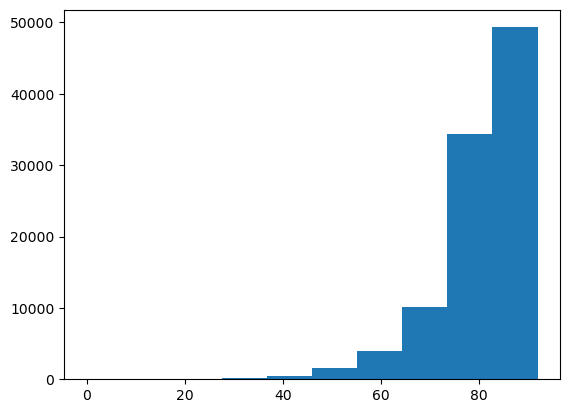

In [126]:
# autoFake
plt.hist(autoFake.sum(axis=1, numeric_only=True))



In [159]:
X = autoFake["TweetID"].to_list()
Y = autoFake.sum(axis=1, numeric_only=True).to_list()

[x for _, x in sorted(zip(Y, X))]

TypeError: '<' not supported between instances of 'str' and 'int'

In [169]:
targetHydrate = [x for _, x in sorted(zip(Y, X), key=lambda pair: pair[0])][0:10000]
directory = "../../../Documents/PS928Local/fakeNews/covid19fake/tweets/"
directoryIfFailed = "../../../Documents/PS928Local/fakeNews/covid19fake/failed/"
hydrateTweets(targetHydrate, directory , directoryIfFailed)

Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224616318130847744%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224616318130847744
Note: Tweets Deleted for1224529594843201536


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224694145861718016%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224694145861718016


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224694752794349568%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224694752794349568
KeyError: 1224694857245040640


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224695040791867392%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224695040791867392


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224695127001591808%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224695127001591808


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224695166130446336%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224695166130446336


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224695414302990336%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224695414302990336


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224695535371579392%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224695535371579392


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224697089591873536%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224697089591873536


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224697500512260096%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224697500512260096


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224697566702505984%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224697566702505984


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224698101581172736%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224698101581172736


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224698153485717504%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224698153485717504


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224699613766090752%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224699613766090752


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224561552424079360%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224561552424079360


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224630705327497216%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224630705327497216


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224630769575817216%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224630769575817216


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224630673845018624%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224630673845018624
Note: Tweets Deleted for1224633590144593920


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224636200071266304%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224636200071266304


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224675652827336704%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224675652827336704


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224676833024782336%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224676833024782336


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224691829691559936%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224691829691559936
Note: Tweets Deleted for1224520879100452864
Note: Tweets Deleted for1224522100347588608
Note: Tweets Deleted for1224524271906508800


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224525998068244480%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224525998068244480


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224529351632281600%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224529351632281600


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224531494577721344%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224531494577721344
Note: Tweets Deleted for1224541895667245056


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224567554397499392%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224567554397499392


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224570075039928320%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224570075039928320


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224590344433463296%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224590344433463296
Note: Tweets Deleted for1224596016801832960


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224596480104767488%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224596480104767488
Note: Tweets Deleted for1224596567056842752
Note: Tweets Deleted for1224597736806404096
Note: Tweets Deleted for1224597940473421824


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224601893751730176%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224601893751730176


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224601963620446208%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224601963620446208
Note: Tweets Deleted for1224608191717216256


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224657472037642240%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224657472037642240


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224549067977609216%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224549067977609216


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224529574794387456%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224529574794387456


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224634661889957888%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224634661889957888
Note: Tweets Deleted for1224639498249592832


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224639927733968896%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224639927733968896


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224646196595253248%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224646196595253248
Note: Tweets Deleted for1224678306504757248
KeyError: 1224683711314132992


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224684357597761536%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224684357597761536


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224684799375421440%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224684799375421440


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224685244336549888%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224685244336549888


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224685560796762112%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224685560796762112


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224685845900251136%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224685845900251136


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224687876652306432%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224687876652306432


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224688693883146240%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224688693883146240


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224689984352944128%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224689984352944128


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224691077262778368%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224691077262778368


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224691449465397248%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224691449465397248


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224692456794574848%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224692456794574848


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224692803491504128%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224692803491504128


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224693860225503232%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224693860225503232


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224694198508625920%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224694198508625920


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224694530068402176%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224694530068402176


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224694755159945216%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224694755159945216


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224695162812686336%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224695162812686336


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224695452442025984%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224695452442025984
Note: Tweets Deleted for1224696158863462400


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224697258144346112%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224697258144346112
Note: Tweets Deleted for1224697996174135296


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224698055624052736%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224698055624052736


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224698635604185088%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224698635604185088


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224699028883038208%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224699028883038208


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224545183276175360%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224545183276175360
Note: Tweets Deleted for1224535542617923584


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224549518517006336%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224549518517006336


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224614154272559104%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224614154272559104
Note: Tweets Deleted for1224622121986322432
Note: Tweets Deleted for1224598738452303872


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224598744265646080%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224598744265646080


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224599249607778304%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224599249607778304


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224599352531750912%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224599352531750912
Note: Tweets Deleted for1224599486686810112


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224599817797668864%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224599817797668864


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224599823803916288%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224599823803916288


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224600080101101568%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224600080101101568


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224601263293313024%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224601263293313024


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224601867079938048%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224601867079938048


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224603660291727360%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224603660291727360


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224605644218437632%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224605644218437632


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224605842332356608%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224605842332356608


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224606126584422400%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224606126584422400


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224608026486722560%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224608026486722560


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224621647048642560%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224621647048642560


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224626508205121536%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224626508205121536
Note: Tweets Deleted for1224633646977437696


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224639988345630720%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224639988345630720
Note: Tweets Deleted for1224643397279002624


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224647894629847040%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224647894629847040


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224676620839145472%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224676620839145472


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224669281138499584%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224669281138499584


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224669685540671488%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224669685540671488
Note: Tweets Deleted for1224669697943040000


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224669968416927744%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224669968416927744


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224670133257416704%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224670133257416704


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224670189700161536%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224670189700161536


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224670698632708096%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224670698632708096


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224670922440871936%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224670922440871936


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224672286935904256%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224672286935904256
KeyError: 1224672346562334720


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224673069266087936%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224673069266087936
Note: Tweets Deleted for1224673503883988992


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224676153925033984%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224676153925033984


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224677095927885824%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224677095927885824


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224677590104989696%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224677590104989696
Note: Tweets Deleted for1224678315291742208


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224683590191132672%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224683590191132672


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224684005909585920%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224684005909585920


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224687320521236480%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224687320521236480
KeyError: 1224698658119200768


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224523548422635520%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224523548422635520


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224527221416546304%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224527221416546304


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224529373904031744%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224529373904031744


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224529583342596096%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224529583342596096
Note: Tweets Deleted for1224531069015212032


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224531376210268160%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224531376210268160


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224534398327906304%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224534398327906304


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224536633300537344%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224536633300537344


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224537990753480704%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224537990753480704


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224538292395413504%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224538292395413504


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224539835345457152%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224539835345457152
Note: Tweets Deleted for1224540153332543488
Note: Tweets Deleted for1224540925008891904


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224542328322494464%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224542328322494464
Note: Tweets Deleted for1224542375969583104


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224550846723051520%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224550846723051520


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224551550917332992%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224551550917332992
Note: Tweets Deleted for1224555830004961280
Note: Tweets Deleted for1224570824545513472


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224573830011572224%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224573830011572224


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224574882207285248%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224574882207285248


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224575169319981056%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224575169319981056
Note: Tweets Deleted for1224578456190705664


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224590259343646720%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224590259343646720


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224592712457842688%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224592712457842688
Note: Tweets Deleted for1224595176238321664
Note: Tweets Deleted for1224601208402219008


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224606638683848704%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224606638683848704


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224612496931217408%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224612496931217408


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224617843003547648%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224617843003547648
KeyError: 1224624778968879104


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224641812129705984%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224641812129705984
Note: Tweets Deleted for1224642080192057344


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224651875548422144%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224651875548422144


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224653959605833728%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224653959605833728


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224660628054233088%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224660628054233088
Note: Tweets Deleted for1224663631444365312
Note: Tweets Deleted for1224667890776862720


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224671003697020928%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224671003697020928


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224673367912931328%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224673367912931328
Note: Tweets Deleted for1224677608094191616


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224678548570435584%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224678548570435584


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224679961405087744%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224679961405087744
Note: Tweets Deleted for1224680975344553984


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224681996397547520%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224681996397547520
Note: Tweets Deleted for1224682084255653888


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224683195091677184%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224683195091677184
Note: Tweets Deleted for1224688310854942720


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224688616590303232%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224688616590303232


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224691781729521664%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224691781729521664


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224695826556997632%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224695826556997632


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224525814915641344%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224525814915641344


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224526073175605248%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224526073175605248
Note: Tweets Deleted for1224531078242717696
Note: Tweets Deleted for1224532219533750272
Note: Tweets Deleted for1224532321455357952
Note: Tweets Deleted for1224552558665986048
Note: Tweets Deleted for1224556165238968320
Note: Tweets Deleted for1224557345935544320
Note: Tweets Deleted for1224557450583429120


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224558239175438336%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224558239175438336


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224564343087325184%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224564343087325184
Note: Tweets Deleted for1224573184290115584


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224574491491065856%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224574491491065856


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224583011787653120%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224583011787653120


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224586214243651584%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224586214243651584
Note: Tweets Deleted for1224592080472723456


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224606126534090752%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224606126534090752


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224610904026697728%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224610904026697728


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224638211315707904%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224638211315707904


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224640934291349504%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224640934291349504
Note: Tweets Deleted for1224644804388085760


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224654487744237568%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224654487744237568


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224665905436585984%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224665905436585984
Note: Tweets Deleted for1224672236268703744


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224681056172941312%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224681056172941312
Note: Tweets Deleted for1224526489980481536


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224535065134358528%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224535065134358528
Note: Tweets Deleted for1224535384530587648


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224558626951614464%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224558626951614464


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224603935798894592%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224603935798894592


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224655185374404608%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224655185374404608
Note: Tweets Deleted for1224555851458871296


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224609665595494400%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224609665595494400


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224631063315533824%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224631063315533824


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224531816175951872%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224531816175951872
Note: Tweets Deleted for1224531936678424576


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224534830286659584%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224534830286659584


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224535027872083968%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224535027872083968
Note: Tweets Deleted for1224535432173625344
Note: Tweets Deleted for1224535676563214336


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224536716087828480%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224536716087828480


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224538320832610304%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224538320832610304
Note: Tweets Deleted for1224541603488063488


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224543540694462464%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224543540694462464
Note: Tweets Deleted for1224544440695631872
Note: Tweets Deleted for1224544626251530240
Note: Tweets Deleted for1224547653985296384
Note: Tweets Deleted for1224548491235450880
Note: Tweets Deleted for1224552333645897728


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224553662938320896%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224553662938320896


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224558385976107008%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224558385976107008
Note: Tweets Deleted for1224560614632067072
Note: Tweets Deleted for1224562430677680128
Note: Tweets Deleted for1224569446179667968


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224570365688418304%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224570365688418304
Note: Tweets Deleted for1224571363920207872
Note: Tweets Deleted for1224572297119330304
Note: Tweets Deleted for1224585014752563200
Note: Tweets Deleted for1224585242817658880


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224586509073805312%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224586509073805312
Note: Tweets Deleted for1224588651058925568


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224596438677512192%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224596438677512192


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224597135309656064%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224597135309656064


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224605218702352384%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224605218702352384
Note: Tweets Deleted for1224605832651923456


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224608841440075776%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224608841440075776


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224609205006610432%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224609205006610432


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224614985252376576%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224614985252376576


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224615208972320768%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224615208972320768


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224616099741949952%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224616099741949952
Note: Tweets Deleted for1224616811515142144


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224642325965692928%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224642325965692928
Note: Tweets Deleted for1224645679227662336
Note: Tweets Deleted for1224658510064967680
Note: Tweets Deleted for1224665765317500928


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224675376846319616%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224675376846319616


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224698788130017280%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224698788130017280
Note: Tweets Deleted for1224546265129607168
Note: Tweets Deleted for1224558591643770880


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224559542274576384%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224559542274576384


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224595446053498880%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224595446053498880


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224606374757392384%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224606374757392384


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224655981671403520%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224655981671403520


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224520513655070720%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224520513655070720
Note: Tweets Deleted for1224522114713079808


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224522189845585920%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224522189845585920
KeyError: 1224522310834540544
Note: Tweets Deleted for1224522656617320448
Note: Tweets Deleted for1224522935244738560


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224523677712162816%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224523677712162816


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224526145518854144%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224526145518854144


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224529606218113024%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224529606218113024


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224529640133419008%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224529640133419008


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224529771838803968%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224529771838803968


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224530460262510592%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224530460262510592


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224531080436506624%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224531080436506624


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224534239355510784%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224534239355510784


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224536516661141504%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224536516661141504
Note: Tweets Deleted for1224542957023268864
Note: Tweets Deleted for1224545493998419968


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224548234217041920%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224548234217041920


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224548762997141504%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224548762997141504


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224550523933622272%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224550523933622272
Note: Tweets Deleted for1224551038096756736


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224551159257432064%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224551159257432064


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224551576485945344%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224551576485945344
Note: Tweets Deleted for1224555607169986560


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224557341804318720%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224557341804318720


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224559781677010944%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224559781677010944


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224562037029789696%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224562037029789696


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224562071263596544%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224562071263596544


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224564447030796288%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224564447030796288
Note: Tweets Deleted for1224565572278661120


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224566965362098176%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224566965362098176


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224567464945647616%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224567464945647616
Note: Tweets Deleted for1224568098730041344


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224569314570899456%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224569314570899456


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224571094893547520%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224571094893547520


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224573389345456128%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224573389345456128


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224573494513397760%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224573494513397760
Note: Tweets Deleted for1224575317454376960


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224578470824407040%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224578470824407040


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224578827529048064%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224578827529048064


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224583550143303680%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224583550143303680


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224584229595598848%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224584229595598848


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224591640280621056%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224591640280621056


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224593096588967936%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224593096588967936


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224596343076851712%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224596343076851712


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224597801666957312%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224597801666957312


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224598271412228096%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224598271412228096
Note: Tweets Deleted for1224607382187192320


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224609181619179520%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224609181619179520


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224609282873753600%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224609282873753600
KeyError: 1224609640375185408


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224613297569353728%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224613297569353728


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224616695224029184%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224616695224029184


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224618040190328832%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224618040190328832
Note: Tweets Deleted for1224618749560414208


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224619227665117184%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224619227665117184


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224624834598129664%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224624834598129664


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224625054698418176%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224625054698418176


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224628562566598656%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224628562566598656
Note: Tweets Deleted for1224629117020266496


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224629436546539520%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224629436546539520


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224639462778392576%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224639462778392576


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224640861717303296%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224640861717303296
Note: Tweets Deleted for1224643228143476736


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224654370215800832%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224654370215800832


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224662490287570944%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224662490287570944


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224664378898821120%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224664378898821120


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224668749564981248%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224668749564981248


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224669062900248576%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224669062900248576


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224669079325171712%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224669079325171712


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224670556689248256%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224670556689248256


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224674413947314176%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224674413947314176


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224678323911122944%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224678323911122944


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224679968598261760%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224679968598261760


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224682018916700160%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224682018916700160


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224688762443177984%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224688762443177984
Note: Tweets Deleted for1224690005106470912


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224690446850457600%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224690446850457600


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224691309752881152%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224691309752881152


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224691475616649216%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224691475616649216


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224691801354915840%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224691801354915840


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224692142217613312%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224692142217613312


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224699040564228096%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224699040564228096
KeyError: 1224528818549018624
Note: Tweets Deleted for1224548398734249984
Note: Tweets Deleted for1224586132572332032


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224588693509419008%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224588693509419008
Note: Tweets Deleted for1224612893410201600


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224614441469169664%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224614441469169664


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224620886461837312%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224620886461837312
Note: Tweets Deleted for1224662502627143680


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224681677361836032%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224681677361836032
Note: Tweets Deleted for1224691181772144640


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224695312599535616%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224695312599535616
Note: Tweets Deleted for1224696978933596160


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224571243048759296%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224571243048759296


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224573751641030656%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224573751641030656


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224579009536643072%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224579009536643072


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224580229911367680%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224580229911367680
Note: Tweets Deleted for1224580706061340672


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224606543275913216%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224606543275913216


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224584978731847680%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224584978731847680


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224588615054848000%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224588615054848000


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224599543880151040%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224599543880151040


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224600035477704704%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224600035477704704


Unavailable user in card on tweet 1224614750937591808
User 1411470135496298499 not found in user refs in card on tweet 1224614750937591808


Note: Tweets Deleted for1224620705804947456


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224623618895876096%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224623618895876096


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224678200367730688%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224678200367730688


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224682906288713728%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224682906288713728


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224686428094783488%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224686428094783488
Note: Tweets Deleted for1224697762752557056


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224521441032331264%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224521441032331264


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224521943770071040%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224521943770071040
Note: Tweets Deleted for1224523352456548352
Note: Tweets Deleted for1224524328617828352


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224524989283688448%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224524989283688448


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224526762991898624%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224526762991898624


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224530515681775616%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224530515681775616


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224533835683110912%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224533835683110912


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224534133059325952%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224534133059325952
Note: Tweets Deleted for1224550663411175424


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224553263174844416%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224553263174844416
Note: Tweets Deleted for1224553724112076800
Note: Tweets Deleted for1224556131621584896
Note: Tweets Deleted for1224561989743046656


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224562010035085312%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224562010035085312


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224573063120834560%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224573063120834560


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224575444462252032%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224575444462252032


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224575813925974016%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224575813925974016
Note: Tweets Deleted for1224577484542238720


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224600030725705728%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224600030725705728


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224607695635771392%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224607695635771392


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224608452674146304%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224608452674146304
Note: Tweets Deleted for1224613857542324224
Note: Tweets Deleted for1224631566577496064
KeyError: 1224660119356690432


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224673665314246656%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224673665314246656


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224689020933939200%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224689020933939200


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224522137265999872%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224522137265999872


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224524116906205184%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224524116906205184


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224526070986051584%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224526070986051584


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224529417889710080%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224529417889710080


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224535337004912640%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224535337004912640


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224535693772324864%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224535693772324864


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224535901725954048%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224535901725954048


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224536191007174656%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224536191007174656
Note: Tweets Deleted for1224536679266115584


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224537010255421440%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224537010255421440


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224537424803639296%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224537424803639296


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224540158923628544%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224540158923628544


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224541454061563904%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224541454061563904
Note: Tweets Deleted for1224541964105764864


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224542743956992000%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224542743956992000


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224542838526005248%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224542838526005248


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224560067678072832%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224560067678072832


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224567969252028416%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224567969252028416


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224574419894403072%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224574419894403072


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224592383263805440%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224592383263805440
Note: Tweets Deleted for1224627027786883072


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224635970219397120%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224635970219397120
KeyError: 1224649265038929920


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224653340514095104%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224653340514095104


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224654271636897792%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224654271636897792


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224663739611389952%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224663739611389952


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224671586092871680%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224671586092871680


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224684128798306304%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224684128798306304
Note: Tweets Deleted for1224698520462090240


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224699287587573760%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224699287587573760
Note: Tweets Deleted for1224527393542377472


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224531007711465472%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224531007711465472
Note: Tweets Deleted for1224534576640528384
Note: Tweets Deleted for1224541776892973056
Note: Tweets Deleted for1224546945810751488


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224548029367123968%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224548029367123968
Note: Tweets Deleted for1224549175985000448


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224549548200054784%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224549548200054784
Note: Tweets Deleted for1224552759464099840
Note: Tweets Deleted for1224553949455249408


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224557981708120064%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224557981708120064


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224559570141380608%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224559570141380608


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224560572739403776%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224560572739403776
Note: Tweets Deleted for1224562236842098688


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224564088497266688%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224564088497266688
Note: Tweets Deleted for1224565969961381888


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224568247485231104%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224568247485231104
Note: Tweets Deleted for1224571470128369664
Note: Tweets Deleted for1224572549490565120
Note: Tweets Deleted for1224573297636999168
Note: Tweets Deleted for1224573338019753984


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224587321061732352%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224587321061732352
Note: Tweets Deleted for1224596780999942144
Note: Tweets Deleted for1224605526580842496
Note: Tweets Deleted for1224615611847921664
Note: Tweets Deleted for1224627392091586560


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224630393908842496%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224630393908842496
Note: Tweets Deleted for1224640054775054336
Note: Tweets Deleted for1224652196580474880
Note: Tweets Deleted for1224658176743702528


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224519009871257600%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224519009871257600


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224519089055338496%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224519089055338496
Note: Tweets Deleted for1224519152804802560


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224519190939344896%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224519190939344896


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224519204402917376%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224519204402917376


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224519288846987264%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224519288846987264


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224519504752865280%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224519504752865280
Note: Tweets Deleted for1224519587594756096
Note: Tweets Deleted for1224519955531436032


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224520902391554048%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224520902391554048
Note: Tweets Deleted for1224521162878664704


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224521978880516096%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224521978880516096


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224522294724157440%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224522294724157440


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224523404822355968%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224523404822355968
Note: Tweets Deleted for1224523511936372736


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224525037627236352%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224525037627236352


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224525767716982784%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224525767716982784
Note: Tweets Deleted for1224525951695872000
KeyError: 1224525978367483904
Note: Tweets Deleted for1224527714901745664


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224528873876082688%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224528873876082688


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224528957531414528%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224528957531414528


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224529585242378240%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224529585242378240
Note: Tweets Deleted for1224531153262039040


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224531418023260160%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224531418023260160


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224532819038347264%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224532819038347264
Note: Tweets Deleted for1224533547123273728


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224538508531924992%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224538508531924992


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224538953237164032%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224538953237164032
Note: Tweets Deleted for1224540179538444288


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224544407703236608%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224544407703236608
Note: Tweets Deleted for1224545825528807424


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224546523444207616%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224546523444207616


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224548012954767360%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224548012954767360


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224548155515076608%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224548155515076608
Note: Tweets Deleted for1224556160382111744


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224556377533829120%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224556377533829120


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224558747193937920%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224558747193937920
Note: Tweets Deleted for1224560019242246144


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224564404168974336%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224564404168974336


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224564706880389120%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224564706880389120


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224565066663714816%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224565066663714816


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224568976925249536%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224568976925249536


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224569027433058304%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224569027433058304


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224584765040484352%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224584765040484352
Note: Tweets Deleted for1224589490460585984
Note: Tweets Deleted for1224596809953054720


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224608821852672000%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224608821852672000


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224614156201971712%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224614156201971712


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224633582968328192%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224633582968328192


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224684417035038720%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224684417035038720
Note: Tweets Deleted for1224689610355179520


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224521258412449792%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224521258412449792


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224523101800751104%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224523101800751104


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224523537744048128%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224523537744048128


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224526375085858816%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224526375085858816
Note: Tweets Deleted for1224526466358091776


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224526795199807488%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224526795199807488


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224527999846027264%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224527999846027264


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224534255746928640%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224534255746928640
Note: Tweets Deleted for1224538188686839808


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224543417549688832%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224543417549688832
Note: Tweets Deleted for1224545699842445312


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224545999625998336%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224545999625998336


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224547258189791232%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224547258189791232


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224550986938753024%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224550986938753024


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224552879316525056%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224552879316525056


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224556854958673920%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224556854958673920


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224557324359983104%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224557324359983104


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224557773482090496%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224557773482090496


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224567752649633792%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224567752649633792


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224569441045876736%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224569441045876736
Note: Tweets Deleted for1224569579130802176


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224570774482313216%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224570774482313216


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224572672379641856%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224572672379641856


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224574660844687360%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224574660844687360


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224575683080396800%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224575683080396800
KeyError: 1224577135366623232


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224577326391988224%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224577326391988224
Note: Tweets Deleted for1224580774101508096


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224582032929558528%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224582032929558528


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224583479180058624%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224583479180058624


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224591035642404864%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224591035642404864


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224598154357637120%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224598154357637120


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224610847353397248%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224610847353397248
Note: Tweets Deleted for1224611101309956096


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224620499046752256%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224620499046752256


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224624069003202560%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224624069003202560


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224629943059001344%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224629943059001344


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224630326019969024%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224630326019969024


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224643745590796288%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224643745590796288


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224661178061856768%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224661178061856768


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224661348791001088%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224661348791001088


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224688171641864192%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224688171641864192


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224691376937426944%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224691376937426944


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224699063079178240%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224699063079178240
Note: Tweets Deleted for1224521887671177216
Note: Tweets Deleted for1224524209428107264
Note: Tweets Deleted for1224531771187793920
Note: Tweets Deleted for1224534857205850112
Note: Tweets Deleted for1224536314357239808


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224543288704880640%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224543288704880640
Note: Tweets Deleted for1224543831439204352


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224543985911451648%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224543985911451648
Note: Tweets Deleted for1224555440383524864


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224555484893601792%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224555484893601792
Note: Tweets Deleted for1224561773233295360


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224576716489625600%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224576716489625600
Note: Tweets Deleted for1224577316325490688
Note: Tweets Deleted for1224579374852128768


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224590186060886016%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224590186060886016


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224592383398072320%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224592383398072320
Note: Tweets Deleted for1224595747968094208
Note: Tweets Deleted for1224596348848234496


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224604037850509312%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224604037850509312


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224606726013349888%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224606726013349888


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224612600056631296%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224612600056631296


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224612901803020288%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224612901803020288
Note: Tweets Deleted for1224614623200104448
Note: Tweets Deleted for1224617140797526016


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224624195767762944%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224624195767762944


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224624783364628480%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224624783364628480


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224633905619308544%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224633905619308544


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224641567752957952%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224641567752957952


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224647728229122048%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224647728229122048


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224648153183477760%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224648153183477760


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224648411711930368%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224648411711930368


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224653900646703104%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224653900646703104
Note: Tweets Deleted for1224659853278437376


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224660246695534592%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224660246695534592


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224661691667042304%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224661691667042304


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224678108378341376%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224678108378341376
Note: Tweets Deleted for1224678578761216000


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224679828713984000%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224679828713984000


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224685183758151680%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224685183758151680


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224686344254955520%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224686344254955520


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224687407905116160%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224687407905116160


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224523796847087616%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224523796847087616


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224531597380075520%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224531597380075520


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224539124507594752%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224539124507594752


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224559225235476480%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224559225235476480


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224566419095871488%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224566419095871488


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224568759798706176%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224568759798706176


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224572912713134080%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224572912713134080


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224580586045497344%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224580586045497344
Note: Tweets Deleted for1224587183304003584
KeyError: 1224589286969937920
Note: Tweets Deleted for1224589324374757376
Note: Tweets Deleted for1224589585834897408


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224589876944756736%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224589876944756736


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224590202741645312%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224590202741645312
Note: Tweets Deleted for1224590445650444288


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224590659895451648%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224590659895451648
Note: Tweets Deleted for1224590746168119296


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224590777193586688%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224590777193586688


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224590885083590656%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224590885083590656


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224591259957743616%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224591259957743616


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224591316421677056%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224591316421677056
Note: Tweets Deleted for1224591318485295104


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224591496701235200%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224591496701235200
Note: Tweets Deleted for1224591897944969216


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224591931335942144%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224591931335942144


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224592078383935488%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224592078383935488


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224592215655297024%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224592215655297024


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224592437546450944%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224592437546450944


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224592471419760640%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224592471419760640


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224592550675304448%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224592550675304448


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224592632288104448%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224592632288104448


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224593064381046784%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224593064381046784
Note: Tweets Deleted for1224593322057986048


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224593674752995328%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224593674752995328
Note: Tweets Deleted for1224594156816781312


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224594210676006912%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224594210676006912


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224594489542692864%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224594489542692864


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224595334044639232%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224595334044639232


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224595711481634816%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224595711481634816


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224596559968358400%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224596559968358400
Note: Tweets Deleted for1224598137844785152


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224599011858042880%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224599011858042880
Note: Tweets Deleted for1224600409957781504


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224600803962474496%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224600803962474496


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224603160825802752%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224603160825802752
Note: Tweets Deleted for1224603297614573568


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224603422353002496%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224603422353002496


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224603438920519680%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224603438920519680


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224603988517179392%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224603988517179392


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224606602734362624%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224606602734362624


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224608663144488960%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224608663144488960


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224610103891873792%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224610103891873792
Note: Tweets Deleted for1224614850426355712


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224624690322378752%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224624690322378752


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224633103186124800%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224633103186124800


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224633209960456192%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224633209960456192
Note: Tweets Deleted for1224633497911824384
Note: Tweets Deleted for1224637087665680384
Note: Tweets Deleted for1224637894477983744


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224638274549035008%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224638274549035008


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224639891604029440%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224639891604029440


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224645645526609920%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224645645526609920


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224646707520012288%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224646707520012288


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224653758635892736%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224653758635892736


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224654243040096256%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224654243040096256


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224654305443094528%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224654305443094528


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224655358679048192%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224655358679048192
Note: Tweets Deleted for1224660152999002112
Note: Tweets Deleted for1224662436575313920


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224666411550879744%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224666411550879744


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224667469119467520%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224667469119467520


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224675032653336576%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224675032653336576


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224682224559091712%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224682224559091712


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224688397584760832%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224688397584760832
Note: Tweets Deleted for1224692635966812160


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224693895851925504%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224693895851925504


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224696411268227072%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224696411268227072


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224698926885933056%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224698926885933056
Note: Tweets Deleted for1224518990971707392


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224520914609401856%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224520914609401856


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224526625196265472%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224526625196265472


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224531623443607552%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224531623443607552


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224532039480688640%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224532039480688640
Note: Tweets Deleted for1224533479242813440


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224536475007504384%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224536475007504384
Note: Tweets Deleted for1224540788178055168


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224548645506375680%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224548645506375680


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224553214525235200%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224553214525235200
Note: Tweets Deleted for1224553476702650368


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224554649245626368%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224554649245626368


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224555998741856256%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224555998741856256
Note: Tweets Deleted for1224557248887738368
Note: Tweets Deleted for1224557514068377600


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224562023931006976%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224562023931006976


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224562614925254656%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224562614925254656
Note: Tweets Deleted for1224563669922734080


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224564292156055552%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224564292156055552


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224570216392417280%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224570216392417280


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224570372709810176%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224570372709810176
Note: Tweets Deleted for1224570848062951424
Note: Tweets Deleted for1224572563101081600
Note: Tweets Deleted for1224575165717049344
Note: Tweets Deleted for1224576061792374784
Note: Tweets Deleted for1224577415638183936


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224579670311608320%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224579670311608320


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224585114157490176%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224585114157490176


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224585646305509376%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224585646305509376


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224590162321117184%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224590162321117184
Note: Tweets Deleted for1224595126346866688
Note: Tweets Deleted for1224597065151348736


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224605250520260608%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224605250520260608


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224607694809681920%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224607694809681920
Note: Tweets Deleted for1224613309535719424


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224616044863672320%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224616044863672320
Note: Tweets Deleted for1224617172179308544
Note: Tweets Deleted for1224617471027621888
Note: Tweets Deleted for1224619516954468352
Note: Tweets Deleted for1224622541010063360
Note: Tweets Deleted for1224624969591808000


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224624970342506496%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224624970342506496


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224630076903428096%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224630076903428096


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224632765255225344%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224632765255225344


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224634656395415552%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224634656395415552


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224634930291970048%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224634930291970048


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224635579427459072%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224635579427459072
Note: Tweets Deleted for1224637747899453440
Note: Tweets Deleted for1224637994268798976
Note: Tweets Deleted for1224638641554841600


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224642297008214016%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224642297008214016
Note: Tweets Deleted for1224642351706099712
Note: Tweets Deleted for1224643061436878848


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224643896652828672%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224643896652828672
Note: Tweets Deleted for1224645168839757824
Note: Tweets Deleted for1224645638568194048
Note: Tweets Deleted for1224646403370016768


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224646520177418240%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224646520177418240
Note: Tweets Deleted for1224649964187459584
Note: Tweets Deleted for1224651203814051840


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224651771932479488%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224651771932479488
Note: Tweets Deleted for1224652548143034368
Note: Tweets Deleted for1224652740267270144
Note: Tweets Deleted for1224653573436452864
Note: Tweets Deleted for1224656328397901824
Note: Tweets Deleted for1224658829398417408
Note: Tweets Deleted for1224659671107231744


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224659839588225024%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224659839588225024


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224660170959048704%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224660170959048704
Note: Tweets Deleted for1224666094109151232


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224667749286383616%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224667749286383616
KeyError: 1224668900606054400
Note: Tweets Deleted for1224672360005017600


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224672625605009408%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224672625605009408


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224679280401096704%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224679280401096704


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224681827723595776%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224681827723595776
Note: Tweets Deleted for1224682964971401216


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224684596144439296%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224684596144439296
Note: Tweets Deleted for1224685510788046848
Note: Tweets Deleted for1224686602552672256
Note: Tweets Deleted for1224686840264835072
Note: Tweets Deleted for1224689251272577024
Note: Tweets Deleted for1224691610082009088


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224692125192814592%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224692125192814592


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224694249213452288%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224694249213452288


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224698368552771584%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224698368552771584
Note: Tweets Deleted for1224525910310899712
Note: Tweets Deleted for1224526951626330112


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224527110229909504%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224527110229909504


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224529091052867584%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224529091052867584


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224534090990399488%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224534090990399488
Note: Tweets Deleted for1224537446097932288
Note: Tweets Deleted for1224539558299213824
Note: Tweets Deleted for1224540521600700416


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224540864619241472%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224540864619241472


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224545978319089664%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224545978319089664


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224546394477719552%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224546394477719552


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224547553636765696%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224547553636765696


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224555487678562304%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224555487678562304
Note: Tweets Deleted for1224555749843656704


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224560241637056512%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224560241637056512
Note: Tweets Deleted for1224564497031012352


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224567018109702144%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224567018109702144


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224572172515057664%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224572172515057664


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224572945995051008%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224572945995051008
Note: Tweets Deleted for1224573711489040384


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224578411013844992%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224578411013844992
Note: Tweets Deleted for1224579321332813824


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224579851560144896%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224579851560144896
Note: Tweets Deleted for1224582849564725248


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224591300781133824%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224591300781133824


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224591672706682880%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224591672706682880


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224591979029442560%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224591979029442560


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224592096851628032%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224592096851628032


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224592210064068608%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224592210064068608


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224593838125342720%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224593838125342720


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224595941786652672%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224595941786652672


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224596576787746816%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224596576787746816
Note: Tweets Deleted for1224601163972202496


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224602239165239296%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224602239165239296


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224604388041228288%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224604388041228288


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224604397482795008%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224604397482795008
Note: Tweets Deleted for1224605441923010560


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224606959799803904%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224606959799803904
Note: Tweets Deleted for1224610923567972352


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224617260297281536%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224617260297281536


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224625453056397312%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224625453056397312


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224625999171739648%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224625999171739648


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224627182229544960%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224627182229544960


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224629720182153216%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224629720182153216
Note: Tweets Deleted for1224636881683369984


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224637275016818688%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224637275016818688


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224637410937430016%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224637410937430016
Note: Tweets Deleted for1224637489127677952
Note: Tweets Deleted for1224637863092006912
Note: Tweets Deleted for1224638381407133696
Note: Tweets Deleted for1224638525305344000


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224639905873006592%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224639905873006592


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224640169728339968%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224640169728339968


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224642451387764736%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224642451387764736
Note: Tweets Deleted for1224642658968096768


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224643053274783744%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224643053274783744


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224643629559382016%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224643629559382016
Note: Tweets Deleted for1224644377412136960


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224645293544636416%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224645293544636416
Note: Tweets Deleted for1224645678355357696


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224646400283009024%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224646400283009024


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224647555553775616%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224647555553775616
Note: Tweets Deleted for1224647929706598400


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224648035638050816%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224648035638050816


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224648487205134336%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224648487205134336


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224649348811612160%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224649348811612160
Note: Tweets Deleted for1224650231305986048
Note: Tweets Deleted for1224650278483283968


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224651390342987776%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224651390342987776


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224652271163568128%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224652271163568128


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224652571454951424%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224652571454951424


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224653008778211328%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224653008778211328


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224654879139909632%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224654879139909632


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224654898467180544%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224654898467180544
Note: Tweets Deleted for1224656650633543680


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224658804513525760%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224658804513525760


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224659010864861184%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224659010864861184


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224660858657050624%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224660858657050624


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224661321205067776%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224661321205067776


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224661807844847616%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224661807844847616
Note: Tweets Deleted for1224662167611416576


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224662969407037440%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224662969407037440


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224663923808489472%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224663923808489472


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224665490930319360%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224665490930319360


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224665940316622848%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224665940316622848


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224667961245331456%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224667961245331456


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224668558828851200%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224668558828851200


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224670887766626304%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224670887766626304
Note: Tweets Deleted for1224671226767060992


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224671511979667456%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224671511979667456
Note: Tweets Deleted for1224676426248605696
Note: Tweets Deleted for1224677920725241856


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224680765293764608%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224680765293764608
Note: Tweets Deleted for1224682270063095808
Note: Tweets Deleted for1224686448181489664


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224687336040075264%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224687336040075264


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224688356426162176%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224688356426162176
Note: Tweets Deleted for1224690778850590720


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224693652003229696%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224693652003229696


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224697888082624512%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224697888082624512


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224699444244992000%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224699444244992000


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224519182307512320%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224519182307512320


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224520033432305664%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224520033432305664
Note: Tweets Deleted for1224521842062438400


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224521973616660480%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224521973616660480


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224522051408429056%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224522051408429056
Note: Tweets Deleted for1224522651894456320


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224522950721687552%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224522950721687552


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224523894767271936%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224523894767271936


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224523986727505920%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224523986727505920


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224524362008666112%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224524362008666112
Note: Tweets Deleted for1224524394053193728


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224524454761586688%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224524454761586688


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224524655530250240%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224524655530250240


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224524892042739712%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224524892042739712


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224525001971224576%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224525001971224576
Note: Tweets Deleted for1224525813850222592


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224526031303757824%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224526031303757824


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224526328386461696%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224526328386461696


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224526377870692352%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224526377870692352


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224526857430654976%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224526857430654976


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224527015832768512%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224527015832768512
Note: Tweets Deleted for1224527233894633472


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224527920217063424%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224527920217063424
Note: Tweets Deleted for1224529455630225408
Note: Tweets Deleted for1224529565378154496
Note: Tweets Deleted for1224529856710361088


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224530323301715968%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224530323301715968
Note: Tweets Deleted for1224532707280965632
Note: Tweets Deleted for1224533164917264384


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224533234337374208%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224533234337374208
Note: Tweets Deleted for1224533685472391168


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224533719685353472%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224533719685353472


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224534706760216576%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224534706760216576


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224535397763411968%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224535397763411968


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224535896554237952%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224535896554237952
Note: Tweets Deleted for1224535933799690240
Note: Tweets Deleted for1224538429712560128
Note: Tweets Deleted for1224538783166750720


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224539161773756416%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224539161773756416


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224539259542966272%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224539259542966272
Note: Tweets Deleted for1224539933211332608
Note: Tweets Deleted for1224540362057715712


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224541993256263680%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224541993256263680


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224543894685339648%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224543894685339648
Note: Tweets Deleted for1224544502934687744
Note: Tweets Deleted for1224545155828592640


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224545348141510656%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224545348141510656


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224545638911750144%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224545638911750144
Note: Tweets Deleted for1224545672470388736


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224545962120495104%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224545962120495104


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224546144006615040%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224546144006615040


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224546699860836352%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224546699860836352


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224546747793281024%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224546747793281024


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224546923786526720%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224546923786526720


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224549961603284992%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224549961603284992


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224550469474742272%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224550469474742272


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224551002814152704%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224551002814152704


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224551321585369088%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224551321585369088
Note: Tweets Deleted for1224552946412613632


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224554673958506496%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224554673958506496
Note: Tweets Deleted for1224556288203354112


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224557809125056512%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224557809125056512


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224560081104187392%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224560081104187392
Note: Tweets Deleted for1224561472904187904
Note: Tweets Deleted for1224561585768861696


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224561685412761600%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224561685412761600


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224562198887845888%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224562198887845888


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224563323393298432%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224563323393298432


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224563721650896896%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224563721650896896
Note: Tweets Deleted for1224563973757947904
Note: Tweets Deleted for1224565279310733312
Note: Tweets Deleted for1224565351100252160
Note: Tweets Deleted for1224565360298549248


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224566379073998848%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224566379073998848


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224567266966007808%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224567266966007808
Note: Tweets Deleted for1224567353129652224
Note: Tweets Deleted for1224569260443176960
Note: Tweets Deleted for1224569804914405376
Note: Tweets Deleted for1224569979036749824
Note: Tweets Deleted for1224570795382509568
Note: Tweets Deleted for1224571126904508416


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224571471344939008%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224571471344939008
Note: Tweets Deleted for1224572708068917248


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224573351580008448%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224573351580008448


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224573585810812928%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224573585810812928
Note: Tweets Deleted for1224573823053377536
Note: Tweets Deleted for1224573943547338752
Note: Tweets Deleted for1224573966746095616
Note: Tweets Deleted for1224574545010536448
Note: Tweets Deleted for1224576735905185792
Note: Tweets Deleted for1224576991162195968
Note: Tweets Deleted for1224577783227133952


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224578923473915904%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224578923473915904
Note: Tweets Deleted for1224581187840004096
Note: Tweets Deleted for1224582179658895360
Note: Tweets Deleted for1224582889150414848


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224584294074634240%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224584294074634240
Note: Tweets Deleted for1224586093288402944


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224587015829647360%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224587015829647360


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224589256301187072%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224589256301187072
Note: Tweets Deleted for1224589267210387456
Note: Tweets Deleted for1224590201894395904


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224591436823322624%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224591436823322624


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224592027582705664%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224592027582705664


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224593097578803200%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224593097578803200
Note: Tweets Deleted for1224596000838275072
Note: Tweets Deleted for1224609176921366528
KeyError: 1224610403935670272


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224616014530387968%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224616014530387968
Note: Tweets Deleted for1224622953435811840


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224623051825872896%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224623051825872896


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224625034393604096%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224625034393604096


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224626500885995520%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224626500885995520
Note: Tweets Deleted for1224627488191434752


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224631349841022976%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224631349841022976


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224640613179543552%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224640613179543552


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224642294675980288%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224642294675980288


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224650491251965952%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224650491251965952


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224653327952236544%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224653327952236544


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224653630487306240%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224653630487306240


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224654200862171136%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224654200862171136


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224654362808606720%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224654362808606720
KeyError: 1224657423027167232


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224660663278063616%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224660663278063616


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224680149779484672%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224680149779484672


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224685542065000448%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224685542065000448


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224696571935125504%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224696571935125504


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224697162371563520%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224697162371563520
Note: Tweets Deleted for1224519197901766656


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224519323269550080%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224519323269550080


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224519499027628032%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224519499027628032
Note: Tweets Deleted for1224520398911332352
Note: Tweets Deleted for1224520503441776640
Note: Tweets Deleted for1224521240653615104


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224521375303421952%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224521375303421952


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224522533493305344%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224522533493305344
Note: Tweets Deleted for1224523822210207744
Note: Tweets Deleted for1224524423085953024
Note: Tweets Deleted for1224524485102952448


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224525151418617856%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224525151418617856


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224525494806147072%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224525494806147072


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224525754354020352%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224525754354020352
Note: Tweets Deleted for1224526038052401152
Note: Tweets Deleted for1224526091836063744


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224526377346486272%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224526377346486272


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224526441930465280%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224526441930465280


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224526805845016576%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224526805845016576
Note: Tweets Deleted for1224527039438278656


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224527458831159296%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224527458831159296


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224527493408813056%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224527493408813056


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224527802436739072%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224527802436739072
Note: Tweets Deleted for1224527826486886400


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224527910368772096%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224527910368772096


Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221224528094901391360%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1224528094901391360


KeyboardInterrupt: 

In [168]:
targetHydrate

['1224616318130847744',
 1224529594843201536,
 1224694145861718016,
 1224694752794349568,
 1224694857245040640,
 1224695040791867392,
 1224695049088380928,
 1224695127001591808,
 1224695166130446336,
 1224695414302990336,
 1224695535371579392,
 1224695566539595776,
 1224697089591873536,
 1224697240129810432,
 1224697500512260096,
 1224697503108362240,
 1224697566702505984,
 1224698101581172736,
 1224698153485717504,
 1224698539688615936,
 1224699613766090752,
 1224559527808393216,
 1224559948433985536,
 1224561552424079360,
 1224630705327497216,
 1224630769575817216,
 1224630673845018624,
 1224633590144593920,
 1224636200071266304,
 1224675652827336704,
 1224676833024782336,
 1224691829691559936,
 1224520879100452864,
 1224522100347588608,
 1224524271906508800,
 1224525998068244480,
 1224527825417338880,
 1224529351632281600,
 1224530249288781824,
 1224531494577721344,
 1224536094177259520,
 1224541895667245056,
 1224567554397499392,
 1224568687446724608,
 1224570075039928320,
 1224590

In [52]:
query = "(from:WHO) until:2021-03-31 since:2021-03-01 -filter:replies"
directory = "../../../Documents/PS928Local/officalcomm/WHO/Mar21/"
directoryIfFailed = "../../../Documents/PS928Local/officalcomm/WHO/failed/"
hydrateQuery(query, directory, directoryIfFailed)

Stopping after 20 empty pages


In [64]:
isTweetHydrated("../../../Documents/PS928Local/testHydrated/", 1233160497756807172)
"../../../Documents/PS928Local/testHydrateFailed/"

True

In [44]:
#SNScrape testHydrateFailed

pointer = 0
batch = 1
retryFailed = False

while pointer < len(covidTweets):
    
    if isTweetHydrated("../../../Documents/PS928Local/testHydrateFailed/", covidTweets[pointer]):
        print("Tweet hydration failed previously: " + str(covidTweets[pointer]))
        if not retryFailed:
            pointer += batch
            continue
    
    if (not isTweetHydrated("../../../Documents/PS928Local/testHydrated/", covidTweets[pointer])):
        tweets = sntwitter.TwitterTweetScraper(covidTweets[pointer])
        try:
            for i in tweets.get_items():
                # try:
                if type(i) != sntwitter.Tombstone:
                    thisTweet = tweetToDict(i)
                    saveTweet("../../../Documents/PS928Local/testHydrated/", thisTweet)
                else:
                    print("Note: Tweets Deleted for" + str(covidTweets[pointer]))
                    savePlaceholder("../../../Documents/PS928Local/testHydrateFailed/", str(covidTweets[pointer]) + ".json", "Deleted")
        except snscrape.base.ScraperException:
            print("Note: Tweets Result Error for" + str(covidTweets[pointer]))
            savePlaceholder("../../../Documents/PS928Local/testHydrateFailed/", str(covidTweets[pointer]) + ".json", "Not Scraped")
        except KeyError:
            print("KeyError: " + str(covidTweets[pointer]))
            savePlaceholder("../../../Documents/PS928Local/testHydrateFailed/", str(covidTweets[pointer]) + ".json", "Unknown Key Error")
    else:
        print("Tweet already Hydrated: " + str(covidTweets[pointer]))
    pointer += batch

Tweet already Hydrated: 1233160497756807172
Tweet hydration failed previously: 1233160497480028162
Tweet already Hydrated: 1233160496800399360
Tweet already Hydrated: 1233160495328350209
Tweet already Hydrated: 1233160495181500417
Tweet already Hydrated: 1233160494988615681
Tweet hydration failed previously: 1233160494778896385
Tweet already Hydrated: 1233160494682386434
Tweet already Hydrated: 1233160494552375299
Tweet already Hydrated: 1233160493902094338
Tweet already Hydrated: 1233160493784850432
Tweet hydration failed previously: 1233160492258078720
Tweet already Hydrated: 1233160491381313536
Tweet already Hydrated: 1233160490429427713
Tweet already Hydrated: 1233160490236489729
Tweet hydration failed previously: 1233160489934389249
Tweet already Hydrated: 1233160489510809600
Tweet already Hydrated: 1233160488109957129
Tweet already Hydrated: 1233160487719833600
Tweet already Hydrated: 1233160487350632453
Tweet already Hydrated: 1233160487052791808
Tweet already Hydrated: 12331604

Error retrieving https://twitter.com/i/api/graphql/miKSMGb2R1SewIJv2-ablQ/TweetDetail?variables=%7B%22focalTweetId%22%3A%221233158895532679169%22%2C%22with_rux_injections%22%3Afalse%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withQuickPromoteEligibilityTweetFields%22%3Atrue%2C%22withBirdwatchNotes%22%3Afalse%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_transl

Note: Tweets Result Error for1233158895532679169


KeyboardInterrupt: 

In [26]:
for i in hydratedTweets:
    a = i
    break

In [31]:
model = BertForSequenceClassification.from_pretrained("bert-senti")
tokenizer = AutoTokenizer.from_pretrained("bert-senti")

In [39]:
inputs = tokenizer("I like you. I love you", return_tensors="pt")
result = model(**inputs)
t = result.logits.tolist()[0]

In [41]:
result

SequenceClassifierOutput(loss=None, logits=tensor([[-2.6481, -2.6218, -0.6950,  1.8313,  3.2333]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [63]:
def appendSentimentScore(data,targetCol):
    sentiList = []
    for i in data[targetCol]:
        inputs = tokenizer(i, return_tensors="pt")
        result = model(**inputs)
        sentiList.append([math.exp(i)/sum([math.exp(i) for i in t]) for i in result.logits.tolist()[0]]) 
    return pd.concat([data, pd.DataFrame(sentiList, columns = ["sentiment_" + str(i+1) for i in range(5)])], axis = 1)

In [64]:
covidRumor = appendSentimentScore(pd.read_csv("data/covidRumor/Twitter.csv"),"content")

In [158]:
a = labelThisAs(getParametersAndText(covidRumor[covidRumor["label"] == "F"].reset_index(), "content"), "fake")
b = labelThisAs(getParametersAndText(covidRumor[covidRumor["label"] == "T"].reset_index(), "content"), "non-fake")
c = labelThisAs(getParametersAndText(constraintAAAI[constraintAAAI["label"] == "fake"].reset_index(), "tweet"), "fake")
d = labelThisAs(getParametersAndText(constraintAAAI[constraintAAAI["label"] == "real"].reset_index(), "tweet"), "non-fake")
e = labelThisAs(getParametersAndText(offComm, "rawContent"), "offComm")

xy = pd.concat([a, b, c, d, e])
xy.dropna()

countVec = CountVectorizer(min_df = 0.005, max_df = 0.5, ngram_range = (1,1))
result = countVec.fit_transform(xy["content"])
tftransform = TfidfTransformer()
countResult = tftransform.fit_transform(result).toarray()

In [149]:
val = []
order = []

for i in countVec.vocabulary_:
    val.append(i)
    order.append(countVec.vocabulary_[i])
    
val = np.array(val)
order = np.array(order)

sortedWord = val[order] = val 

# 

transactions = pd.concat([
                    pd.DataFrame((result != 0).toarray(), columns = sortedWord),
                    pd.DataFrame((xy["label"] == "offComm").to_list(), columns = ["Topic: offComm"]),
                    pd.DataFrame((xy["label"] == "fake").to_list(), columns = ["Topic: fake"]),
                    pd.DataFrame((xy["label"] == "non-fake").to_list(), columns = ["Topic: non-fake"])  
                ], axis = 1)

frequentItems = fpgrowth(transactions, min_support=0.05, use_colnames=True)



In [156]:
ordered = frequentItems[[len(i) >= 3 for i in frequentItems["itemsets"]] ].sort_values("support", ascending = False).reset_index(drop = True)

for i in range(len(ordered)):
    print(round(ordered["support"][i], 4), list(ordered["itemsets"][i]) )

0.2098 ['of', 'Topic: offComm', 'had']
0.1889 ['and', 'had', 'Topic: offComm']
0.1853 ['and', 'of', 'Topic: offComm']
0.1749 ['had', 'Topic: offComm', 'in']
0.1735 ['more', 'had', 'Topic: offComm']
0.1726 ['Topic: offComm', '19', 'covid']
0.1718 ['of', 'Topic: offComm', 'in']
0.1565 ['and', 'Topic: offComm', 'in']
0.1468 ['and', 'more', 'Topic: offComm']
0.1458 ['more', 'of', 'Topic: offComm']
0.1407 ['had', 'Topic: offComm', 'for']
0.1369 ['and', 'Topic: offComm', 'for']
0.1263 ['of', 'Topic: offComm', 'for']
0.1224 ['and', 'Topic: offComm', 'you']
0.1158 ['more', 'Topic: offComm', 'in']
0.1149 ['of', 'had', 'in']
0.1142 ['Topic: offComm', 'you', 'your']
0.1129 ['and', 'covid', '19']
0.1116 ['had', 'Topic: offComm', 'on']
0.1114 ['and', 'is', 'Topic: offComm']
0.1106 ['and', 'Topic: offComm', 'covid']
0.1085 ['had', 'Topic: offComm', 'you']
0.1074 ['is', 'of', 'Topic: offComm']
0.1066 ['more', 'Topic: offComm', 'for']
0.1055 ['of', 'covid', '19']
0.1053 ['Topic: offComm', 'for', 'in']

In [353]:
def getFrequentItems(xy, showPrint = True):
    
    xy.dropna()
    
    stopwordList = stopwords.words('english')
    stopwordList.extend(["co", "https", "covid", "19"])

    countVec = CountVectorizer(min_df = 0.0001, max_df = 0.5, ngram_range = (1,1), stop_words = set(stopwordList) )
    result = countVec.fit_transform(xy["content"])
    tftransform = TfidfTransformer()
    countResult = tftransform.fit_transform(result).toarray()

    sortedWords = [0] * len(countVec.vocabulary_)
    for word in countVec.vocabulary_:
        sortedWords[countVec.vocabulary_[word]] = word

    transactions = pd.DataFrame((result != 0).toarray(), columns = sortedWords)

    frequentItems = fpgrowth(transactions, min_support=0.02, use_colnames = True)
    
    if showPrint:
        ordered = frequentItems[[len(i) >= 2 for i in frequentItems["itemsets"]] ].sort_values("support", ascending = False).reset_index(drop = True)

        for i in range(len(ordered)):
            print(round(ordered["support"][i], 4), list(ordered["itemsets"][i]) )
    else:
        return frequentItems

In [346]:
#fake news frequent items
getFrequentItems(pd.concat([a, c]))

0.0389 ['new', 'coronavirus']
0.0367 ['people', 'coronavirus']
0.0303 ['trump', 'coronavirus']
0.0294 ['trump', 'president']
0.0267 ['novel', 'coronavirus']
0.0256 ['china', 'coronavirus']
0.0256 ['trump', 'donald']
0.025 ['pandemic', 'coronavirus']
0.0225 ['says', 'coronavirus']
0.0219 ['coronavirus', 'video']
0.0206 ['shows', 'video']
0.0197 ['cases', 'coronavirus']
0.0194 ['vaccine', 'coronavirus']
0.0189 ['wuhan', 'coronavirus']
0.0186 ['india', 'coronavirus']
0.0178 ['president', 'coronavirus']
0.0175 ['covid19', 'coronavirus']
0.0161 ['virus', 'coronavirus']
0.0156 ['shows', 'coronavirus']
0.0156 ['news', 'coronavirus']
0.0153 ['chinese', 'coronavirus']


In [351]:
#non-fake news frequent items
getFrequentItems(pd.concat([b, d]))

0.0977 ['cases', 'new']
0.0814 ['confirmed', 'cases']
0.0711 ['cases', 'covid19']
0.0623 ['deaths', 'cases']
0.062 ['total', 'cases']
0.053 ['cases', 'reported']
0.0509 ['cases', 'number']
0.0489 ['covid19', 'amp']
0.0484 ['states', 'cases']
0.0464 ['total', 'number']
0.045 ['deaths', 'new']
0.0436 ['confirmed', 'new']
0.0432 ['active', 'cases']
0.0432 ['covid19', 'new']
0.042 ['today', 'cases']
0.0407 ['confirmed', 'cases', 'new']
0.0398 ['india', 'indiafightscorona']
0.0368 ['confirmed', 'deaths']
0.0364 ['cases', 'discharged']
0.0359 ['new', 'reported']
0.0357 ['deaths', 'covid19']
0.0355 ['india', 'covid19']
0.0352 ['lagos', 'cases']
0.035 ['indiafightscorona', 'covid19']
0.035 ['confirmed', 'deaths', 'cases']
0.0348 ['today', 'new']
0.0345 ['recovered', 'cases']
0.0345 ['states', 'reported']
0.0343 ['coronavirusupdates', 'covid19']
0.0343 ['confirmed', 'total']
0.0339 ['confirmed', 'total', 'cases']
0.0336 ['report', 'cases']
0.0327 ['fct', 'cases']
0.0323 ['cases', 'deaths', 'new

In [354]:
#official communication frequent items
getFrequentItems(pd.concat([e]))
# you really love the word effective isnt it

0.04 ['get', 'vaccine']
0.0335 ['vaccine', 'find']
0.0332 ['spread', 'help']
0.0328 ['vaccine', 'people']
0.0313 ['people', 'amp']
0.0307 ['vaccine', 'vaccines']
0.0306 ['update', 'uk']
0.0291 ['get', 'vaccinated']
0.0287 ['help', 'protect']
0.0275 ['help', 'coronavirus']
0.0264 ['vaccine', 'vaccination']
0.0262 ['help', 'amp']
0.026 ['help', 'learn']
0.0256 ['health', 'amp']
0.025 ['pandemic', 'amp']
0.0248 ['vaccine', 'booster']
0.0245 ['vaccine', 'doses']
0.0244 ['vaccine', 'amp']
0.0233 ['info', 'uk']
0.0228 ['update', 'info']
0.0226 ['people', 'help']
0.0225 ['vaccine', 'getting']
0.0224 ['get', 'find']
0.0223 ['vaccine', 'dose']
0.0221 ['others', 'protect']
0.0217 ['hands', 'wash']
0.0216 ['update', 'info', 'uk']
0.0213 ['vaccine', 'visit']
0.0212 ['get', 'people']
0.021 ['vaccine', 'vaccinated']
0.0205 ['vaccines', 'find']
0.0204 ['book', 'vaccine']
0.0201 ['people', 'find']


In [333]:
result = association_rules(getFrequentItems(pd.concat([a, c]), False), metric="lift", min_threshold=1)
result = result[result["support"] > 0.01]
result = result[result["confidence"] > 0.3]
result = result[result["lift"] > 1.2]
result.reset_index(drop = True)

antecedents    consequents  antecedent support  consequent support  \
0        (new)  (coronavirus)            0.066944            0.387778   
1      (trump)    (president)            0.070000            0.047778   
2  (president)        (trump)            0.047778            0.070000   
3      (china)  (coronavirus)            0.051667            0.387778   
4      (shows)        (video)            0.035833            0.051944   
5      (video)        (shows)            0.051944            0.035833   
6      (novel)  (coronavirus)            0.027222            0.387778   
7      (trump)       (donald)            0.070000            0.025833   
8     (donald)        (trump)            0.025833            0.070000   

    support  confidence       lift  leverage  conviction  
0  0.038889    0.580913   1.498056  0.012929    1.460847  
1  0.029444    0.420635   8.803987  0.026100    1.643562  
2  0.029444    0.616279   8.803987  0.026100    2.423636  
3  0.025556    0.494624   1.275534  0.005520    1.211418  
4  0.020556    0.573643  11.043403  0.018694    2.223621  
5  0.020556    0.395722  11.043403  0.018694    1.595568  
6  0.026667    0.979592   2.526168  0.016110   29.998889  
7  0.025556    0.365079  14.132104  0.023747    1.534312  
8  0.025556    0.989247  14.132104  0.023747   86.490000

In [356]:
result = association_rules(getFrequentItems(pd.concat([b, d]), False), metric="lift", min_threshold=1)
result = result[result["support"] > 0.02]
result = result[result["confidence"] > 0.3]
result = result[result["lift"] > 1.2]
result.reset_index(drop = True)[0:50]

antecedents                    consequents  \
0                         (cases)                          (new)   
1                           (new)                        (cases)   
2                (covid19, cases)                          (new)   
3                  (new, covid19)                        (cases)   
4                        (health)                      (covid19)   
5                          (2020)                      (covid19)   
6                          (2020)           (coronavirusupdates)   
7            (coronavirusupdates)                         (2020)   
8      (2020, coronavirusupdates)                      (covid19)   
9                 (2020, covid19)           (coronavirusupdates)   
10  (coronavirusupdates, covid19)                         (2020)   
11                         (2020)  (coronavirusupdates, covid19)   
12           (coronavirusupdates)                (2020, covid19)   
13                     (reported)                        (cases)   
14                     (reported)                          (new)   
15                       (states)                     (reported)   
16                     (reported)                       (states)   
17                     (reported)                       (deaths)   
18              (cases, reported)                          (new)   
19                (new, reported)                        (cases)   
20                     (reported)                   (new, cases)   
21                (states, cases)                     (reported)   
22             (states, reported)                        (cases)   
23              (cases, reported)                       (states)   
24                        (today)                          (new)   
25                        (today)                        (cases)   
26                 (today, cases)                          (new)   
27                   (today, new)                        (cases)   
28                        (today)                   (new, cases)   
29                    (published)                        (daily)   
30                        (daily)                    (published)   
31                       (update)                    (published)   
32                    (published)                       (update)   
33                    (published)                        (tests)   
34            (update, published)                        (daily)   
35                (update, daily)                    (published)   
36             (published, daily)                       (update)   
37                       (update)             (published, daily)   
38                    (published)                (update, daily)   
39                        (daily)            (update, published)   
40             (tests, published)                        (daily)   
41                 (tests, daily)                    (published)   
42             (published, daily)                        (tests)   
43                    (published)                 (tests, daily)   
44                        (daily)             (tests, published)   
45     (update, published, tests)                        (daily)   
46     (update, published, daily)                        (tests)   
47         (update, tests, daily)                    (published)   
48      (tests, published, daily)                       (update)   
49            (update, published)                 (tests, daily)   

    antecedent support  consequent support   support  confidence       lift  \
0             0.236136            0.177727  0.097727    0.413859   2.328621   
1             0.177727            0.236136  0.097727    0.549872   2.328621   
2             0.071136            0.177727  0.023182    0.325879   1.833588   
3             0.043182            0.236136  0.023182    0.536842   2.273441   
4             0.080909            0.278409  0.028182    0.348315   1.251089   
5             0.036818            0.278409  0.027727    0.753086   2.704963   


In [335]:
result = association_rules(getFrequentItems(pd.concat([e]), False), metric="lift", min_threshold=1)
result = result[result["support"] > 0.01]
result = result[result["confidence"] > 0.3]
result = result[result["lift"] > 1.2]
result.reset_index(drop = True)

antecedents     consequents  antecedent support  consequent support  \
0            (get)       (vaccine)            0.121520            0.180215   
1         (spread)          (help)            0.096382            0.144990   
2          (visit)       (vaccine)            0.050832            0.180215   
3        (getting)       (vaccine)            0.049839            0.180215   
4         (others)       (protect)            0.051348            0.097891   
5         (update)          (info)            0.043882            0.064970   
6           (info)        (update)            0.064970            0.043882   
7         (update)            (uk)            0.043882            0.049561   
8             (uk)        (update)            0.049561            0.043882   
9   (update, info)            (uk)            0.022755            0.049561   
10    (update, uk)          (info)            0.030579            0.064970   
11      (info, uk)        (update)            0.023311            0.043882   
12        (update)      (info, uk)            0.043882            0.023311   
13          (info)    (update, uk)            0.064970            0.030579   
14            (uk)  (update, info)            0.049561            0.022755   
15         (hands)          (wash)            0.034073            0.022398   
16          (wash)         (hands)            0.022398            0.034073   
17    (vaccinated)           (get)            0.058576            0.121520   
18    (vaccinated)       (vaccine)            0.058576            0.180215   
19          (dose)       (vaccine)            0.034272            0.180215   
20   (vaccination)       (vaccine)            0.077320            0.180215   
21       (booster)       (vaccine)            0.048449            0.180215   
22         (doses)       (vaccine)            0.033001            0.180215   
23          (info)            (uk)            0.064970            0.049561   
24            (uk)          (info)            0.049561            0.064970   
25          (book)       (vaccine)            0.051428            0.180215   

     support  confidence       lift  leverage  conviction  
0   0.039951    0.328758   1.824253  0.018051    1.221296  
1   0.033239    0.344870   2.378575  0.019265    1.305100  
2   0.021286    0.418750   2.323610  0.012125    1.410382  
3   0.022477    0.450996   2.502541  0.013495    1.493222  
4   0.022120    0.430781   4.400608  0.017093    1.584819  
5   0.022755    0.518552   7.981454  0.019904    1.942121  
6   0.022755    0.350244   7.981454  0.019904    1.471504  
7   0.030579    0.696833  14.060049  0.028404    3.135030  
8   0.030579    0.616987  14.060049  0.028404    2.496307  
9   0.021564    0.947644  19.120692  0.020436   18.153382  
10  0.021564    0.705195  10.854224  0.019577    3.171689  
11  0.021564    0.925043  21.080088  0.020541   12.755479  
12  0.021564    0.491403  21.080088  0.020541    1.920358  
13  0.021564    0.331907  10.854224  0.019577    1.451028  
14  0.021564    0.435096  19.120692  0.020436    1.729931  
15  0.021683    0.636364  28.411831  0.020920    2.688406  
16  0.021683    0.968085  28.411831  0.020920   30.265703  
17  0.029149    0.497627   4.095016  0.022031    1.748661  
18  0.021048    0.359322   1.993849  0.010491    1.279558  
19  0.022318    0.651217   3.613549  0.016142    2.350413  
20  0.026369    0.341037   1.892390  0.012435    1.244054  
21  0.024781    0.511475   2.838136  0.016049    1.678083  
22  0.024503    0.742479   4.119956  0.018555    3.183370  
23  0.023311    0.358802   7.239577  0.020091    1.482286  
24  0.023311    0.470353   7.239577  0.020091    1.765383  
25  0.020373    0.396139   2.198144  0.011104    1.357572

In [245]:
def getFrequentItems(xy, showPrint = True):
    
    xy.dropna()

    countVec = CountVectorizer(min_df = 0.005, max_df = 0.5, ngram_range = (1,1))
    result = countVec.fit_transform(xy["content"])
    tftransform = TfidfTransformer()
    countResult = tftransform.fit_transform(result).toarray()

    val = []
    order = []

    for i in countVec.vocabulary_:
        val.append(i)
        order.append(countVec.vocabulary_[i])

    val = np.array(val)
    order = np.array(order)

    val[order] = val 
    sortedWord = val 

    transactions = pd.DataFrame((result != 0).toarray(), columns = sortedWord)
    transactions

    frequentItems = fpgrowth(transactions, min_support=0.05, use_colnames = True)

    
    if showPrint:
        ordered = frequentItems[[len(i) >= 3 for i in frequentItems["itemsets"]] ].sort_values("support", ascending = False).reset_index(drop = True)

        for i in range(len(ordered)):
            print(round(ordered["support"][i], 4), list(ordered["itemsets"][i]) )
    else:
        return frequentItems




{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [12]:
a =  !True
a

["'True' is not recognized as an internal or external command,",
 'operable program or batch file.']

In [7]:

a = [1,2]
b= [2,4]
c = [3,9]
d = [a,b,c]
for i in d:
    i.extend(i)
d

[[1, 2, 1, 2], [2, 4, 2, 4], [3, 9, 3, 9]]

In [277]:
[i for i in covidRumor.columns]

['No.',
 'label',
 'content',
 'source',
 'sentiment',
 'reply numbers',
 'retweet numbers',
 'likes numbers',
 'sentiment_1',
 'sentiment_2',
 'sentiment_3',
 'sentiment_4',
 'sentiment_5',
 'valence',
 'arousal',
 'dominance',
 'MaxRank',
 'MedianRank',
 'MedianContentRank',
 'MinContentRank',
 'roberta_arousal',
 'roberta_dominance',
 'roberta_concreteness',
 'Unnamed: 0.1',
 'DESPC',
 'DESSC',
 'CoREF',
 'PCREF_1',
 'PCREF_a',
 'PCREF_1p',
 'PCREF_ap',
 'PCDC',
 'SMCAUSe_1',
 'SMCAUSe_a',
 'SMCAUSe_1p',
 'SMCAUSe_ap',
 'SMCAUSwn_1p_path',
 'SMCAUSwn_1p_lch',
 'SMCAUSwn_1p_wup',
 'SMCAUSwn_ap_path',
 'SMCAUSwn_ap_lch',
 'SMCAUSwn_ap_wup',
 'SMCAUSwn_1_path',
 'SMCAUSwn_1_lch',
 'SMCAUSwn_1_wup',
 'SMCAUSwn_a_path',
 'SMCAUSwn_a_lch',
 'SMCAUSwn_a_wup',
 'SMCAUSwn_1p_binary',
 'SMCAUSwn_ap_binary',
 'SMCAUSwn_1_binary',
 'SMCAUSwn_a_binary',
 'PCCNC_megahr',
 'WRDIMGc_megahr',
 'PCCNC_mrc',
 'WRDIMGc_mrc',
 'WRDHYPnv',
 'zDESPC',
 'zDESSC',
 'zCoREF',
 'zPCREF_1',
 'zPCREF_a',
 'zPCR

In [43]:
import statsmodels.api as sm
def plotFeature(x,y,xLabel = "Unknown", yLabel = "Unknown"):
    ols = LinearRegression()
    ols.fit(x,y)
    yHat = ols.predict(x)
    
    plt.scatter(x,y, s = 1)
    plt.plot(x, yHat)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title("Regression of " + xLabel + " against " + yLabel)
    plt.show()
    print("coefficient: " + str(ols.coef_))
    print("correlation: " + str(np.corrcoef(x.flatten(),y.flatten())[0][1]))
    
#     est = sm.OLS(y,x)
#     est2 = est.fit()
#     print(est2.summary())

def pltRRL(df, featureName, yName = [None,None,None]):
    
    initRaw()

    x = featureName
    y = yName[0]
    ta = preprocess(df, False)
    ta = ta[[y, x]].dropna()
    ta = ta[ta[y] > 2] #filter 0s

    plotFeature(ta[x].to_numpy().reshape(-1, 1), np.log(ta[y].to_numpy()).reshape(-1, 1),
               x, "Number of Reply (Log Transformed)")

    #============================================================================================
    #============================================================================================

    x = featureName
    y = yName[1]
    ta = preprocess(df, False)
    ta = ta[[y, x]].dropna()
    ta = ta[ta[y] > 2] #filter 0s

    plotFeature(ta[x].to_numpy().reshape(-1, 1), np.log(ta[y].to_numpy()).reshape(-1, 1),
               x, "Number of Shares (Log Transformed)")

    #============================================================================================
    #============================================================================================

    x = featureName
    y = yName[2]
    ta = preprocess(df, False)
    ta = ta[[y, x]].dropna()
    ta = ta[ta[y] > 2] #filter 0s

    plotFeature(ta[x].to_numpy().reshape(-1, 1), np.log(ta[y].to_numpy()).reshape(-1, 1),
               x, "Number of Likes (Log Transformed)")

    #============================================================================================
    #============================================================================================
    

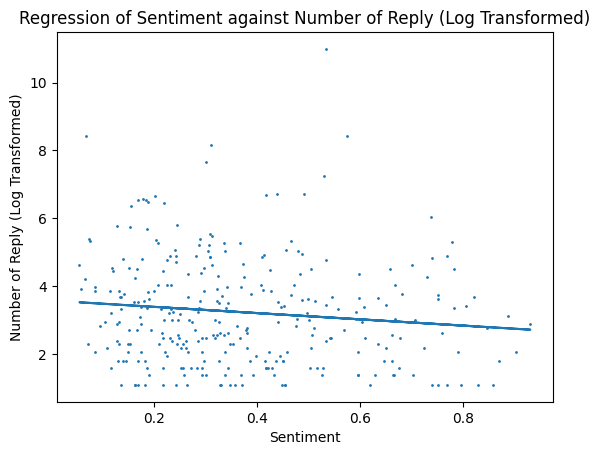

coefficient: [[-0.92258847]]
correlation: -0.11714494071775991


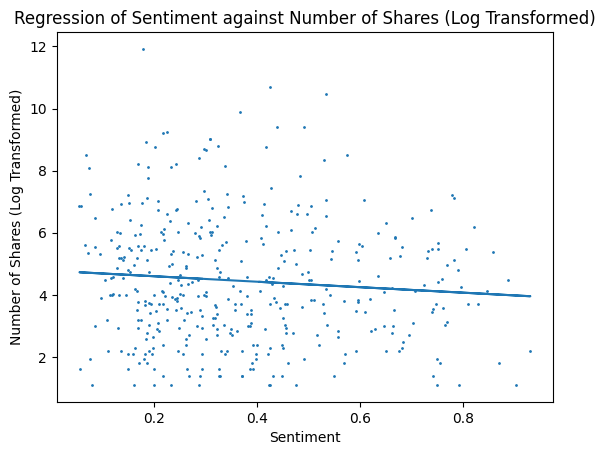

coefficient: [[-0.88390985]]
correlation: -0.0883742843048224


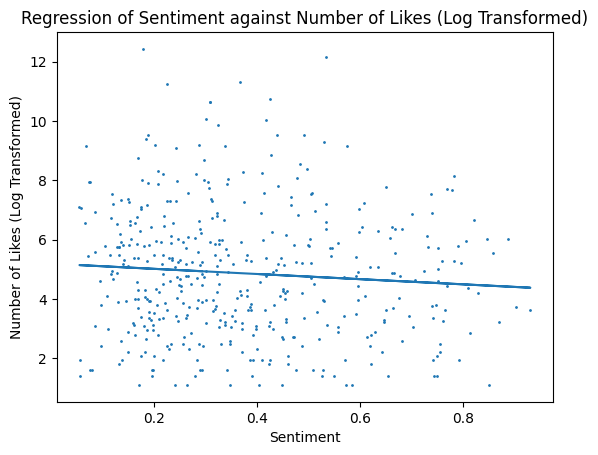

coefficient: [[-0.87351026]]
correlation: -0.08082229408688925


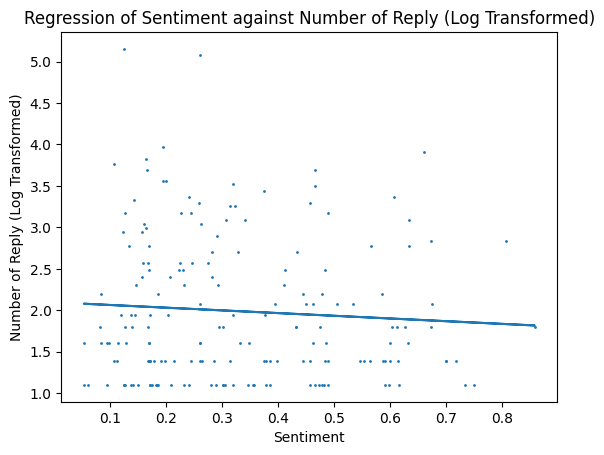

coefficient: [[-0.32581267]]
correlation: -0.06996776263303621


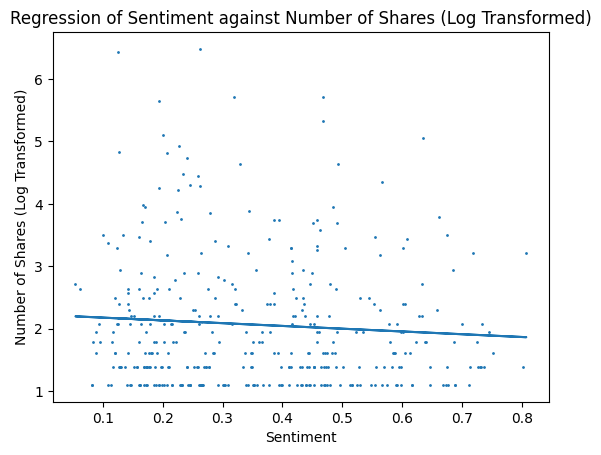

coefficient: [[-0.44350175]]
correlation: -0.0748441151323431


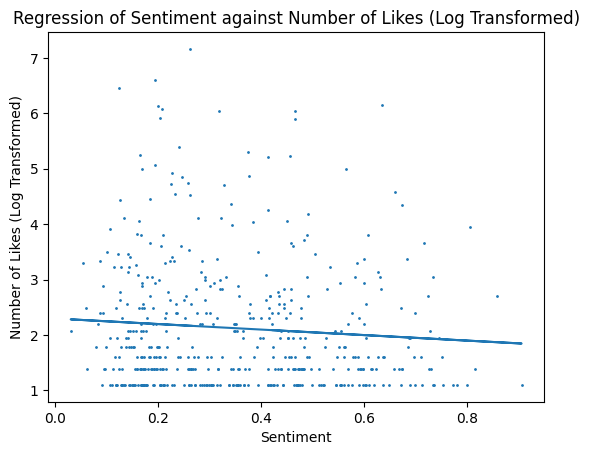

coefficient: [[-0.49786077]]
correlation: -0.07949237241516897


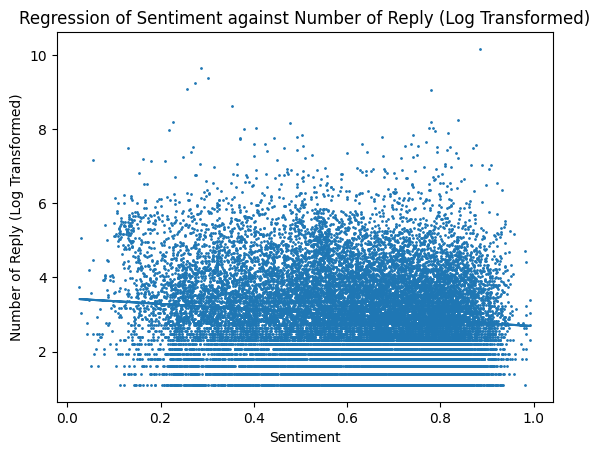

coefficient: [[-0.74877332]]
correlation: -0.12421512836144939


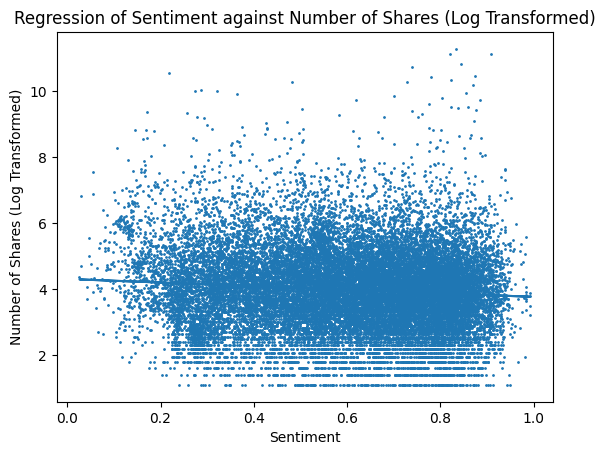

coefficient: [[-0.5421399]]
correlation: -0.08827273939209968


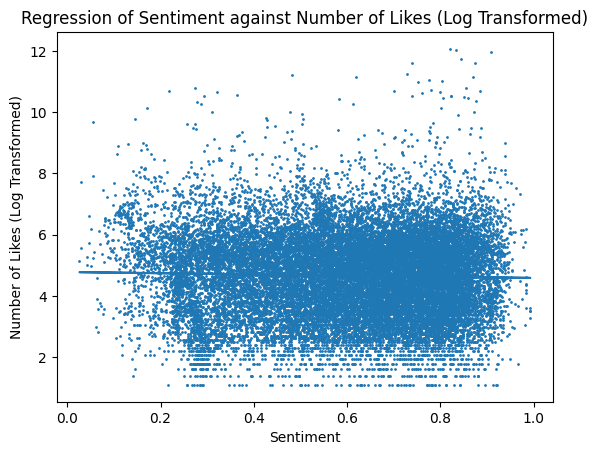

coefficient: [[-0.19334498]]
correlation: -0.02818801131471479


In [44]:
initRaw()
pltRRL(a, "Sentiment", ["reply numbers", "retweet numbers", "likes numbers"])
pltRRL(f, "Sentiment", ["replyCount", "retweetCount", "likeCount"])
pltRRL(e, "Sentiment", ["replyCount", "retweetCount", "likeCount"])

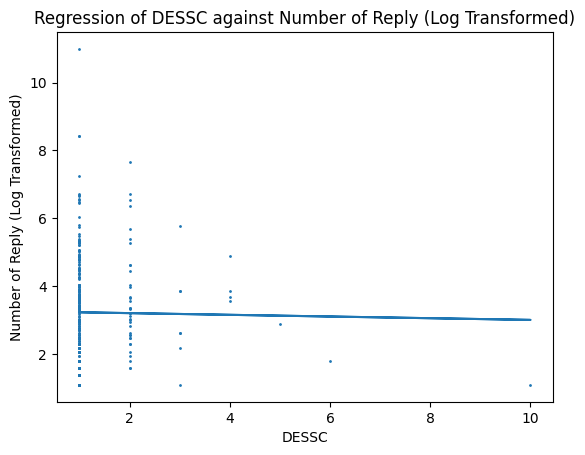

coefficient: [[-0.02492544]]
correlation: -0.013055787655738137


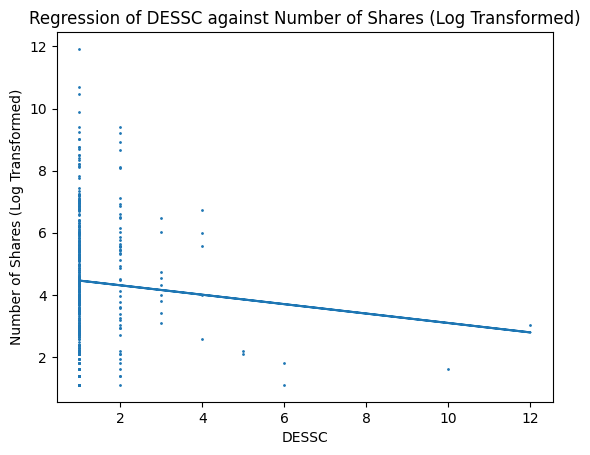

coefficient: [[-0.15174379]]
correlation: -0.07332867384871089


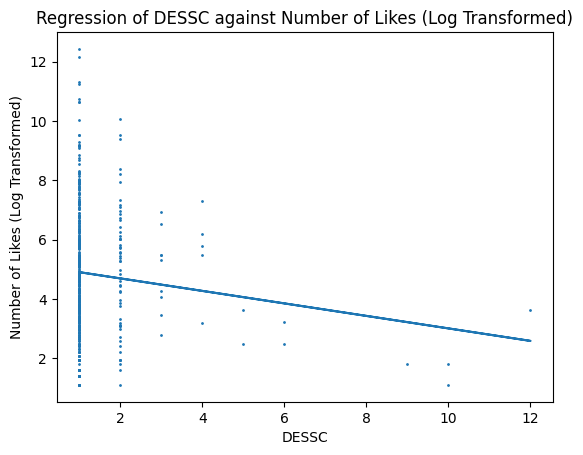

coefficient: [[-0.21070087]]
correlation: -0.10641474017599521


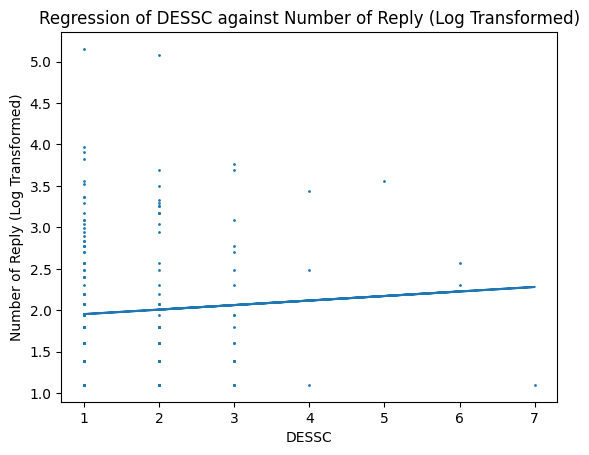

coefficient: [[0.05468117]]
correlation: 0.06377021828051656


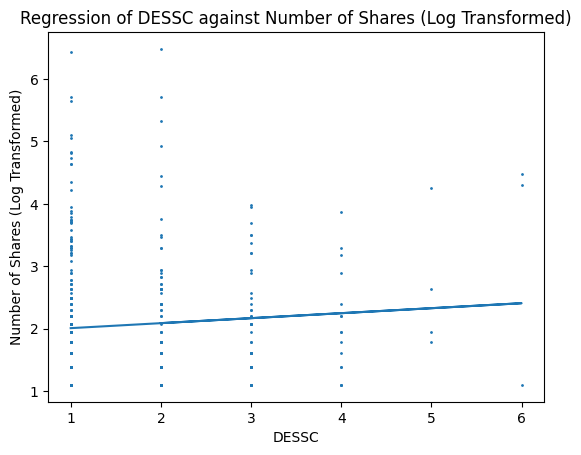

coefficient: [[0.07990707]]
correlation: 0.07578189807940547


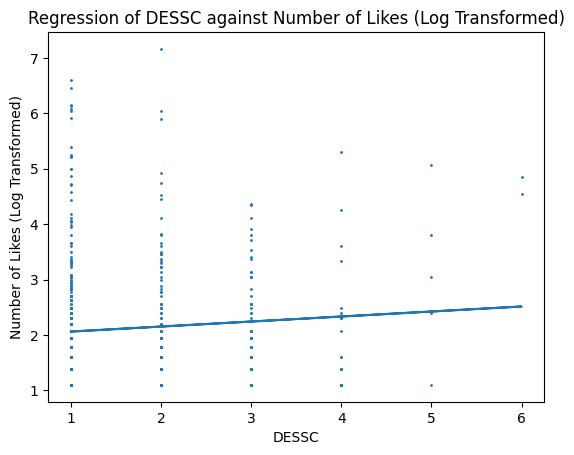

coefficient: [[0.09058483]]
correlation: 0.0755768143296537


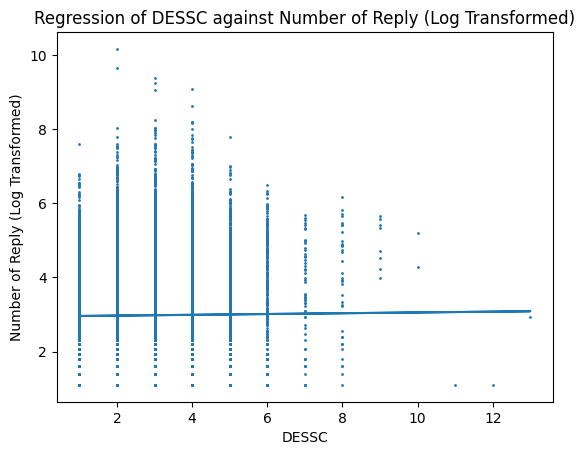

coefficient: [[0.01063556]]
correlation: 0.00910758719748491


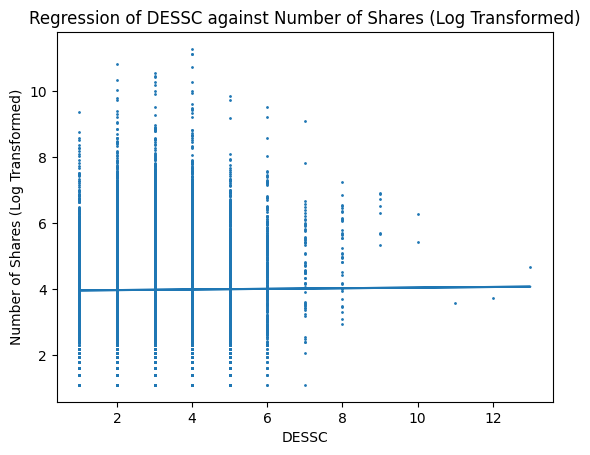

coefficient: [[0.00941079]]
correlation: 0.007867645730896706


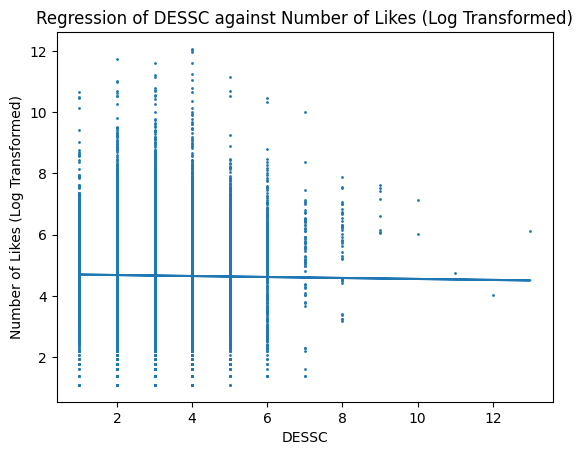

coefficient: [[-0.01589034]]
correlation: -0.011901549059993353


In [45]:
initRaw()
pltRRL(a, "DESSC", ["reply numbers", "retweet numbers", "likes numbers"])
pltRRL(f, "DESSC", ["replyCount", "retweetCount", "likeCount"])
pltRRL(e, "DESSC", ["replyCount", "retweetCount", "likeCount"])

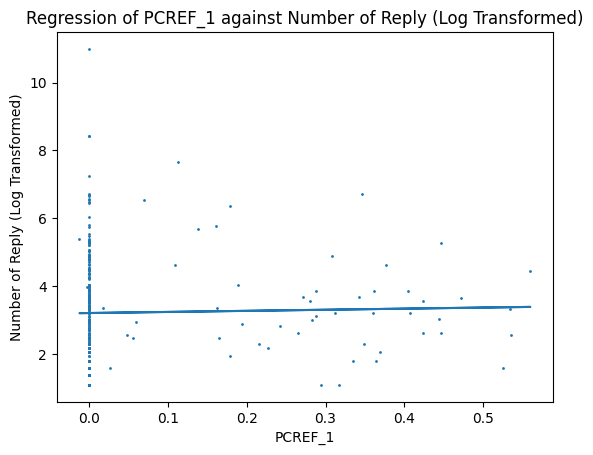

coefficient: [[0.32181596]]
correlation: 0.024938562469879


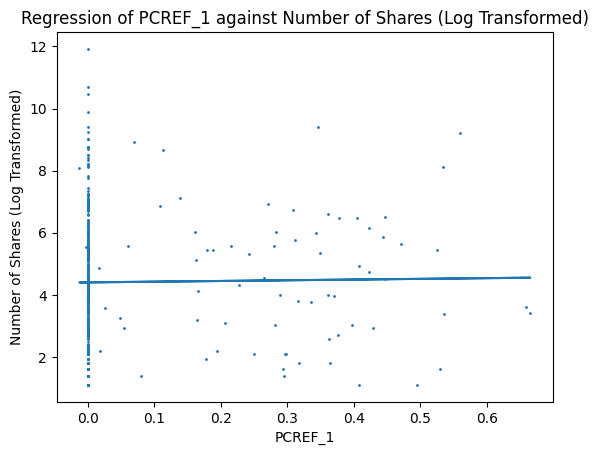

coefficient: [[0.22722578]]
correlation: 0.014689858375879685


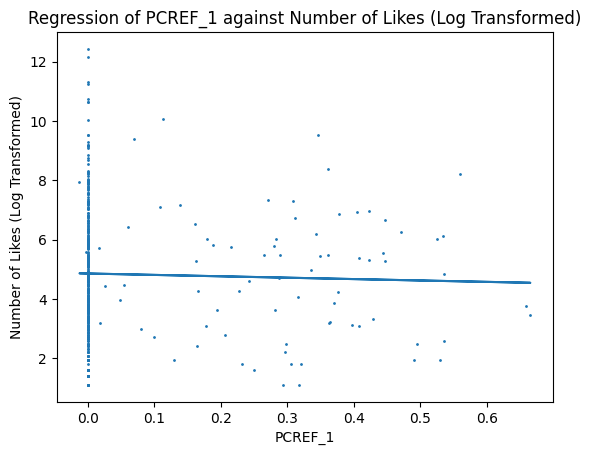

coefficient: [[-0.46998204]]
correlation: -0.028365546630635098


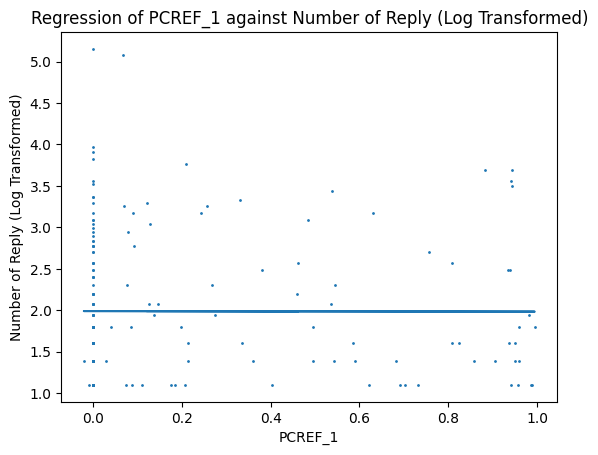

coefficient: [[-0.00686994]]
correlation: -0.0025957023848529885


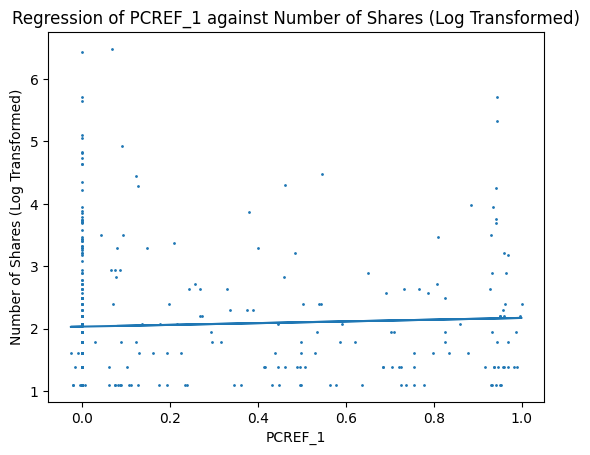

coefficient: [[0.13925881]]
correlation: 0.04454247359041453


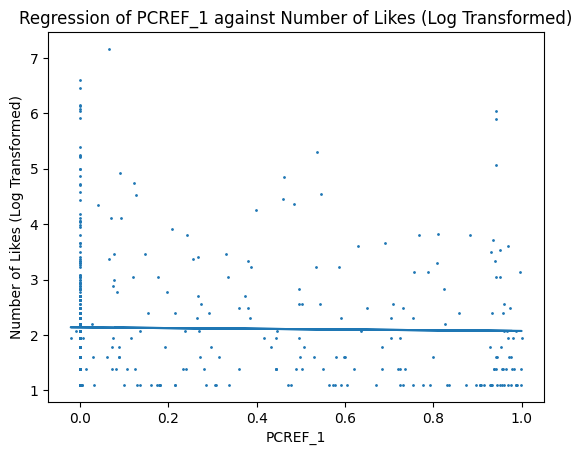

coefficient: [[-0.06550287]]
correlation: -0.01941841356030618


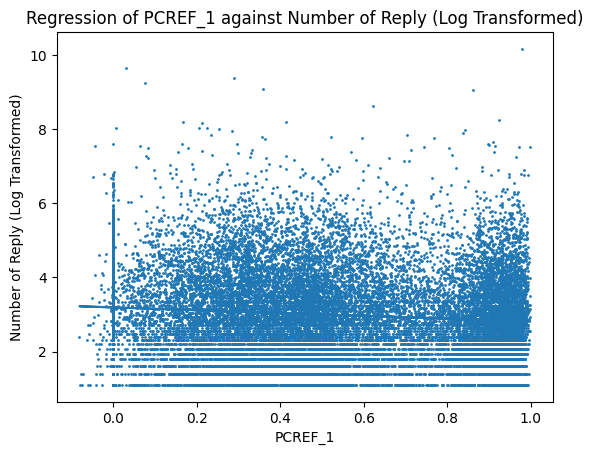

coefficient: [[-0.377233]]
correlation: -0.0953436483495502


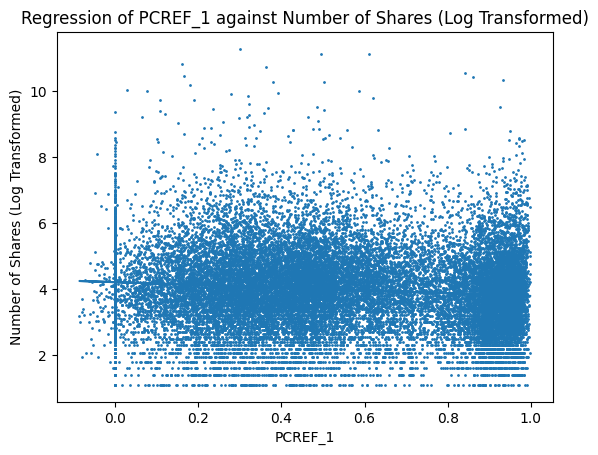

coefficient: [[-0.41738886]]
correlation: -0.102382595090411


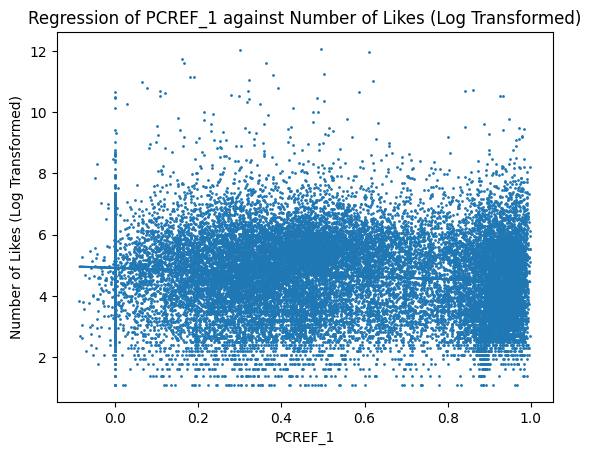

coefficient: [[-0.461237]]
correlation: -0.10137351875987266


In [46]:
initRaw()
pltRRL(a, "PCREF_1", ["reply numbers", "retweet numbers", "likes numbers"])
pltRRL(f, "PCREF_1", ["replyCount", "retweetCount", "likeCount"])
pltRRL(e, "PCREF_1", ["replyCount", "retweetCount", "likeCount"])

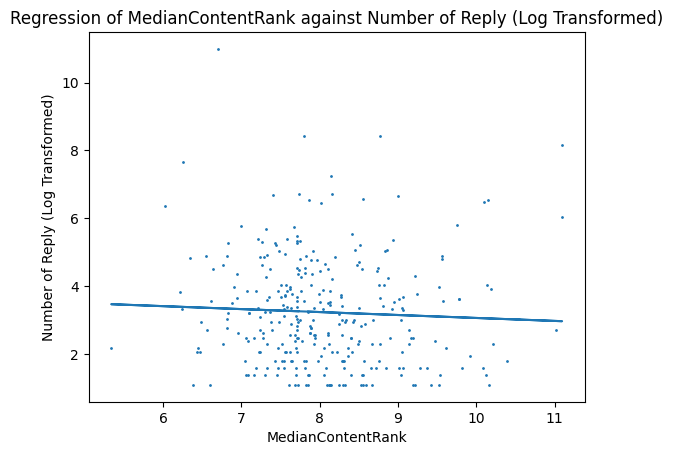

coefficient: [[-0.08691687]]
correlation: -0.050652708900113565


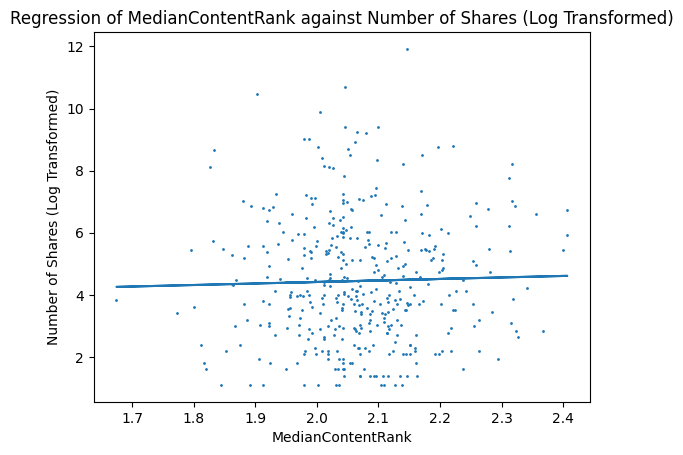

coefficient: [[0.48703745]]
correlation: 0.027419221303547472


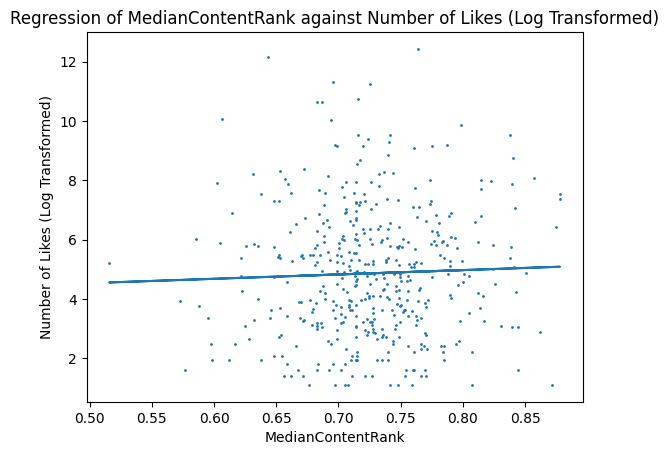

coefficient: [[1.46416329]]
correlation: 0.03691158810877423


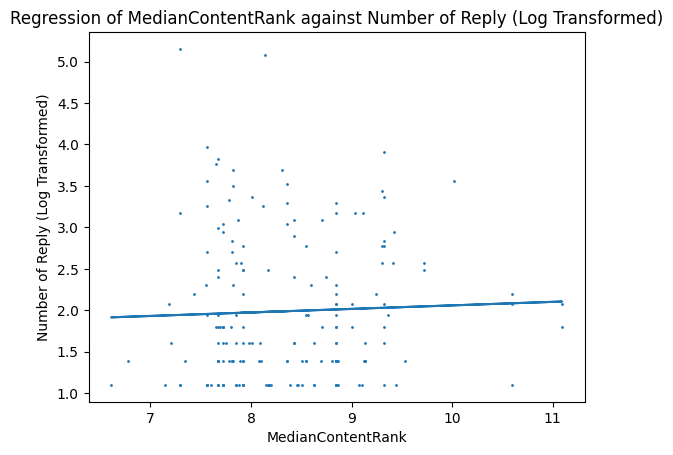

coefficient: [[0.04252138]]
correlation: 0.03805112944883842


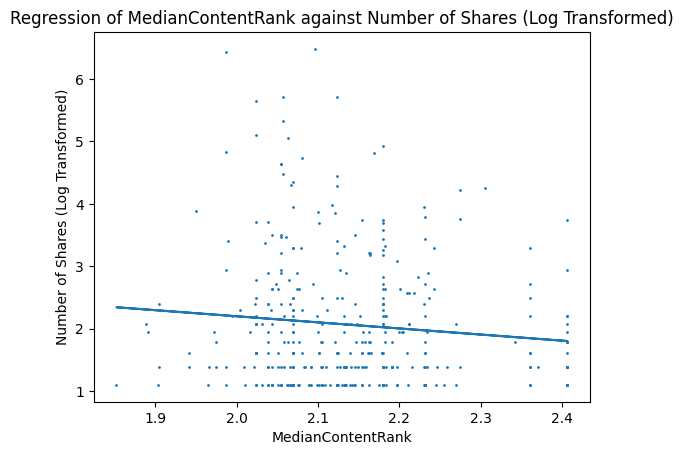

coefficient: [[-0.97660853]]
correlation: -0.1014762689095485


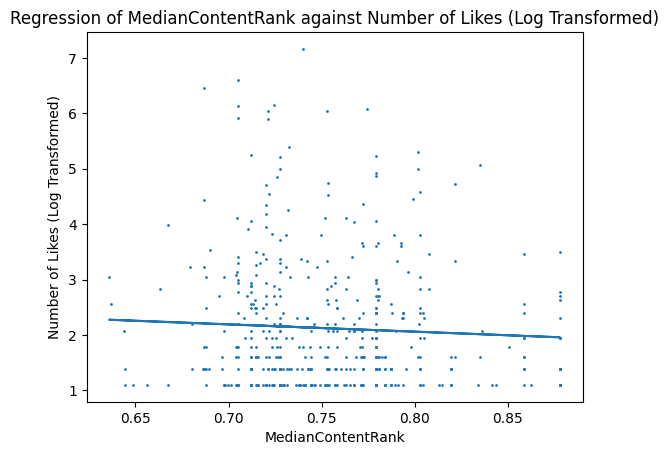

coefficient: [[-1.30973991]]
correlation: -0.053532384867493316


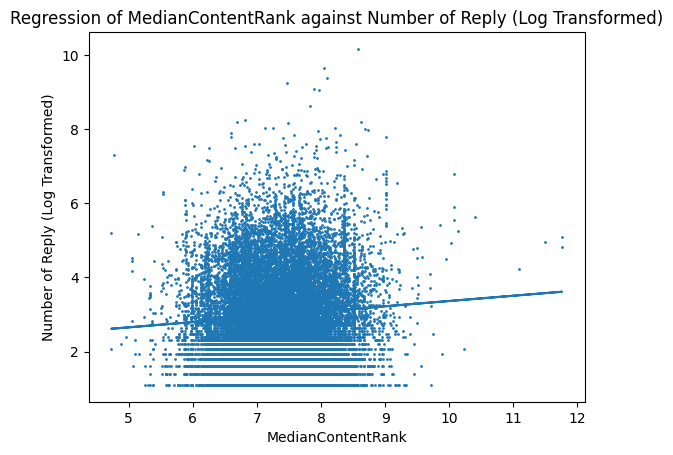

coefficient: [[0.14211011]]
correlation: 0.07826432889660902


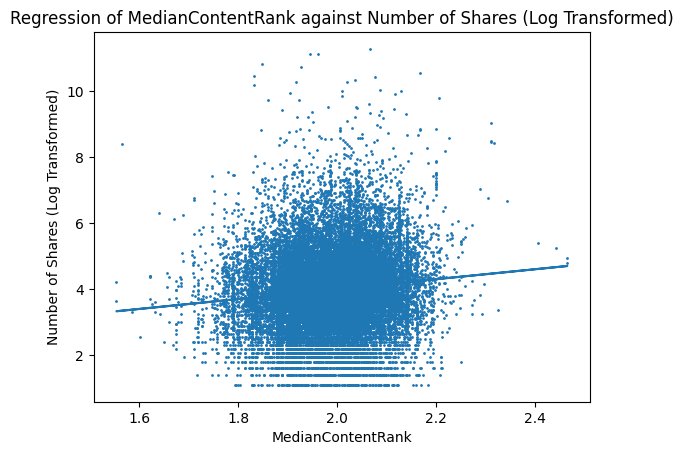

coefficient: [[1.50462923]]
correlation: 0.11101652456389799


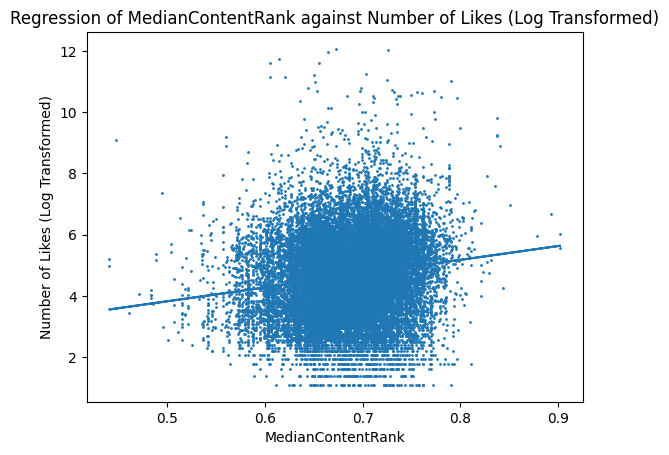

coefficient: [[4.50537412]]
correlation: 0.15091407556990372


In [75]:
initRaw()
pltRRL(a, "MedianContentRank", ["reply numbers", "retweet numbers", "likes numbers"])
pltRRL(f, "MedianContentRank", ["replyCount", "retweetCount", "likeCount"])
pltRRL(e, "MedianContentRank", ["replyCount", "retweetCount", "likeCount"])

In [50]:
a["MedianContentRank"]

0      10570.0
1       2575.0
2       5263.0
3       2009.0
4       1513.0
        ...   
535     2247.0
536     2267.0
537     4735.5
538     2247.0
539     1126.0
Name: MedianContentRank, Length: 540, dtype: float64

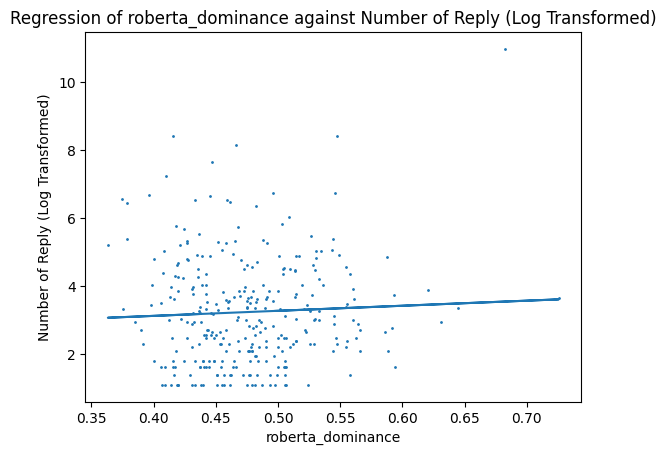

coefficient: [[1.49217215]]
correlation: 0.04917433538576703


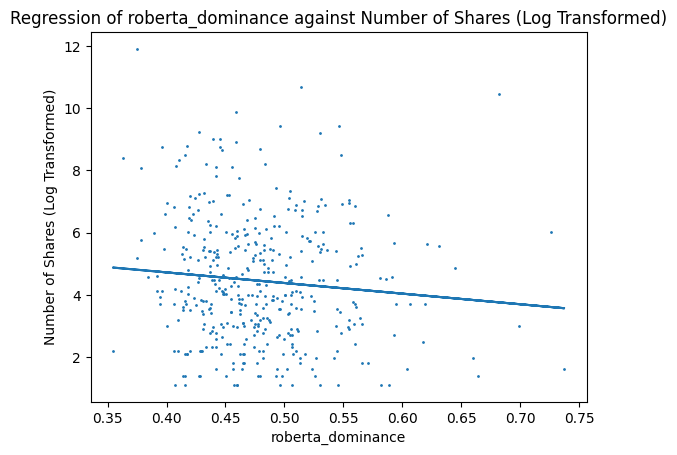

coefficient: [[-3.4216036]]
correlation: -0.09682039693610735


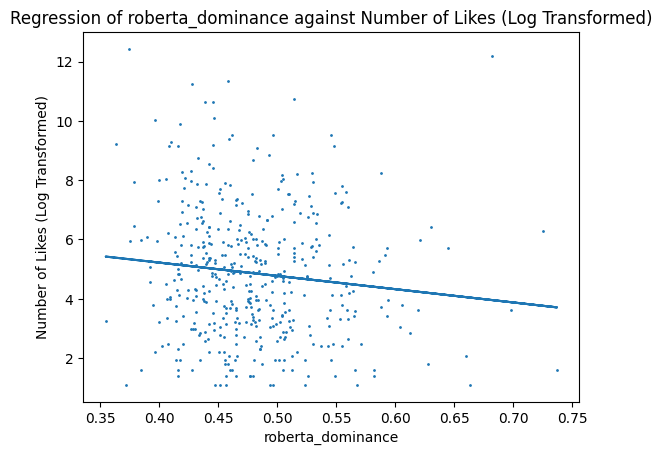

coefficient: [[-4.4781113]]
correlation: -0.11673769266006655


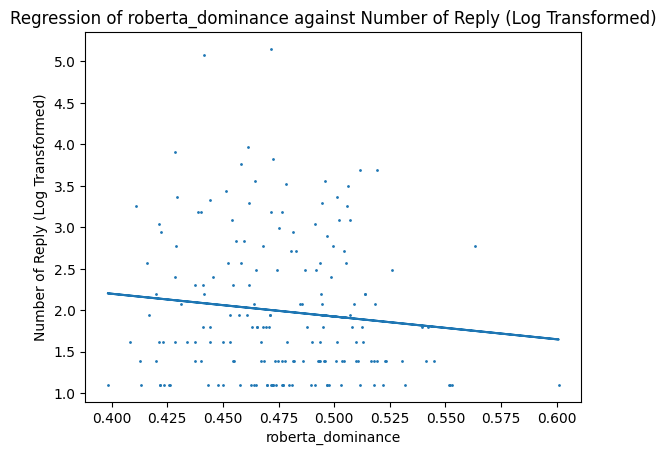

coefficient: [[-2.74453689]]
correlation: -0.11158007560110178


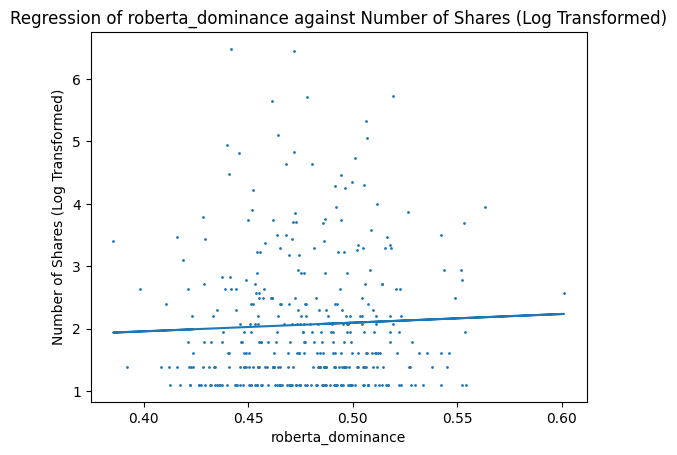

coefficient: [[1.38841493]]
correlation: 0.043485613502593085


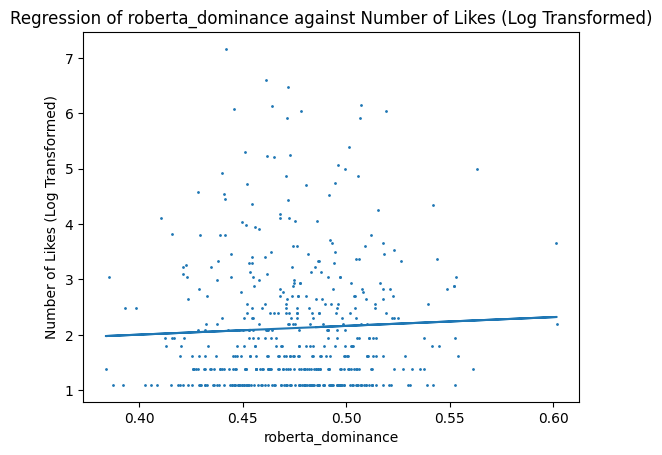

coefficient: [[1.58167408]]
correlation: 0.04515233424675527


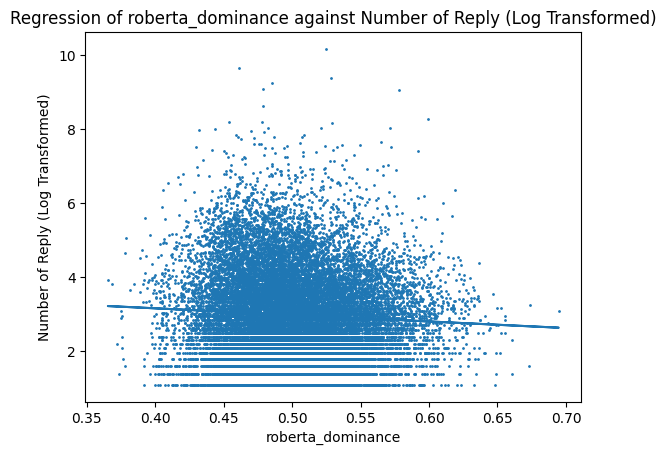

coefficient: [[-1.77395767]]
correlation: -0.06060851734420921


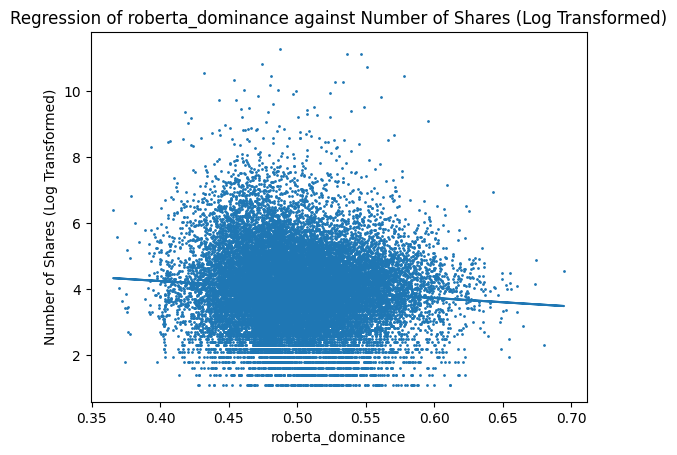

coefficient: [[-2.56814935]]
correlation: -0.08586190772683513


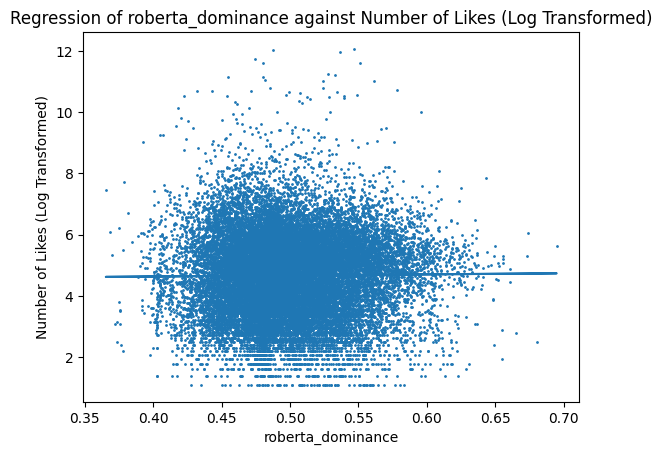

coefficient: [[0.34993791]]
correlation: 0.010494187007434796


In [51]:
initRaw()
pltRRL(a, "roberta_dominance", ["reply numbers", "retweet numbers", "likes numbers"])
pltRRL(f, "roberta_dominance", ["replyCount", "retweetCount", "likeCount"])
pltRRL(e, "roberta_dominance", ["replyCount", "retweetCount", "likeCount"])

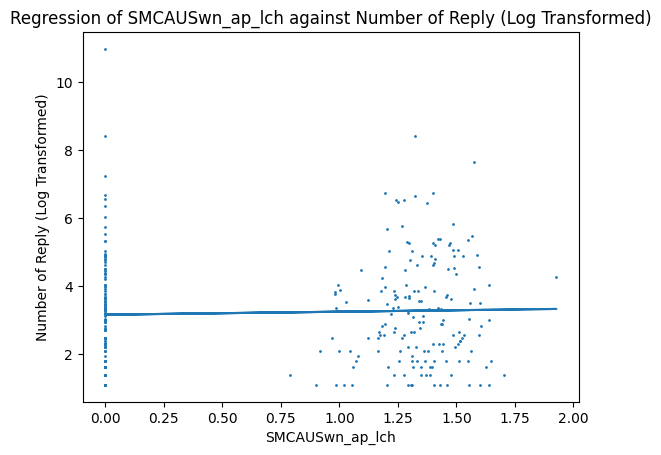

coefficient: [[0.08772652]]
correlation: 0.03776474094090979


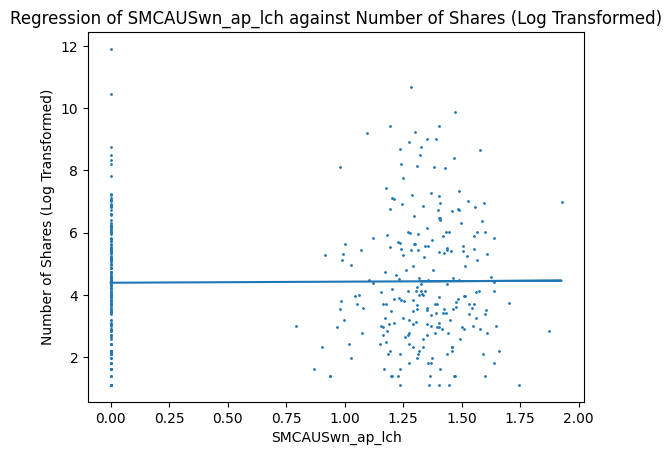

coefficient: [[0.03477156]]
correlation: 0.011652328882708576


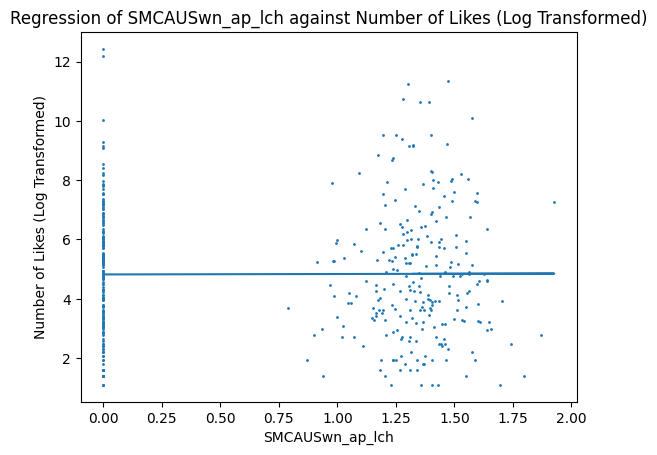

coefficient: [[0.01452543]]
correlation: 0.004537396142526064


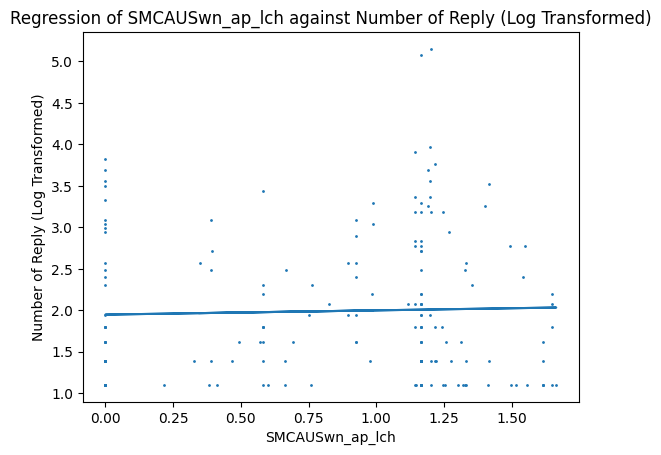

coefficient: [[0.05126119]]
correlation: 0.032085275261268247


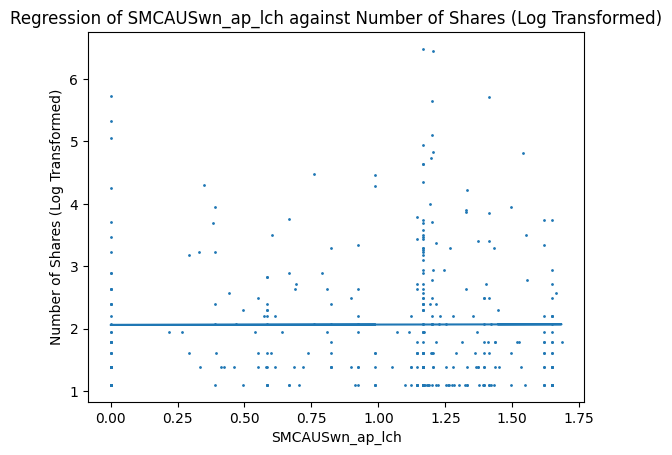

coefficient: [[0.00620419]]
correlation: 0.003053783780266849


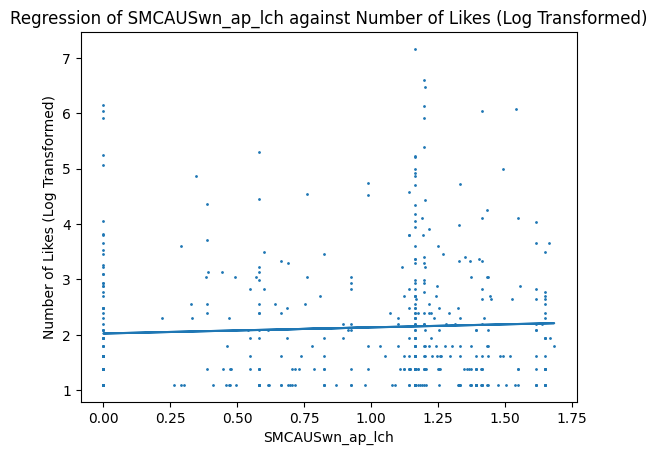

coefficient: [[0.11041643]]
correlation: 0.05216945234291999


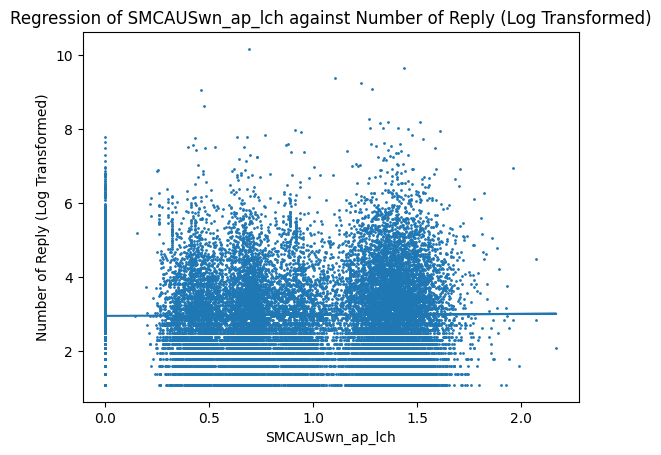

coefficient: [[0.02677794]]
correlation: 0.011200612022869007


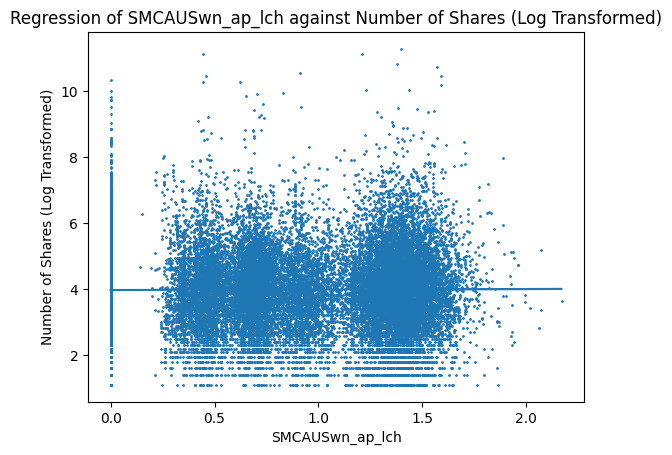

coefficient: [[0.01497056]]
correlation: 0.006208312278864413


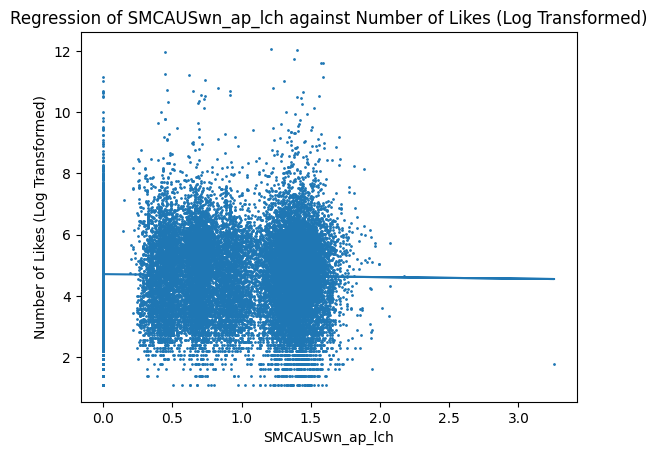

coefficient: [[-0.04908333]]
correlation: -0.018246280530633457


In [52]:
initRaw()
pltRRL(a, "SMCAUSwn_ap_lch", ["reply numbers", "retweet numbers", "likes numbers"])
pltRRL(f, "SMCAUSwn_ap_lch", ["replyCount", "retweetCount", "likeCount"])
pltRRL(e, "SMCAUSwn_ap_lch", ["replyCount", "retweetCount", "likeCount"])

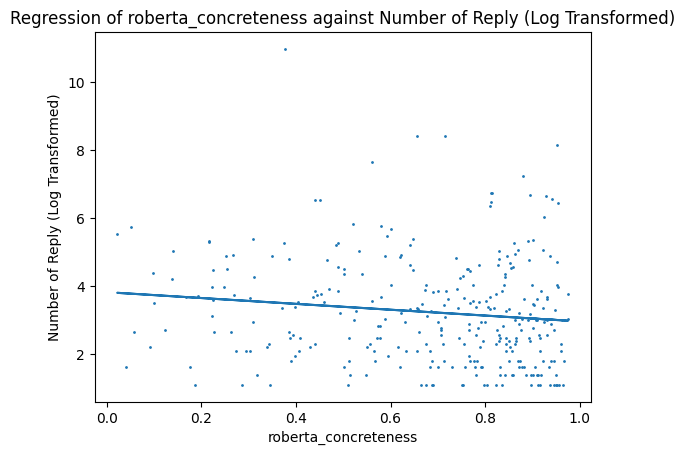

coefficient: [[-0.86141686]]
correlation: -0.12911869795389752


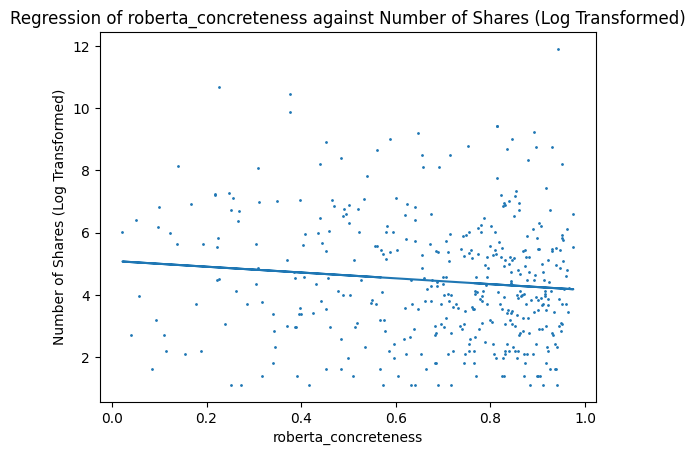

coefficient: [[-0.93698352]]
correlation: -0.10715637446628554


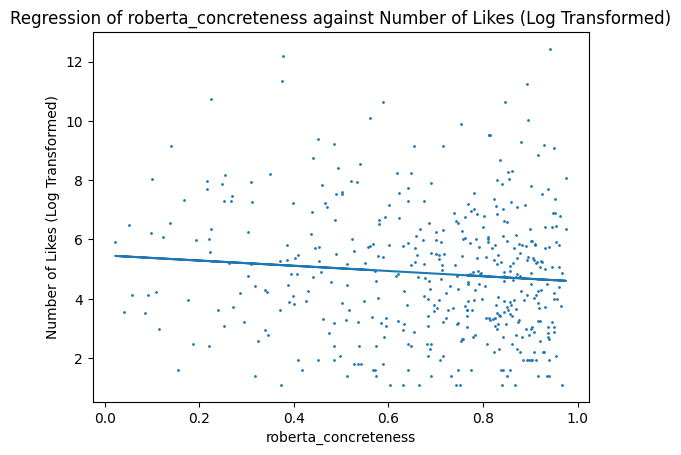

coefficient: [[-0.88096991]]
correlation: -0.09218444742168834


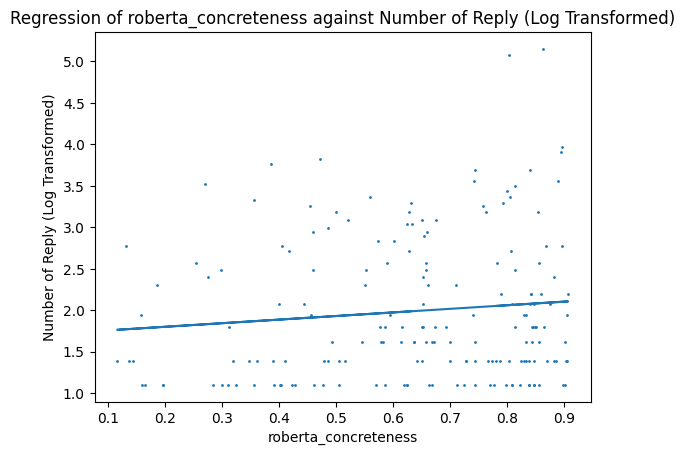

coefficient: [[0.43375487]]
correlation: 0.10529572320901956


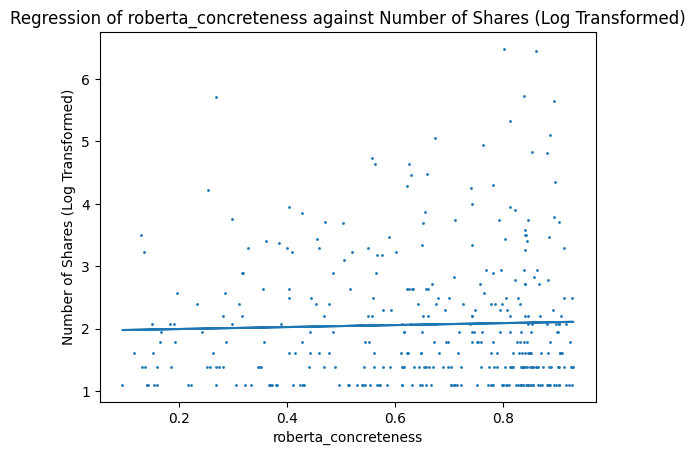

coefficient: [[0.15805902]]
correlation: 0.033351669726967945


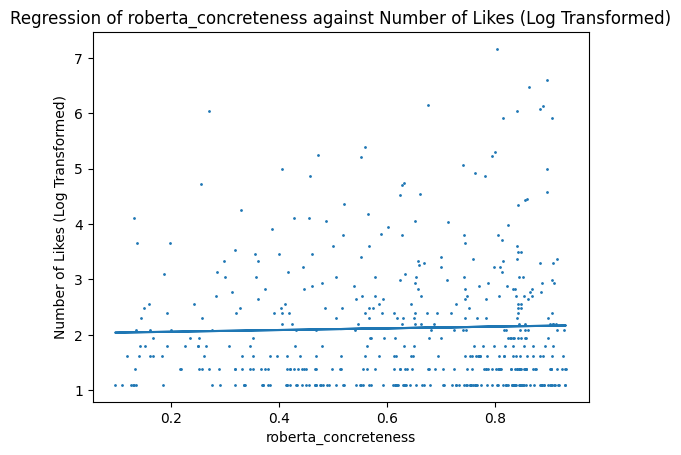

coefficient: [[0.15439056]]
correlation: 0.029974824682136803


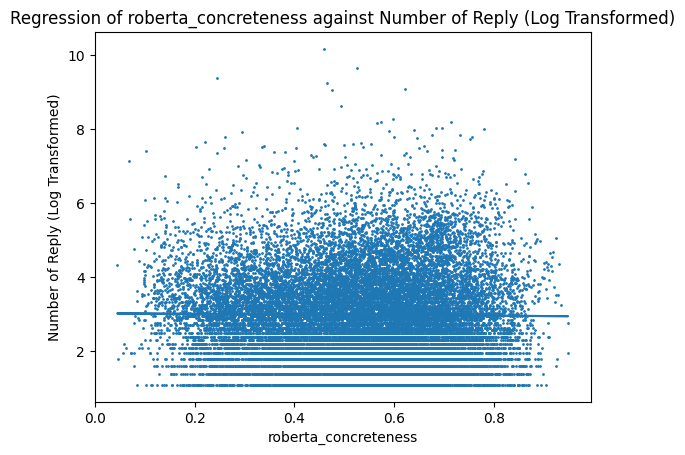

coefficient: [[-0.08224104]]
correlation: -0.011709811472250448


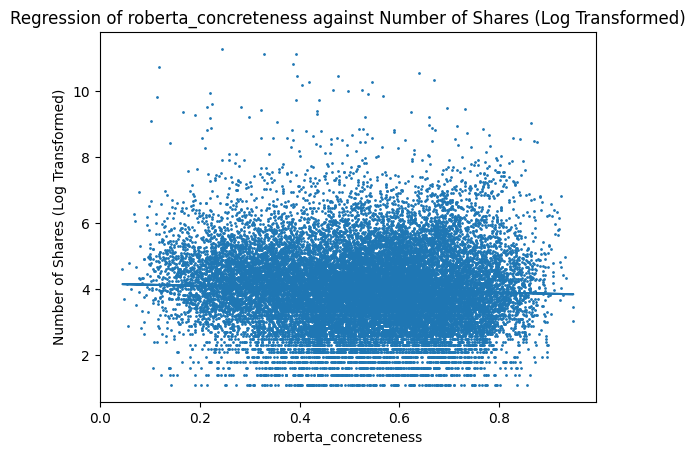

coefficient: [[-0.33901036]]
correlation: -0.046935696674926614


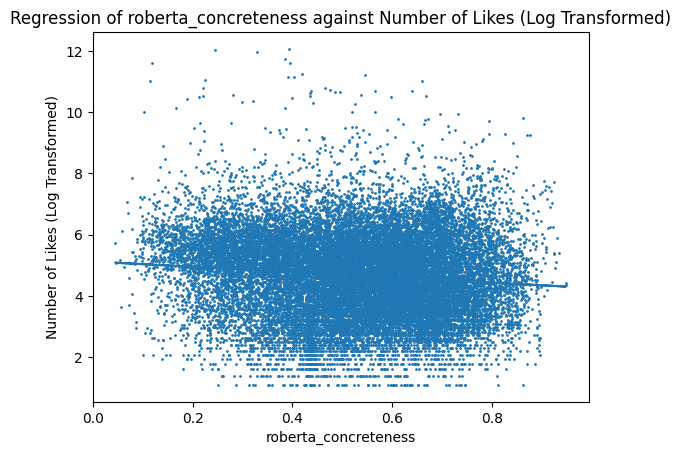

coefficient: [[-0.86088658]]
correlation: -0.10668722955371676


In [53]:
initRaw()
pltRRL(a, "roberta_concreteness", ["reply numbers", "retweet numbers", "likes numbers"])
pltRRL(f, "roberta_concreteness", ["replyCount", "retweetCount", "likeCount"])
pltRRL(e, "roberta_concreteness", ["replyCount", "retweetCount", "likeCount"])